In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2019/PEDIATRIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 9 questions
Page 1, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=180.3, y1=109.2
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 507
Page 1, Q1, A: Yellow percentage: 0.0%


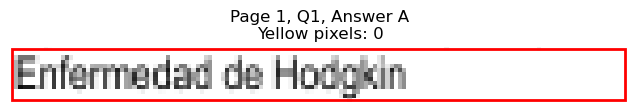

Page 1, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=275.2, y1=121.3
Page 1, Q1, B: Yellow pixels: 42
Page 1, Q1, B: Total non-white pixels: 1037
Page 1, Q1, B: Yellow percentage: 4.1%


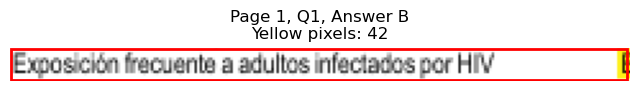

Page 1, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=272.9, y1=133.3
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 926
Page 1, Q1, C: Yellow percentage: 0.0%


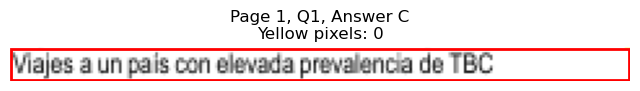

Page 1, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=454.9, y1=109.2
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 597
Page 1, Q1, D: Yellow percentage: 0.0%


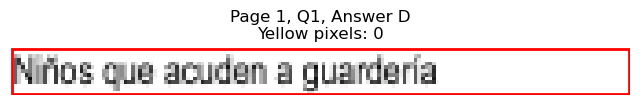

Page 1, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=441.1, y1=121.3
Page 1, Q1, E: Yellow pixels: 1452
Page 1, Q1, E: Total non-white pixels: 2028
Page 1, Q1, E: Yellow percentage: 71.6%


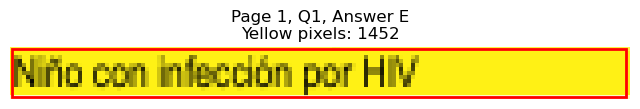


Page 1, Q1 - Selected Answer: E (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=85.0, y0=181.4, x1=239.6, y1=193.5
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 797
Page 1, Q2, A: Yellow percentage: 0.0%


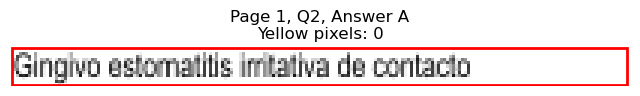

Page 1, Q2 - B: Detected box: x0=85.0, y0=193.4, x1=148.7, y1=205.5
Page 1, Q2, B: Yellow pixels: 0
Page 1, Q2, B: Total non-white pixels: 326
Page 1, Q2, B: Yellow percentage: 0.0%


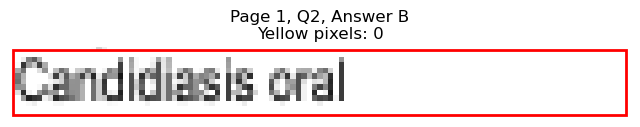

Page 1, Q2 - C: Detected box: x0=85.0, y0=205.5, x1=155.4, y1=217.7
Page 1, Q2, C: Yellow pixels: 1288
Page 1, Q2, C: Total non-white pixels: 1586
Page 1, Q2, C: Yellow percentage: 81.2%


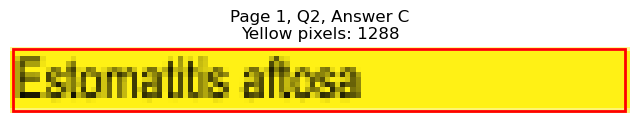

Page 1, Q2 - D: Detected box: x0=336.7, y0=181.4, x1=460.7, y1=193.5
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 663
Page 1, Q2, D: Yellow percentage: 0.0%


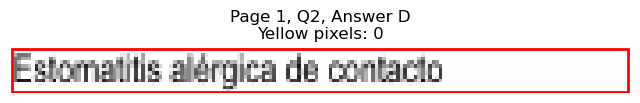

Page 1, Q2 - E: Detected box: x0=336.7, y0=193.4, x1=481.8, y1=205.5
Page 1, Q2, E: Yellow pixels: 0
Page 1, Q2, E: Total non-white pixels: 763
Page 1, Q2, E: Yellow percentage: 0.0%


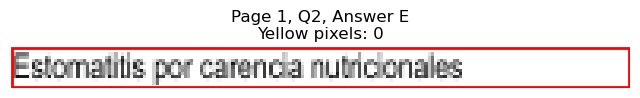


Page 1, Q2 - Selected Answer: C (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=85.0, y0=241.7, x1=126.1, y1=253.8
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 238
Page 1, Q3, A: Yellow percentage: 0.0%


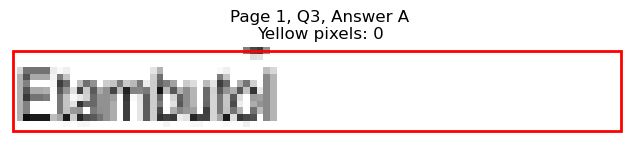

Page 1, Q3 - B: Detected box: x0=85.0, y0=253.7, x1=144.4, y1=265.8
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 316
Page 1, Q3, B: Yellow percentage: 0.0%


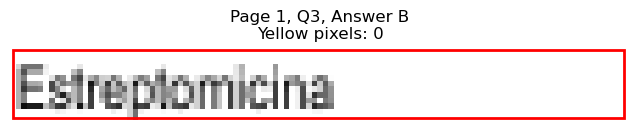

Page 1, Q3 - C: Detected box: x0=85.0, y0=265.8, x1=132.4, y1=277.9
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 251
Page 1, Q3, C: Yellow percentage: 0.0%


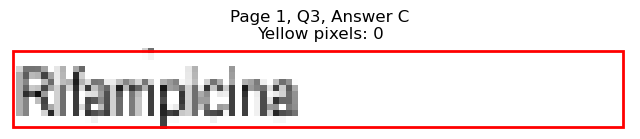

Page 1, Q3 - D: Detected box: x0=336.7, y0=241.7, x1=377.8, y1=253.8
Page 1, Q3, D: Yellow pixels: 918
Page 1, Q3, D: Total non-white pixels: 1196
Page 1, Q3, D: Yellow percentage: 76.8%


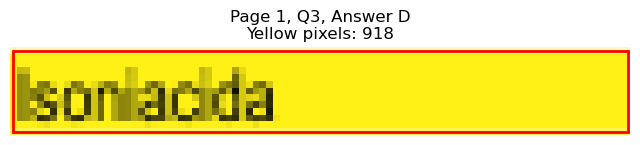

Page 1, Q3 - E: Detected box: x0=336.7, y0=253.7, x1=389.0, y1=265.8
Page 1, Q3, E: Yellow pixels: 103
Page 1, Q3, E: Total non-white pixels: 379
Page 1, Q3, E: Yellow percentage: 27.2%


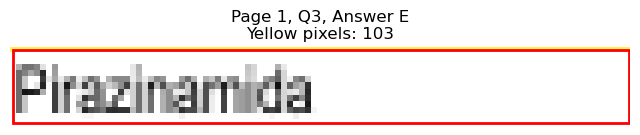


Page 1, Q3 - Selected Answer: D (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=85.0, y0=326.1, x1=208.0, y1=338.2
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 634
Page 1, Q4, A: Yellow percentage: 0.0%


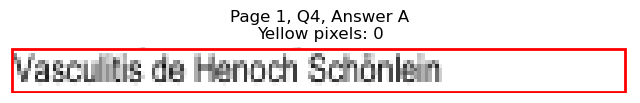

Page 1, Q4 - B: Detected box: x0=85.0, y0=338.1, x1=198.5, y1=350.2
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 589
Page 1, Q4, B: Yellow percentage: 0.0%


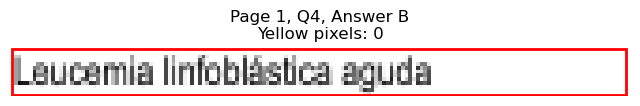

Page 1, Q4 - C: Detected box: x0=85.0, y0=350.2, x1=149.2, y1=362.3
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 315
Page 1, Q4, C: Yellow percentage: 0.0%


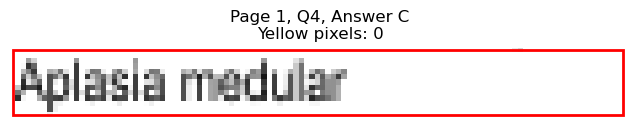

Page 1, Q4 - D: Detected box: x0=336.7, y0=326.1, x1=448.2, y1=338.2
Page 1, Q4, D: Yellow pixels: 163
Page 1, Q4, D: Total non-white pixels: 729
Page 1, Q4, D: Yellow percentage: 22.4%


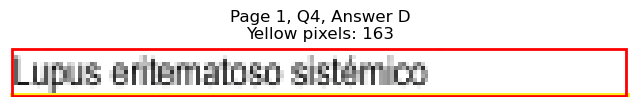

Page 1, Q4 - E: Detected box: x0=336.7, y0=338.1, x1=467.4, y1=350.2
Page 1, Q4, E: Yellow pixels: 1655
Page 1, Q4, E: Total non-white pixels: 2366
Page 1, Q4, E: Yellow percentage: 69.9%


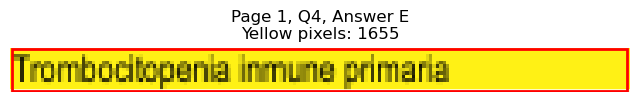


Page 1, Q4 - Selected Answer: E (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=85.0, y0=386.3, x1=159.1, y1=398.4
Page 1, Q5, A: Yellow pixels: 126
Page 1, Q5, A: Total non-white pixels: 534
Page 1, Q5, A: Yellow percentage: 23.6%


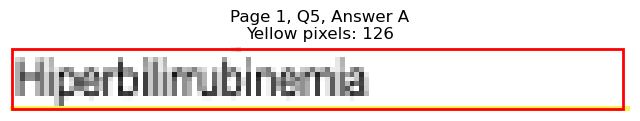

Page 1, Q5 - B: Detected box: x0=85.0, y0=398.3, x1=140.1, y1=410.4
Page 1, Q5, B: Yellow pixels: 1159
Page 1, Q5, B: Total non-white pixels: 1391
Page 1, Q5, B: Yellow percentage: 83.3%


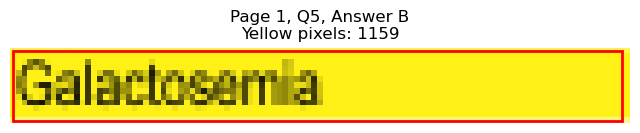

Page 1, Q5 - C: Detected box: x0=85.0, y0=410.4, x1=172.6, y1=422.5
Page 1, Q5, C: Yellow pixels: 139
Page 1, Q5, C: Total non-white pixels: 579
Page 1, Q5, C: Yellow percentage: 24.0%


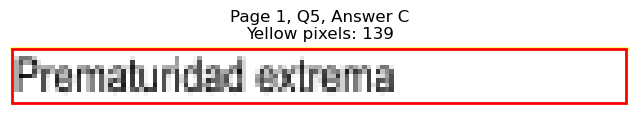

Page 1, Q5 - D: Detected box: x0=336.7, y0=386.3, x1=399.3, y1=398.4
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 287
Page 1, Q5, D: Yellow percentage: 0.0%


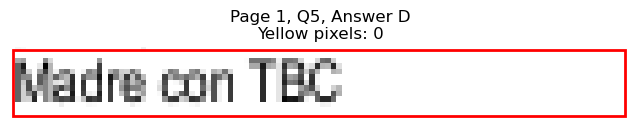

Page 1, Q5 - E: Detected box: x0=336.7, y0=398.3, x1=433.9, y1=410.4
Page 1, Q5, E: Yellow pixels: 0
Page 1, Q5, E: Total non-white pixels: 484
Page 1, Q5, E: Yellow percentage: 0.0%


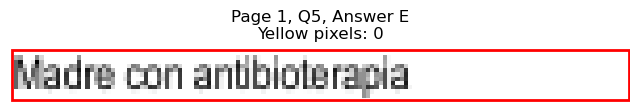


Page 1, Q5 - Selected Answer: B (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=85.0, y0=470.7, x1=145.3, y1=482.8
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 302
Page 1, Q6, A: Yellow percentage: 0.0%


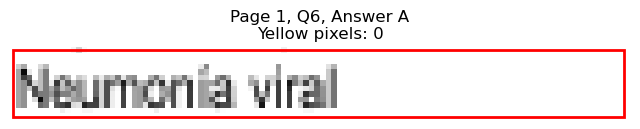

Page 1, Q6 - B: Detected box: x0=85.0, y0=482.7, x1=168.3, y1=494.8
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 420
Page 1, Q6, B: Yellow percentage: 0.0%


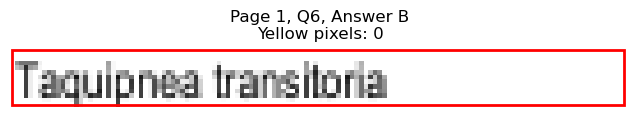

Page 1, Q6 - C: Detected box: x0=85.0, y0=494.7, x1=174.0, y1=506.8
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 455
Page 1, Q6, C: Yellow percentage: 0.0%


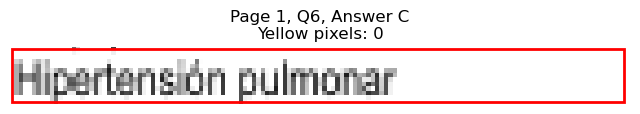

Page 1, Q6 - D: Detected box: x0=336.7, y0=470.7, x1=466.9, y1=482.8
Page 1, Q6, D: Yellow pixels: 1631
Page 1, Q6, D: Total non-white pixels: 2353
Page 1, Q6, D: Yellow percentage: 69.3%


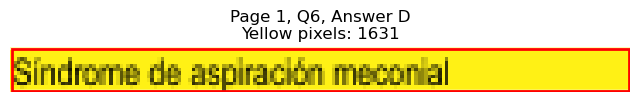

Page 1, Q6 - E: Detected box: x0=336.7, y0=482.7, x1=470.3, y1=494.8
Page 1, Q6, E: Yellow pixels: 184
Page 1, Q6, E: Total non-white pixels: 860
Page 1, Q6, E: Yellow percentage: 21.4%


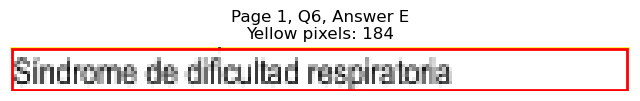


Page 1, Q6 - Selected Answer: D (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=85.0, y0=530.9, x1=155.9, y1=543.0
Page 1, Q7, A: Yellow pixels: 0
Page 1, Q7, A: Total non-white pixels: 371
Page 1, Q7, A: Yellow percentage: 0.0%


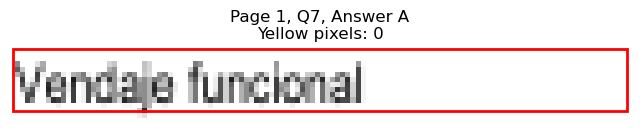

Page 1, Q7 - B: Detected box: x0=85.0, y0=542.9, x1=131.9, y1=555.0
Page 1, Q7, B: Yellow pixels: 98
Page 1, Q7, B: Total non-white pixels: 450
Page 1, Q7, B: Yellow percentage: 21.8%


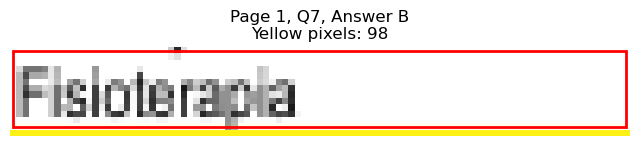

Page 1, Q7 - C: Detected box: x0=85.0, y0=554.9, x1=156.3, y1=567.0
Page 1, Q7, C: Yellow pixels: 1191
Page 1, Q7, C: Total non-white pixels: 1722
Page 1, Q7, C: Yellow percentage: 69.2%


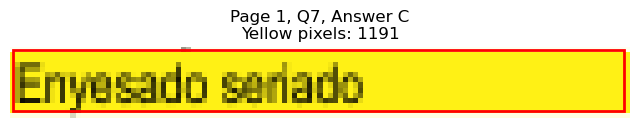

Page 1, Q7 - D: Detected box: x0=336.7, y0=530.9, x1=437.7, y1=543.0
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 515
Page 1, Q7, D: Yellow percentage: 0.0%


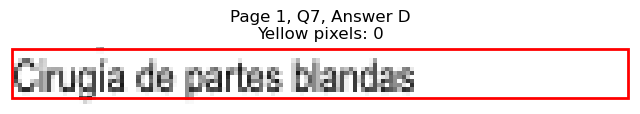

Page 1, Q7 - E: Detected box: x0=336.7, y0=542.9, x1=366.3, y1=555.0
Page 1, Q7, E: Yellow pixels: 0
Page 1, Q7, E: Total non-white pixels: 159
Page 1, Q7, E: Yellow percentage: 0.0%


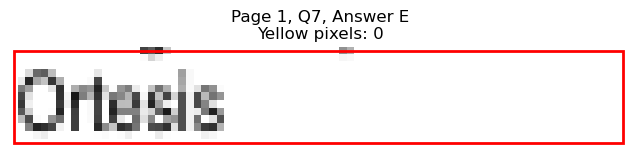


Page 1, Q7 - Selected Answer: C (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=85.0, y0=603.2, x1=228.2, y1=615.3
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 766
Page 1, Q8, A: Yellow percentage: 0.0%


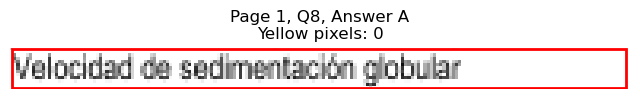

Page 1, Q8 - B: Detected box: x0=85.0, y0=615.2, x1=132.9, y1=627.3
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 262
Page 1, Q8, B: Yellow percentage: 0.0%


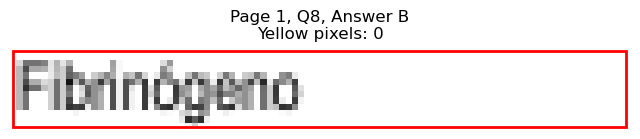

Page 1, Q8 - C: Detected box: x0=85.0, y0=627.3, x1=134.8, y1=639.4
Page 1, Q8, C: Yellow pixels: 0
Page 1, Q8, C: Total non-white pixels: 259
Page 1, Q8, C: Yellow percentage: 0.0%


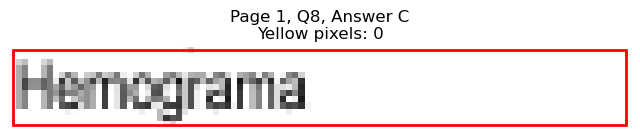

Page 1, Q8 - D: Detected box: x0=336.7, y0=603.2, x1=393.2, y1=615.3
Page 1, Q8, D: Yellow pixels: 1066
Page 1, Q8, D: Total non-white pixels: 1404
Page 1, Q8, D: Yellow percentage: 75.9%


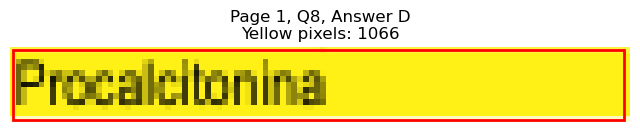

Page 1, Q8 - E: Detected box: x0=336.7, y0=615.2, x1=417.1, y1=627.3
Page 1, Q8, E: Yellow pixels: 0
Page 1, Q8, E: Total non-white pixels: 548
Page 1, Q8, E: Yellow percentage: 0.0%


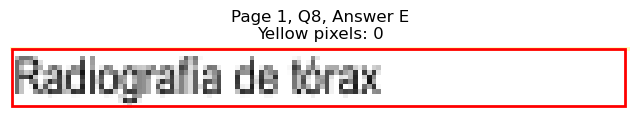


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=85.0, y0=675.4, x1=193.3, y1=687.5
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 538
Page 1, Q9, A: Yellow percentage: 0.0%


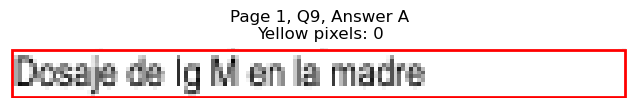

Page 1, Q9 - B: Detected box: x0=85.0, y0=687.5, x1=192.4, y1=699.7
Page 1, Q9, B: Yellow pixels: 1660
Page 1, Q9, B: Total non-white pixels: 2067
Page 1, Q9, B: Yellow percentage: 80.3%


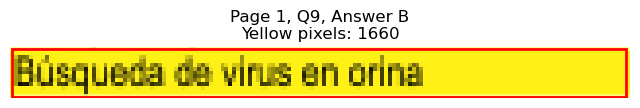

Page 1, Q9 - C: Detected box: x0=85.0, y0=699.5, x1=217.1, y1=711.7
Page 1, Q9, C: Yellow pixels: 184
Page 1, Q9, C: Total non-white pixels: 899
Page 1, Q9, C: Yellow percentage: 20.5%


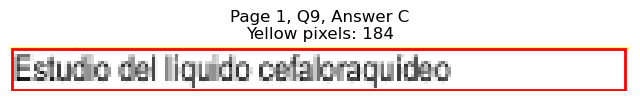

Page 1, Q9 - D: Detected box: x0=336.7, y0=675.4, x1=451.2, y1=687.5
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 565
Page 1, Q9, D: Yellow percentage: 0.0%


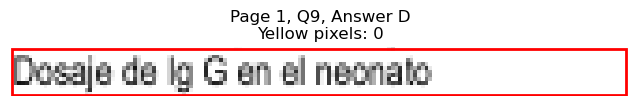

Page 1, Q9 - E: Detected box: x0=336.7, y0=687.5, x1=477.9, y1=699.7
Page 1, Q9, E: Yellow pixels: 0
Page 1, Q9, E: Total non-white pixels: 706
Page 1, Q9, E: Yellow percentage: 0.0%


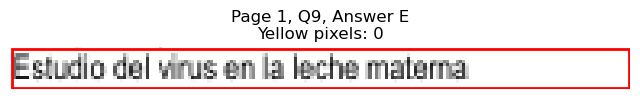


Page 1, Q9 - Selected Answer: B (based on yellow pixel count)





Page 2: Found 8 questions
Page 2, Q1 - A: Detected box: x0=85.0, y0=121.2, x1=269.0, y1=133.3
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 935
Page 2, Q1, A: Yellow percentage: 0.0%


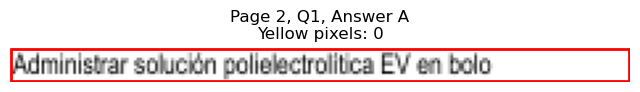

Page 2, Q1 - B: Detected box: x0=85.0, y0=133.2, x1=211.9, y1=145.3
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 636
Page 2, Q1, B: Yellow percentage: 0.0%


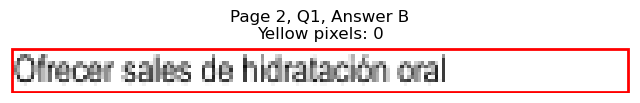

Page 2, Q1 - C: Detected box: x0=85.0, y0=145.3, x1=195.1, y1=157.4
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 552
Page 2, Q1, C: Yellow percentage: 0.0%


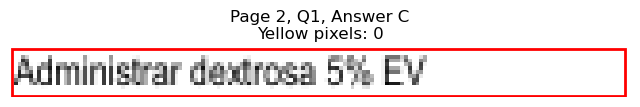

Page 2, Q1 - D: Detected box: x0=336.7, y0=121.2, x1=491.3, y1=133.3
Page 2, Q1, D: Yellow pixels: 1659
Page 2, Q1, D: Total non-white pixels: 2470
Page 2, Q1, D: Yellow percentage: 67.2%


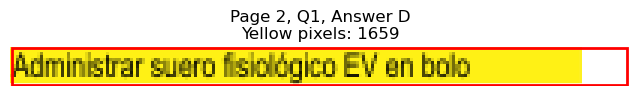

Page 2, Q1 - E: Detected box: x0=336.7, y0=133.2, x1=478.9, y1=145.3
Page 2, Q1, E: Yellow pixels: 0
Page 2, Q1, E: Total non-white pixels: 888
Page 2, Q1, E: Yellow percentage: 0.0%


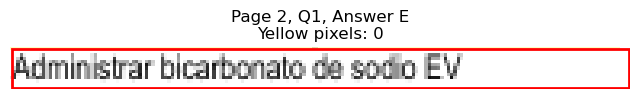


Page 2, Q1 - Selected Answer: D (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=85.0, y0=181.4, x1=169.7, y1=193.5
Page 2, Q2, A: Yellow pixels: 1427
Page 2, Q2, A: Total non-white pixels: 1768
Page 2, Q2, A: Yellow percentage: 80.7%


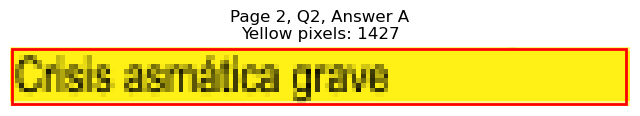

Page 2, Q2 - B: Detected box: x0=85.0, y0=193.4, x1=187.0, y1=205.5
Page 2, Q2, B: Yellow pixels: 153
Page 2, Q2, B: Total non-white pixels: 678
Page 2, Q2, B: Yellow percentage: 22.6%


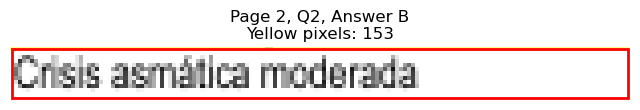

Page 2, Q2 - C: Detected box: x0=85.0, y0=205.5, x1=163.9, y1=217.7
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 407
Page 2, Q2, C: Yellow percentage: 0.0%


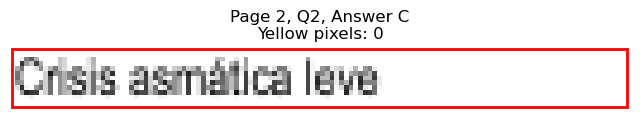

Page 2, Q2 - D: Detected box: x0=336.7, y0=181.4, x1=438.3, y1=193.5
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 509
Page 2, Q2, D: Yellow percentage: 0.0%


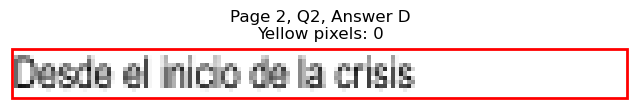

Page 2, Q2 - E: Detected box: x0=336.7, y0=193.4, x1=416.1, y1=205.5
Page 2, Q2, E: Yellow pixels: 0
Page 2, Q2, E: Total non-white pixels: 378
Page 2, Q2, E: Yellow percentage: 0.0%


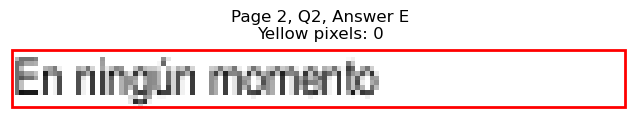


Page 2, Q2 - Selected Answer: A (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=85.0, y0=253.7, x1=145.3, y1=265.8
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 309
Page 2, Q3, A: Yellow percentage: 0.0%


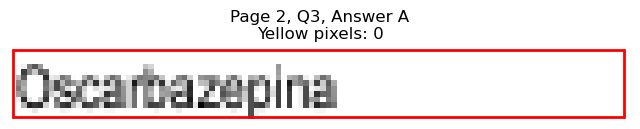

Page 2, Q3 - B: Detected box: x0=85.0, y0=265.8, x1=127.1, y1=277.9
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 325
Page 2, Q3, B: Yellow percentage: 0.0%


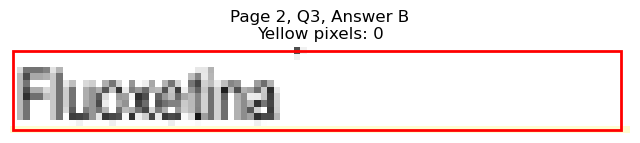

Page 2, Q3 - C: Detected box: x0=85.0, y0=277.8, x1=133.3, y1=289.9
Page 2, Q3, C: Yellow pixels: 984
Page 2, Q3, C: Total non-white pixels: 1300
Page 2, Q3, C: Yellow percentage: 75.7%


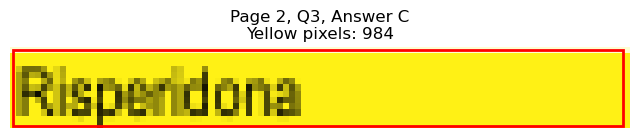

Page 2, Q3 - D: Detected box: x0=336.7, y0=253.7, x1=375.9, y1=265.8
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 211
Page 2, Q3, D: Yellow percentage: 0.0%


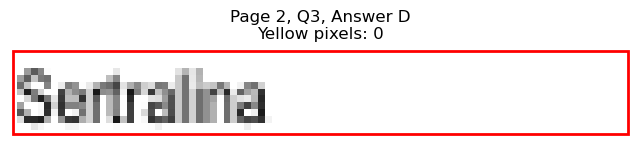

Page 2, Q3 - E: Detected box: x0=336.7, y0=265.8, x1=398.0, y1=277.9
Page 2, Q3, E: Yellow pixels: 0
Page 2, Q3, E: Total non-white pixels: 302
Page 2, Q3, E: Yellow percentage: 0.0%


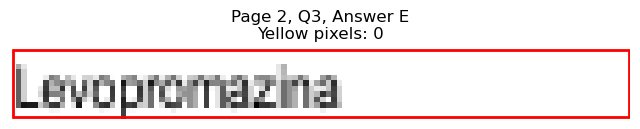


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=85.0, y0=326.1, x1=126.6, y1=338.2
Page 2, Q4, A: Yellow pixels: 93
Page 2, Q4, A: Total non-white pixels: 311
Page 2, Q4, A: Yellow percentage: 29.9%


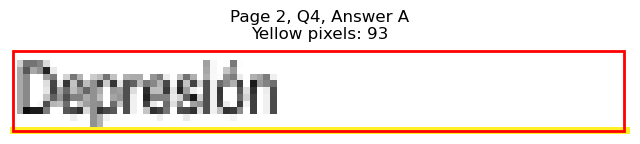

Page 2, Q4 - B: Detected box: x0=85.0, y0=338.1, x1=154.3, y1=350.2
Page 2, Q4, B: Yellow pixels: 1175
Page 2, Q4, B: Total non-white pixels: 1573
Page 2, Q4, B: Yellow percentage: 74.7%


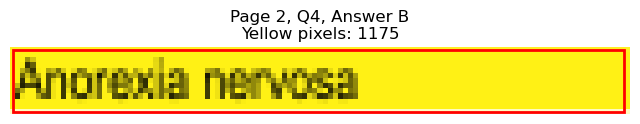

Page 2, Q4 - C: Detected box: x0=85.0, y0=350.2, x1=115.6, y1=362.3
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 222
Page 2, Q4, C: Yellow percentage: 0.0%


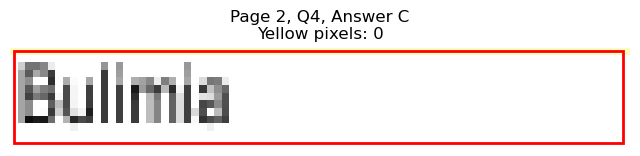

Page 2, Q4 - D: Detected box: x0=336.7, y0=326.1, x1=396.4, y1=338.2
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 325
Page 2, Q4, D: Yellow percentage: 0.0%


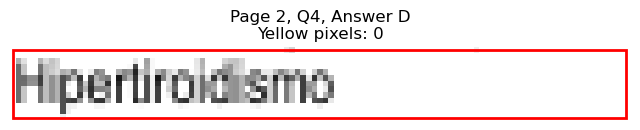

Page 2, Q4 - E: Detected box: x0=336.7, y0=338.1, x1=370.6, y1=350.2
Page 2, Q4, E: Yellow pixels: 0
Page 2, Q4, E: Total non-white pixels: 176
Page 2, Q4, E: Yellow percentage: 0.0%


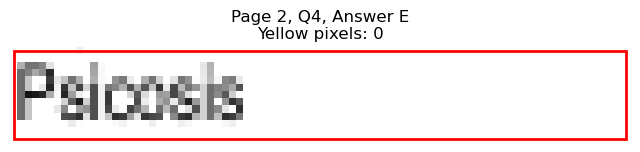


Page 2, Q4 - Selected Answer: B (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=85.0, y0=398.3, x1=205.1, y1=410.4
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 598
Page 2, Q5, A: Yellow percentage: 0.0%


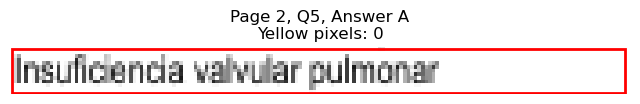

Page 2, Q5 - B: Detected box: x0=85.0, y0=410.4, x1=209.9, y1=422.5
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 647
Page 2, Q5, B: Yellow percentage: 0.0%


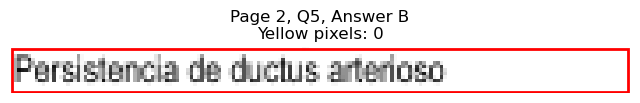

Page 2, Q5 - C: Detected box: x0=85.0, y0=422.4, x1=163.0, y1=434.5
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 397
Page 2, Q5, C: Yellow percentage: 0.0%


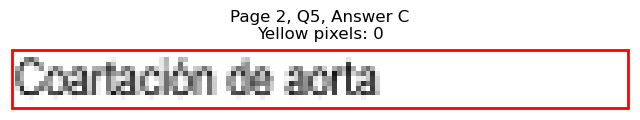

Page 2, Q5 - D: Detected box: x0=336.7, y0=398.3, x1=445.9, y1=410.4
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 531
Page 2, Q5, D: Yellow percentage: 0.0%


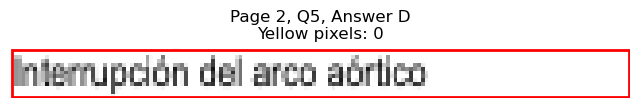

Page 2, Q5 - E: Detected box: x0=336.7, y0=410.4, x1=463.1, y1=422.5
Page 2, Q5, E: Yellow pixels: 1828
Page 2, Q5, E: Total non-white pixels: 2314
Page 2, Q5, E: Yellow percentage: 79.0%


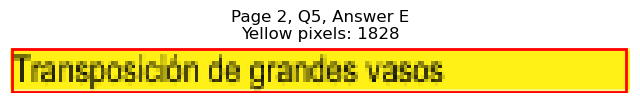


Page 2, Q5 - Selected Answer: E (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=85.0, y0=470.7, x1=200.3, y1=482.8
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 553
Page 2, Q6, A: Yellow percentage: 0.0%


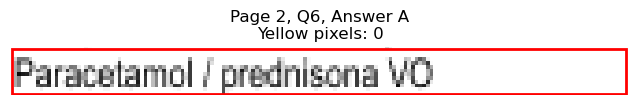

Page 2, Q6 - B: Detected box: x0=85.0, y0=482.7, x1=204.2, y1=494.8
Page 2, Q6, B: Yellow pixels: 0
Page 2, Q6, B: Total non-white pixels: 610
Page 2, Q6, B: Yellow percentage: 0.0%


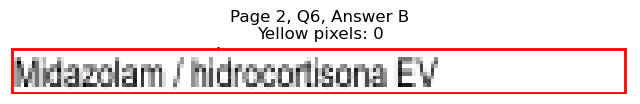

Page 2, Q6 - C: Detected box: x0=85.0, y0=494.7, x1=201.3, y1=506.8
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 561
Page 2, Q6, C: Yellow percentage: 0.0%


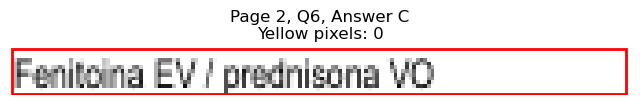

Page 2, Q6 - D: Detected box: x0=336.7, y0=470.7, x1=444.5, y1=482.8
Page 2, Q6, D: Yellow pixels: 1491
Page 2, Q6, D: Total non-white pixels: 2067
Page 2, Q6, D: Yellow percentage: 72.1%


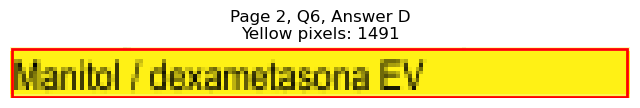

Page 2, Q6 - E: Detected box: x0=336.7, y0=482.7, x1=457.8, y1=494.8
Page 2, Q6, E: Yellow pixels: 172
Page 2, Q6, E: Total non-white pixels: 776
Page 2, Q6, E: Yellow percentage: 22.2%


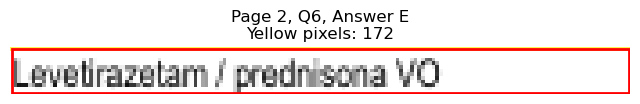


Page 2, Q6 - Selected Answer: D (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=85.0, y0=554.9, x1=128.5, y1=567.0
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 221
Page 2, Q7, A: Yellow percentage: 0.0%


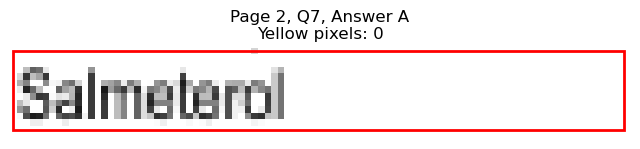

Page 2, Q7 - B: Detected box: x0=85.0, y0=567.1, x1=133.8, y1=579.2
Page 2, Q7, B: Yellow pixels: 100
Page 2, Q7, B: Total non-white pixels: 359
Page 2, Q7, B: Yellow percentage: 27.9%


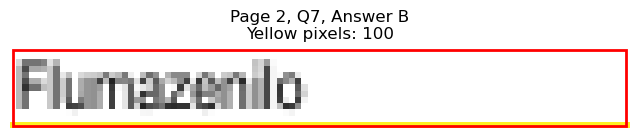

Page 2, Q7 - C: Detected box: x0=85.0, y0=579.1, x1=119.5, y1=591.2
Page 2, Q7, C: Yellow pixels: 893
Page 2, Q7, C: Total non-white pixels: 1118
Page 2, Q7, C: Yellow percentage: 79.9%


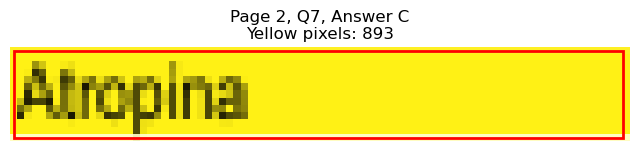

Page 2, Q7 - D: Detected box: x0=336.7, y0=554.9, x1=387.4, y1=567.0
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 269
Page 2, Q7, D: Yellow percentage: 0.0%


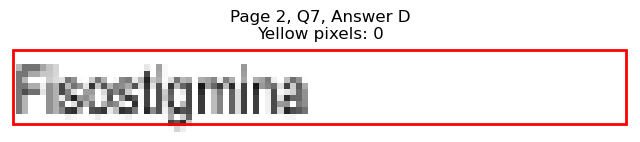

Page 2, Q7 - E: Detected box: x0=336.7, y0=567.1, x1=397.5, y1=579.2
Page 2, Q7, E: Yellow pixels: 0
Page 2, Q7, E: Total non-white pixels: 338
Page 2, Q7, E: Yellow percentage: 0.0%


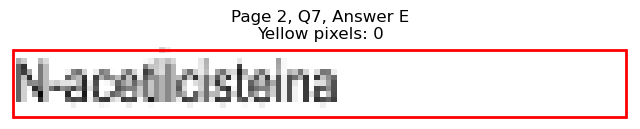


Page 2, Q7 - Selected Answer: C (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=85.0, y0=651.4, x1=267.9, y1=663.5
Page 2, Q8, A: Yellow pixels: 2353
Page 2, Q8, A: Total non-white pixels: 3042
Page 2, Q8, A: Yellow percentage: 77.4%


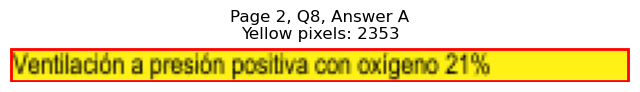

Page 2, Q8 - B: Detected box: x0=85.0, y0=663.4, x1=296.1, y1=675.5
Page 2, Q8, B: Yellow pixels: 263
Page 2, Q8, B: Total non-white pixels: 1343
Page 2, Q8, B: Yellow percentage: 19.6%


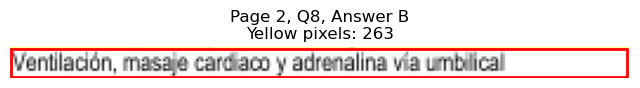

Page 2, Q8 - C: Detected box: x0=85.0, y0=675.4, x1=280.3, y1=687.5
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 983
Page 2, Q8, C: Yellow percentage: 0.0%


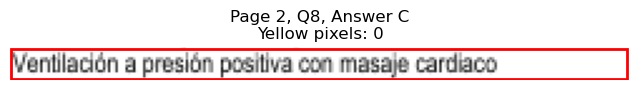

Page 2, Q8 - D: Detected box: x0=85.0, y0=687.5, x1=272.7, y1=699.7
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 937
Page 2, Q8, D: Yellow percentage: 0.0%


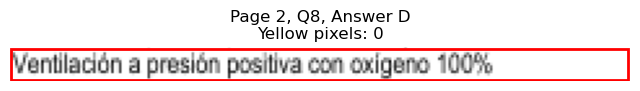

Page 2, Q8 - E: Detected box: x0=85.0, y0=699.5, x1=290.8, y1=711.7
Page 2, Q8, E: Yellow pixels: 0
Page 2, Q8, E: Total non-white pixels: 1036
Page 2, Q8, E: Yellow percentage: 0.0%


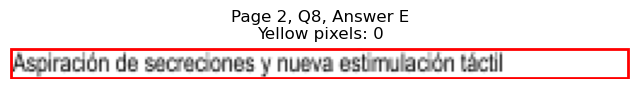


Page 2, Q8 - Selected Answer: A (based on yellow pixel count)





Page 3: Found 9 questions
Page 3, Q1 - A: Detected box: x0=85.0, y0=133.2, x1=171.6, y1=145.3
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 467
Page 3, Q1, A: Yellow percentage: 0.0%


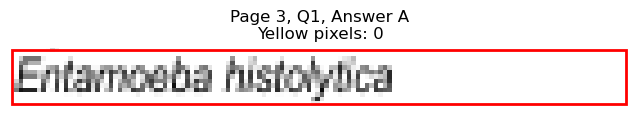

Page 3, Q1 - B: Detected box: x0=85.0, y0=145.3, x1=144.9, y1=157.4
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 320
Page 3, Q1, B: Yellow percentage: 0.0%


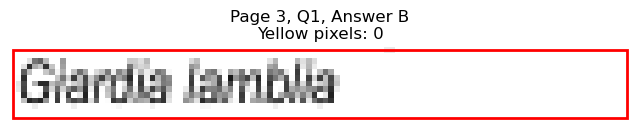

Page 3, Q1 - C: Detected box: x0=85.0, y0=157.3, x1=172.7, y1=169.4
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 454
Page 3, Q1, C: Yellow percentage: 0.0%


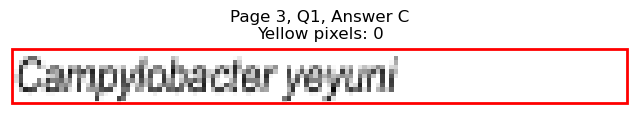

Page 3, Q1 - D: Detected box: x0=336.7, y0=133.2, x1=375.4, y1=145.3
Page 3, Q1, D: Yellow pixels: 907
Page 3, Q1, D: Total non-white pixels: 1170
Page 3, Q1, D: Yellow percentage: 77.5%


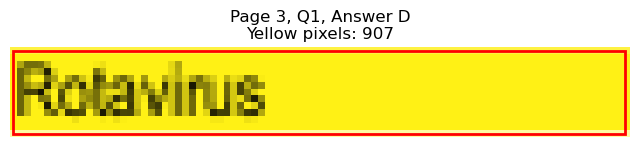

Page 3, Q1 - E: Detected box: x0=336.7, y0=145.3, x1=396.6, y1=157.4
Page 3, Q1, E: Yellow pixels: 0
Page 3, Q1, E: Total non-white pixels: 408
Page 3, Q1, E: Yellow percentage: 0.0%


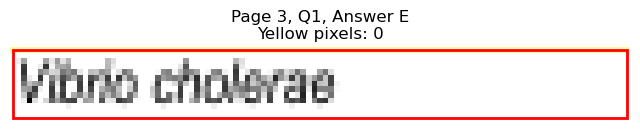


Page 3, Q1 - Selected Answer: D (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=85.0, y0=205.5, x1=132.9, y1=217.7
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 220
Page 3, Q2, A: Yellow percentage: 0.0%


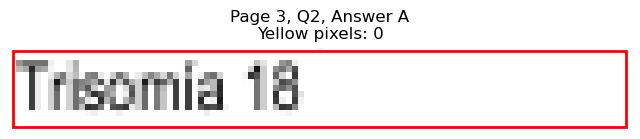

Page 3, Q2 - B: Detected box: x0=85.0, y0=217.5, x1=142.9, y1=229.7
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 271
Page 3, Q2, B: Yellow percentage: 0.0%


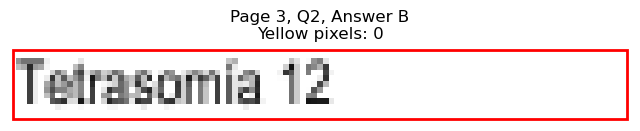

Page 3, Q2 - C: Detected box: x0=85.0, y0=229.7, x1=160.1, y1=241.8
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 391
Page 3, Q2, C: Yellow percentage: 0.0%


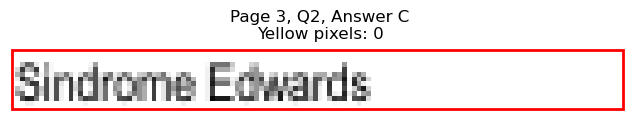

Page 3, Q2 - D: Detected box: x0=336.7, y0=205.5, x1=384.6, y1=217.7
Page 3, Q2, D: Yellow pixels: 99
Page 3, Q2, D: Total non-white pixels: 353
Page 3, Q2, D: Yellow percentage: 28.0%


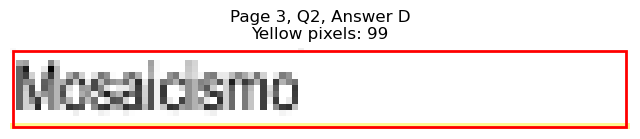

Page 3, Q2 - E: Detected box: x0=336.7, y0=217.5, x1=384.1, y1=229.7
Page 3, Q2, E: Yellow pixels: 1109
Page 3, Q2, E: Total non-white pixels: 1287
Page 3, Q2, E: Yellow percentage: 86.2%


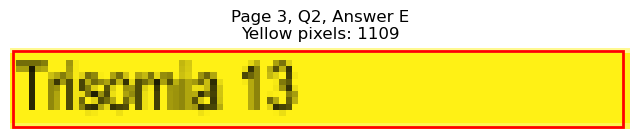


Page 3, Q2 - Selected Answer: E (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=85.0, y0=277.8, x1=167.8, y1=289.9
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 434
Page 3, Q3, A: Yellow percentage: 0.0%


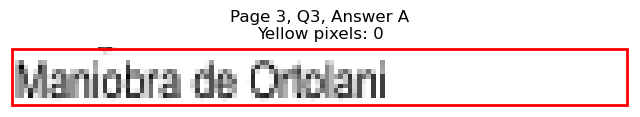

Page 3, Q3 - B: Detected box: x0=85.0, y0=289.9, x1=163.9, y1=302.0
Page 3, Q3, B: Yellow pixels: 1223
Page 3, Q3, B: Total non-white pixels: 1690
Page 3, Q3, B: Yellow percentage: 72.4%


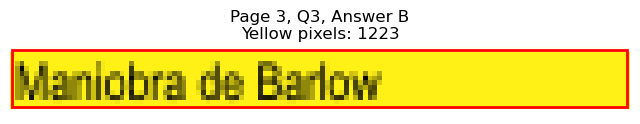

Page 3, Q3 - C: Detected box: x0=85.0, y0=301.9, x1=143.4, y1=314.0
Page 3, Q3, C: Yellow pixels: 110
Page 3, Q3, C: Total non-white pixels: 386
Page 3, Q3, C: Yellow percentage: 28.5%


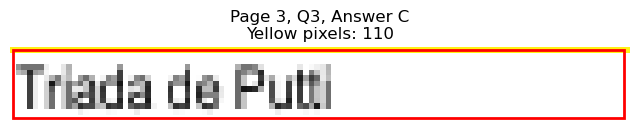

Page 3, Q3 - D: Detected box: x0=336.7, y0=277.8, x1=424.8, y1=289.9
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 465
Page 3, Q3, D: Yellow percentage: 0.0%


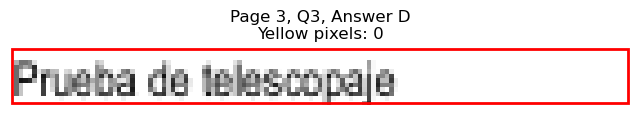

Page 3, Q3 - E: Detected box: x0=336.7, y0=289.9, x1=409.4, y1=302.0
Page 3, Q3, E: Yellow pixels: 0
Page 3, Q3, E: Total non-white pixels: 380
Page 3, Q3, E: Yellow percentage: 0.0%


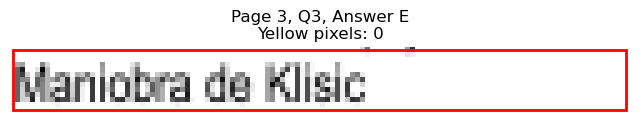


Page 3, Q3 - Selected Answer: B (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=85.0, y0=338.1, x1=225.8, y1=350.2
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 711
Page 3, Q4, A: Yellow percentage: 0.0%


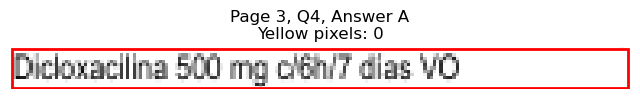

Page 3, Q4 - B: Detected box: x0=85.0, y0=350.2, x1=238.6, y1=362.3
Page 3, Q4, B: Yellow pixels: 190
Page 3, Q4, B: Total non-white pixels: 940
Page 3, Q4, B: Yellow percentage: 20.2%


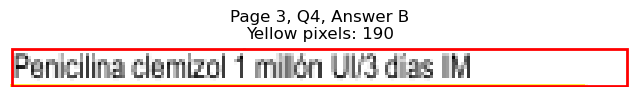

Page 3, Q4 - C: Detected box: x0=85.0, y0=362.2, x1=206.6, y1=374.3
Page 3, Q4, C: Yellow pixels: 1581
Page 3, Q4, C: Total non-white pixels: 2249
Page 3, Q4, C: Yellow percentage: 70.3%


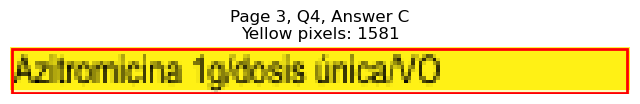

Page 3, Q4 - D: Detected box: x0=336.7, y0=338.1, x1=473.1, y1=350.2
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 664
Page 3, Q4, D: Yellow percentage: 0.0%


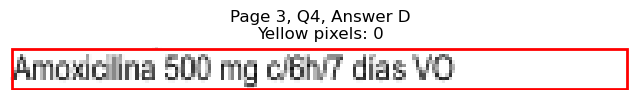

Page 3, Q4 - E: Detected box: x0=336.7, y0=350.2, x1=470.3, y1=362.3
Page 3, Q4, E: Yellow pixels: 0
Page 3, Q4, E: Total non-white pixels: 663
Page 3, Q4, E: Yellow percentage: 0.0%


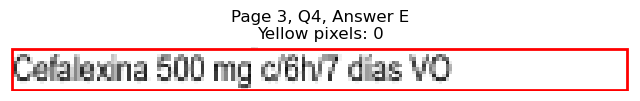


Page 3, Q4 - Selected Answer: C (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=85.0, y0=410.4, x1=144.4, y1=422.5
Page 3, Q5, A: Yellow pixels: 1194
Page 3, Q5, A: Total non-white pixels: 1443
Page 3, Q5, A: Yellow percentage: 82.7%


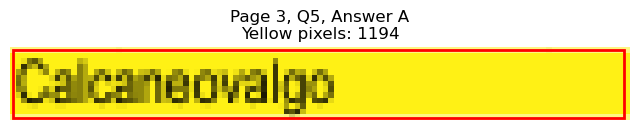

Page 3, Q5 - B: Detected box: x0=85.0, y0=422.4, x1=107.4, y1=434.5
Page 3, Q5, B: Yellow pixels: 74
Page 3, Q5, B: Total non-white pixels: 180
Page 3, Q5, B: Yellow percentage: 41.1%


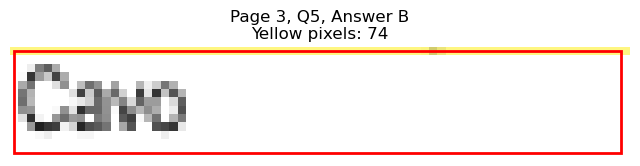

Page 3, Q5 - C: Detected box: x0=85.0, y0=434.4, x1=133.3, y1=446.5
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 224
Page 3, Q5, C: Yellow percentage: 0.0%


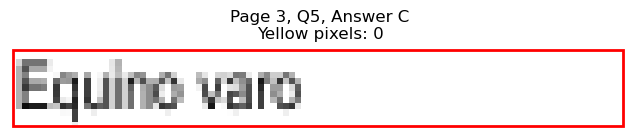

Page 3, Q5 - D: Detected box: x0=336.7, y0=410.4, x1=388.9, y1=422.5
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 272
Page 3, Q5, D: Yellow percentage: 0.0%


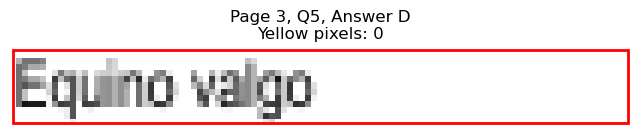

Page 3, Q5 - E: Detected box: x0=336.7, y0=422.4, x1=402.7, y1=434.5
Page 3, Q5, E: Yellow pixels: 0
Page 3, Q5, E: Total non-white pixels: 334
Page 3, Q5, E: Yellow percentage: 0.0%


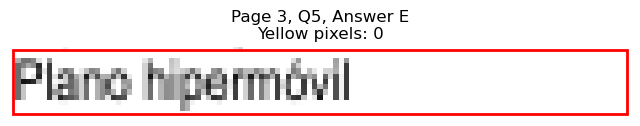


Page 3, Q5 - Selected Answer: A (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=85.0, y0=494.7, x1=196.0, y1=506.8
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 578
Page 3, Q6, A: Yellow percentage: 0.0%


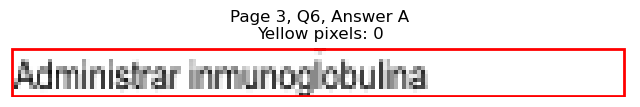

Page 3, Q6 - B: Detected box: x0=85.0, y0=506.8, x1=182.2, y1=518.9
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 666
Page 3, Q6, B: Yellow percentage: 0.0%


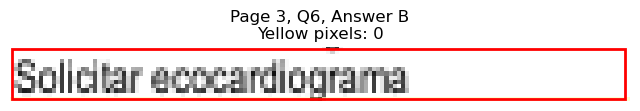

Page 3, Q6 - C: Detected box: x0=85.0, y0=518.8, x1=165.4, y1=530.9
Page 3, Q6, C: Yellow pixels: 1255
Page 3, Q6, C: Total non-white pixels: 1716
Page 3, Q6, C: Yellow percentage: 73.1%


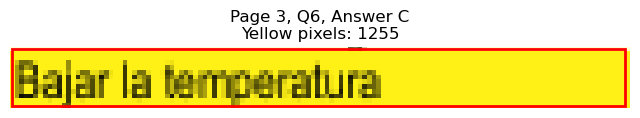

Page 3, Q6 - D: Detected box: x0=336.7, y0=494.7, x1=460.7, y1=506.8
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 655
Page 3, Q6, D: Yellow percentage: 0.0%


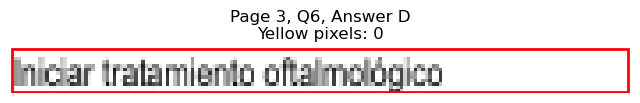

Page 3, Q6 - E: Detected box: x0=336.7, y0=506.8, x1=432.0, y1=518.9
Page 3, Q6, E: Yellow pixels: 0
Page 3, Q6, E: Total non-white pixels: 521
Page 3, Q6, E: Yellow percentage: 0.0%


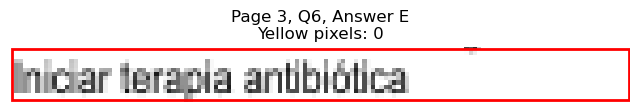


Page 3, Q6 - Selected Answer: C (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=85.0, y0=579.1, x1=245.3, y1=591.2
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 813
Page 3, Q7, A: Yellow percentage: 0.0%


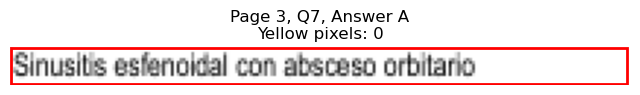

Page 3, Q7 - B: Detected box: x0=85.0, y0=591.2, x1=212.8, y1=603.3
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 659
Page 3, Q7, B: Yellow percentage: 0.0%


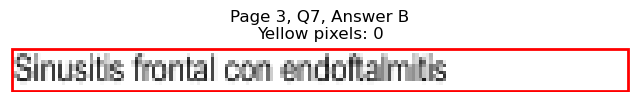

Page 3, Q7 - C: Detected box: x0=85.0, y0=603.2, x1=248.2, y1=615.3
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 812
Page 3, Q7, C: Yellow percentage: 0.0%


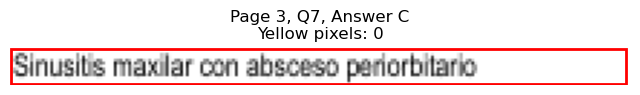

Page 3, Q7 - D: Detected box: x0=336.7, y0=579.1, x1=479.9, y1=591.2
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 754
Page 3, Q7, D: Yellow percentage: 0.0%


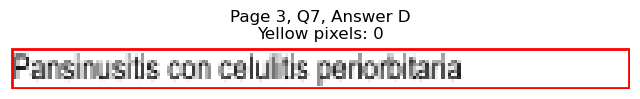

Page 3, Q7 - E: Detected box: x0=336.7, y0=591.2, x1=471.2, y1=603.3
Page 3, Q7, E: Yellow pixels: 1696
Page 3, Q7, E: Total non-white pixels: 2418
Page 3, Q7, E: Yellow percentage: 70.1%


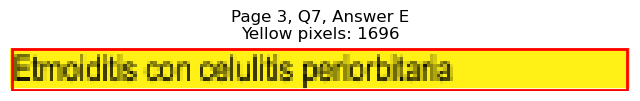


Page 3, Q7 - Selected Answer: E (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=85.0, y0=675.4, x1=185.5, y1=687.5
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 533
Page 3, Q8, A: Yellow percentage: 0.0%


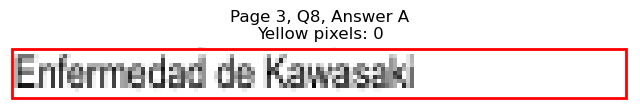

Page 3, Q8 - B: Detected box: x0=85.0, y0=687.5, x1=202.7, y1=699.7
Page 3, Q8, B: Yellow pixels: 1707
Page 3, Q8, B: Total non-white pixels: 2197
Page 3, Q8, B: Yellow percentage: 77.7%


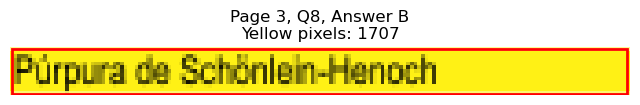

Page 3, Q8 - C: Detected box: x0=85.0, y0=699.5, x1=179.8, y1=711.7
Page 3, Q8, C: Yellow pixels: 146
Page 3, Q8, C: Total non-white pixels: 629
Page 3, Q8, C: Yellow percentage: 23.2%


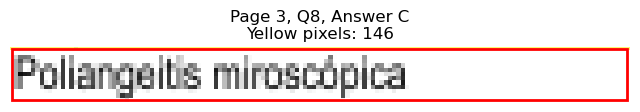

Page 3, Q8 - D: Detected box: x0=336.7, y0=675.4, x1=445.4, y1=687.5
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 568
Page 3, Q8, D: Yellow percentage: 0.0%


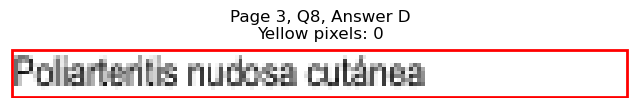

Page 3, Q8 - E: Detected box: x0=336.7, y0=687.5, x1=467.4, y1=699.7
Page 3, Q8, E: Yellow pixels: 0
Page 3, Q8, E: Total non-white pixels: 650
Page 3, Q8, E: Yellow percentage: 0.0%


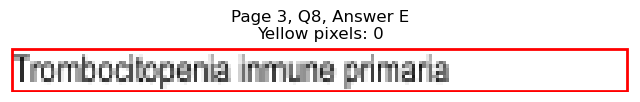


Page 3, Q8 - Selected Answer: B (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=85.0, y0=735.8, x1=93.6, y1=747.9
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 97
Page 3, Q9, A: Yellow percentage: 0.0%


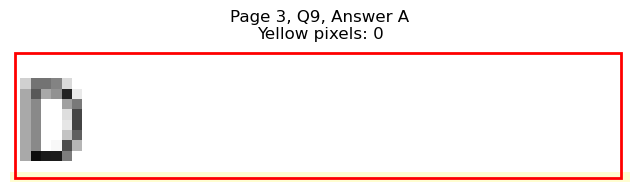

Page 3, Q9 - B: Detected box: x0=70.8, y0=747.8, x1=79.0, y1=759.9
Page 3, Q9, B: Yellow pixels: 648
Page 3, Q9, B: Total non-white pixels: 767
Page 3, Q9, B: Yellow percentage: 84.5%


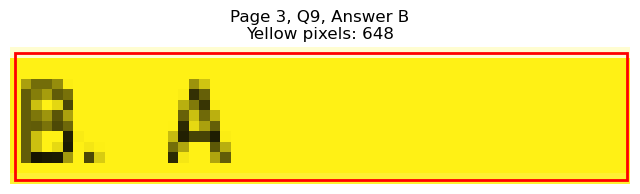

Page 3, Q9 - C: Detected box: x0=70.8, y0=759.8, x1=79.5, y1=771.9
Page 3, Q9, C: Yellow pixels: 60
Page 3, Q9, C: Total non-white pixels: 128
Page 3, Q9, C: Yellow percentage: 46.9%


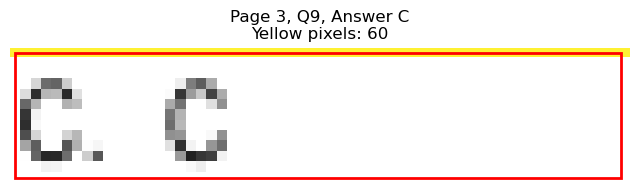

Page 3, Q9 - D: Detected box: x0=336.7, y0=735.8, x1=349.6, y1=747.9
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 53
Page 3, Q9, D: Yellow percentage: 0.0%


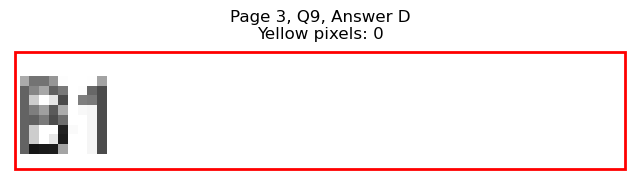

Page 3, Q9 - E: Detected box: x0=336.7, y0=747.8, x1=347.2, y1=759.9
Page 3, Q9, E: Yellow pixels: 0
Page 3, Q9, E: Total non-white pixels: 68
Page 3, Q9, E: Yellow percentage: 0.0%


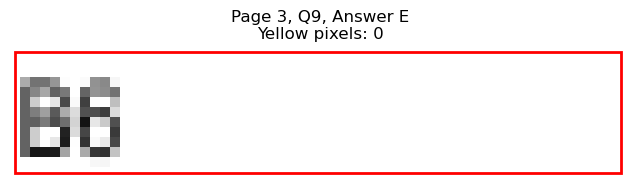


Page 3, Q9 - Selected Answer: B (based on yellow pixel count)





Page 4: Found 9 questions
Page 4, Q1 - A: Detected box: x0=85.0, y0=121.2, x1=110.8, y1=133.3
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 130
Page 4, Q1, A: Yellow percentage: 0.0%


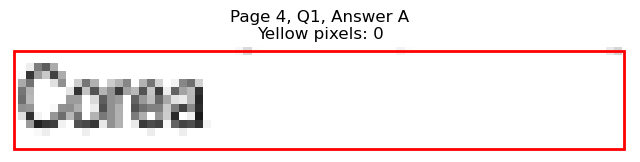

Page 4, Q1 - B: Detected box: x0=85.0, y0=133.2, x1=191.8, y1=145.3
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 533
Page 4, Q1, B: Yellow percentage: 0.0%


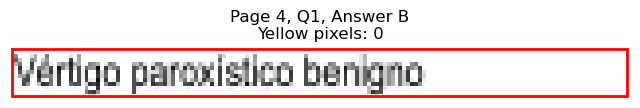

Page 4, Q1 - C: Detected box: x0=85.0, y0=145.3, x1=118.9, y1=157.4
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 183
Page 4, Q1, C: Yellow percentage: 0.0%


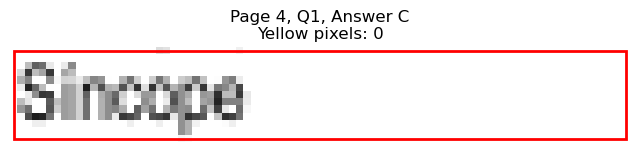

Page 4, Q1 - D: Detected box: x0=336.7, y0=121.2, x1=467.9, y1=133.3
Page 4, Q1, D: Yellow pixels: 182
Page 4, Q1, D: Total non-white pixels: 820
Page 4, Q1, D: Yellow percentage: 22.2%


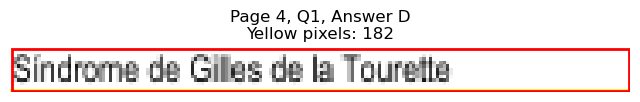

Page 4, Q1 - E: Detected box: x0=336.7, y0=133.2, x1=409.4, y1=145.3
Page 4, Q1, E: Yellow pixels: 1210
Page 4, Q1, E: Total non-white pixels: 1612
Page 4, Q1, E: Yellow percentage: 75.1%


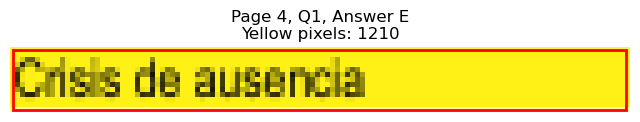


Page 4, Q1 - Selected Answer: E (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=85.0, y0=181.4, x1=233.8, y1=193.5
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 743
Page 4, Q2, A: Yellow percentage: 0.0%


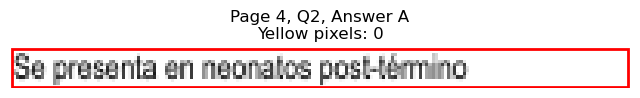

Page 4, Q2 - B: Detected box: x0=85.0, y0=193.4, x1=261.7, y1=205.5
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 873
Page 4, Q2, B: Yellow percentage: 0.0%


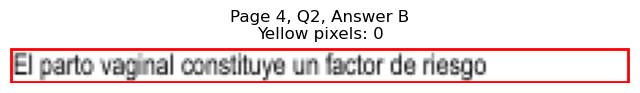

Page 4, Q2 - C: Detected box: x0=85.0, y0=205.5, x1=244.4, y1=217.7
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 799
Page 4, Q2, C: Yellow percentage: 0.0%


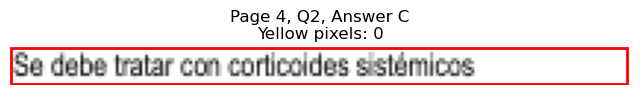

Page 4, Q2 - D: Detected box: x0=336.7, y0=181.4, x1=526.9, y1=193.5
Page 4, Q2, D: Yellow pixels: 1748
Page 4, Q2, D: Total non-white pixels: 2470
Page 4, Q2, D: Yellow percentage: 70.8%


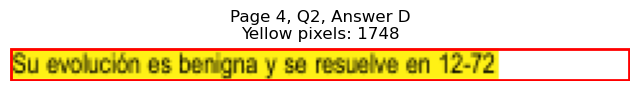

Page 4, Q2 - E: Detected box: x0=336.7, y0=205.5, x1=494.1, y1=217.7
Page 4, Q2, E: Yellow pixels: 190
Page 4, Q2, E: Total non-white pixels: 967
Page 4, Q2, E: Yellow percentage: 19.6%


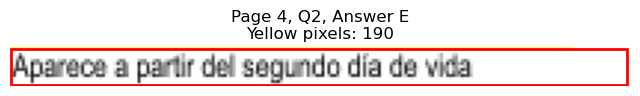


Page 4, Q2 - Selected Answer: D (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=85.0, y0=265.8, x1=175.9, y1=277.9
Page 4, Q3, A: Yellow pixels: 1339
Page 4, Q3, A: Total non-white pixels: 1846
Page 4, Q3, A: Yellow percentage: 72.5%


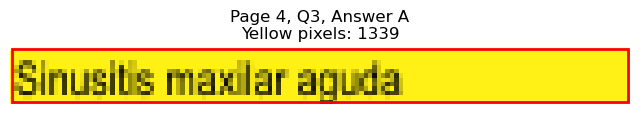

Page 4, Q3 - B: Detected box: x0=85.0, y0=277.8, x1=172.1, y1=289.9
Page 4, Q3, B: Yellow pixels: 135
Page 4, Q3, B: Total non-white pixels: 578
Page 4, Q3, B: Yellow percentage: 23.4%


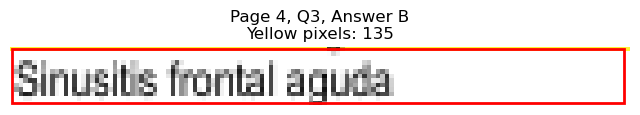

Page 4, Q3 - C: Detected box: x0=85.0, y0=289.9, x1=155.9, y1=302.0
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 380
Page 4, Q3, C: Yellow percentage: 0.0%


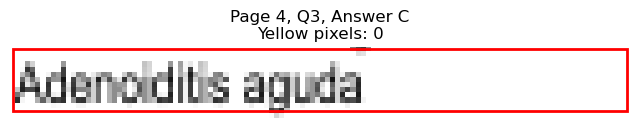

Page 4, Q3 - D: Detected box: x0=336.7, y0=265.8, x1=385.0, y1=277.9
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 278
Page 4, Q3, D: Yellow percentage: 0.0%


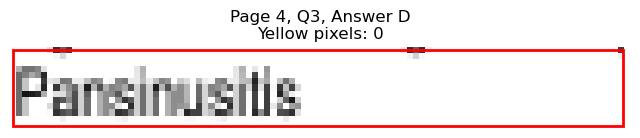

Page 4, Q3 - E: Detected box: x0=336.7, y0=277.8, x1=388.9, y1=289.9
Page 4, Q3, E: Yellow pixels: 0
Page 4, Q3, E: Total non-white pixels: 290
Page 4, Q3, E: Yellow percentage: 0.0%


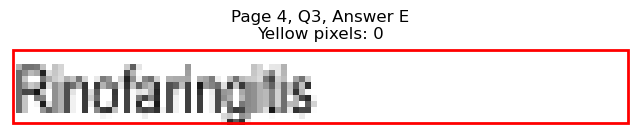


Page 4, Q3 - Selected Answer: A (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=85.0, y0=374.2, x1=150.5, y1=386.3
Page 4, Q4, A: Yellow pixels: 1129
Page 4, Q4, A: Total non-white pixels: 1521
Page 4, Q4, A: Yellow percentage: 74.2%


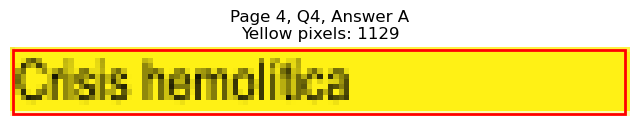

Page 4, Q4 - B: Detected box: x0=85.0, y0=386.3, x1=142.0, y1=398.4
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 433
Page 4, Q4, B: Yellow percentage: 0.0%


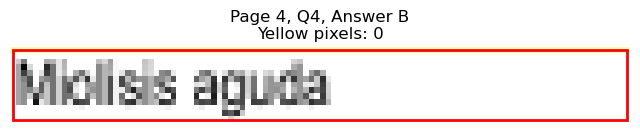

Page 4, Q4 - C: Detected box: x0=85.0, y0=398.3, x1=123.7, y1=410.4
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 212
Page 4, Q4, C: Yellow percentage: 0.0%


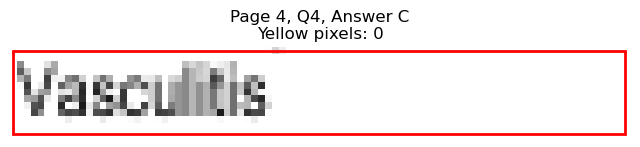

Page 4, Q4 - D: Detected box: x0=336.7, y0=374.2, x1=392.2, y1=386.3
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 293
Page 4, Q4, D: Yellow percentage: 0.0%


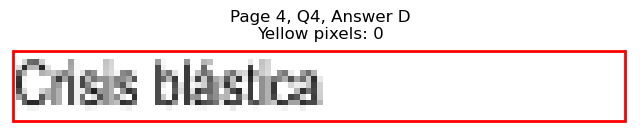

Page 4, Q4 - E: Detected box: x0=336.7, y0=386.3, x1=438.2, y1=398.4
Page 4, Q4, E: Yellow pixels: 0
Page 4, Q4, E: Total non-white pixels: 545
Page 4, Q4, E: Yellow percentage: 0.0%


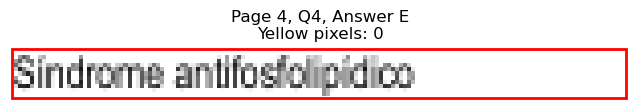


Page 4, Q4 - Selected Answer: A (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=85.0, y0=434.4, x1=145.8, y1=446.5
Page 4, Q5, A: Yellow pixels: 1173
Page 4, Q5, A: Total non-white pixels: 1456
Page 4, Q5, A: Yellow percentage: 80.6%


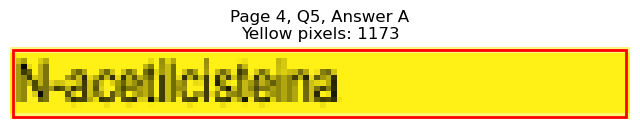

Page 4, Q5 - B: Detected box: x0=85.0, y0=446.6, x1=151.1, y1=458.7
Page 4, Q5, B: Yellow pixels: 118
Page 4, Q5, B: Total non-white pixels: 437
Page 4, Q5, B: Yellow percentage: 27.0%


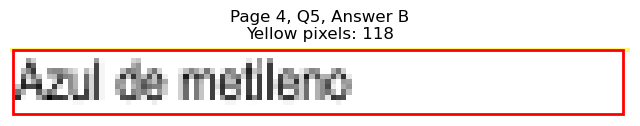

Page 4, Q5 - C: Detected box: x0=85.0, y0=458.6, x1=133.8, y1=470.7
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 259
Page 4, Q5, C: Yellow percentage: 0.0%


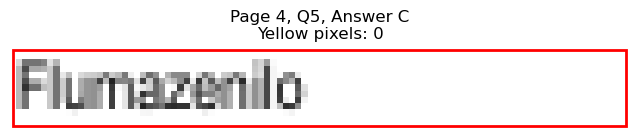

Page 4, Q5 - D: Detected box: x0=336.7, y0=434.4, x1=375.4, y1=446.5
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 196
Page 4, Q5, D: Yellow percentage: 0.0%


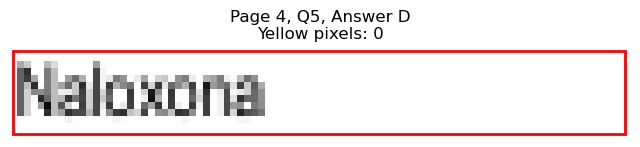

Page 4, Q5 - E: Detected box: x0=336.7, y0=446.6, x1=391.8, y1=458.7
Page 4, Q5, E: Yellow pixels: 0
Page 4, Q5, E: Total non-white pixels: 288
Page 4, Q5, E: Yellow percentage: 0.0%


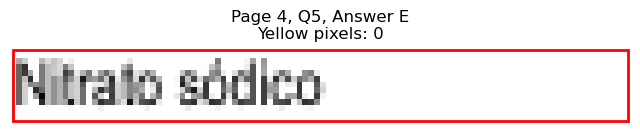


Page 4, Q5 - Selected Answer: A (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=85.0, y0=494.7, x1=128.1, y1=506.8
Page 4, Q6, A: Yellow pixels: 988
Page 4, Q6, A: Total non-white pixels: 1235
Page 4, Q6, A: Yellow percentage: 80.0%


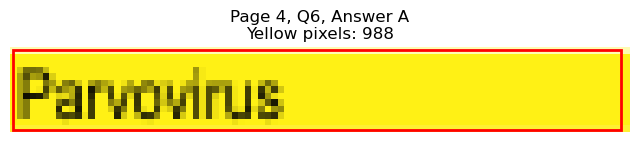

Page 4, Q6 - B: Detected box: x0=85.0, y0=506.8, x1=135.7, y1=518.9
Page 4, Q6, B: Yellow pixels: 102
Page 4, Q6, B: Total non-white pixels: 342
Page 4, Q6, B: Yellow percentage: 29.8%


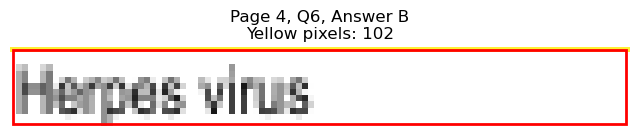

Page 4, Q6 - C: Detected box: x0=85.0, y0=518.8, x1=124.7, y1=530.9
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 178
Page 4, Q6, C: Yellow percentage: 0.0%


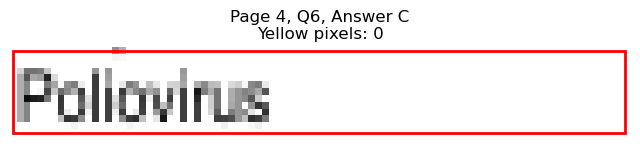

Page 4, Q6 - D: Detected box: x0=336.7, y0=494.7, x1=378.8, y1=506.8
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 235
Page 4, Q6, D: Yellow percentage: 0.0%


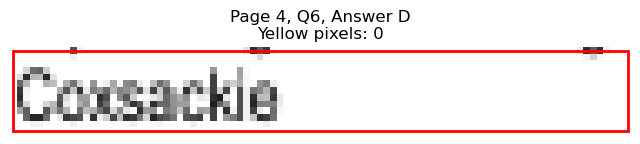

Page 4, Q6 - E: Detected box: x0=336.7, y0=506.8, x1=376.9, y1=518.9
Page 4, Q6, E: Yellow pixels: 0
Page 4, Q6, E: Total non-white pixels: 190
Page 4, Q6, E: Yellow percentage: 0.0%


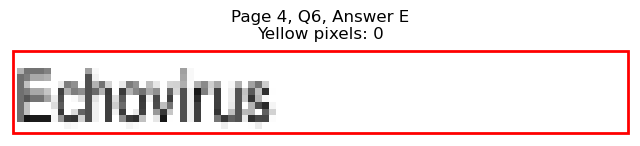


Page 4, Q6 - Selected Answer: A (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=85.0, y0=554.9, x1=152.4, y1=567.0
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 347
Page 4, Q7, A: Yellow percentage: 0.0%


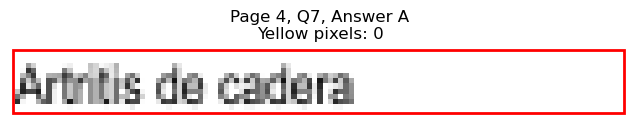

Page 4, Q7 - B: Detected box: x0=85.0, y0=567.1, x1=249.7, y1=579.2
Page 4, Q7, B: Yellow pixels: 1582
Page 4, Q7, B: Total non-white pixels: 2483
Page 4, Q7, B: Yellow percentage: 63.7%


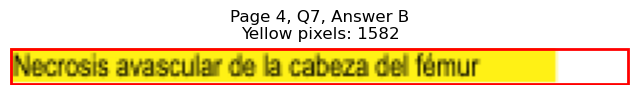

Page 4, Q7 - C: Detected box: x0=85.0, y0=579.1, x1=244.9, y1=591.2
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 977
Page 4, Q7, C: Yellow percentage: 0.0%


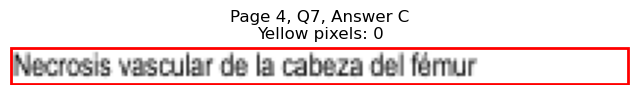

Page 4, Q7 - D: Detected box: x0=336.7, y0=554.9, x1=509.5, y1=567.0
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 839
Page 4, Q7, D: Yellow percentage: 0.0%


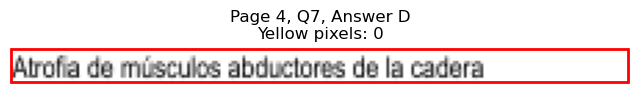

Page 4, Q7 - E: Detected box: x0=336.7, y0=567.1, x1=506.1, y1=579.2
Page 4, Q7, E: Yellow pixels: 0
Page 4, Q7, E: Total non-white pixels: 828
Page 4, Q7, E: Yellow percentage: 0.0%


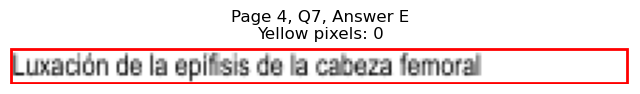


Page 4, Q7 - Selected Answer: B (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=85.0, y0=627.3, x1=184.6, y1=639.4
Page 4, Q8, A: Yellow pixels: 151
Page 4, Q8, A: Total non-white pixels: 675
Page 4, Q8, A: Yellow percentage: 22.4%


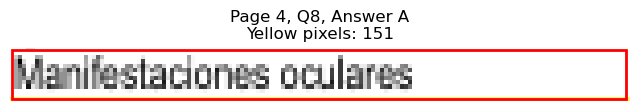

Page 4, Q8 - B: Detected box: x0=85.0, y0=639.3, x1=204.2, y1=651.4
Page 4, Q8, B: Yellow pixels: 1681
Page 4, Q8, B: Total non-white pixels: 2223
Page 4, Q8, B: Yellow percentage: 75.6%


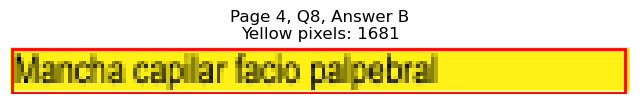

Page 4, Q8 - C: Detected box: x0=85.0, y0=651.4, x1=118.5, y1=663.5
Page 4, Q8, C: Yellow pixels: 85
Page 4, Q8, C: Total non-white pixels: 277
Page 4, Q8, C: Yellow percentage: 30.7%


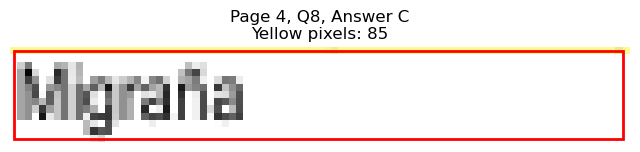

Page 4, Q8 - D: Detected box: x0=336.7, y0=627.3, x1=390.8, y1=639.4
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 264
Page 4, Q8, D: Yellow percentage: 0.0%


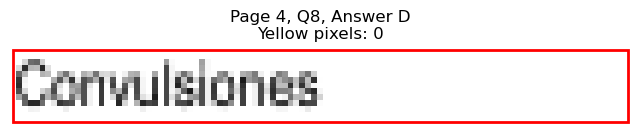

Page 4, Q8 - E: Detected box: x0=336.7, y0=639.3, x1=423.3, y1=651.4
Page 4, Q8, E: Yellow pixels: 0
Page 4, Q8, E: Total non-white pixels: 458
Page 4, Q8, E: Yellow percentage: 0.0%


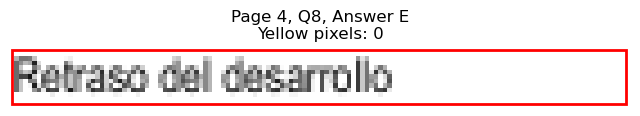


Page 4, Q8 - Selected Answer: B (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=85.0, y0=699.5, x1=165.9, y1=711.7
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 434
Page 4, Q9, A: Yellow percentage: 0.0%


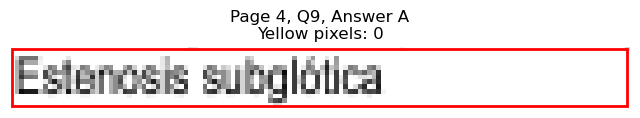

Page 4, Q9 - B: Detected box: x0=85.0, y0=711.7, x1=146.8, y1=723.8
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 310
Page 4, Q9, B: Yellow percentage: 0.0%


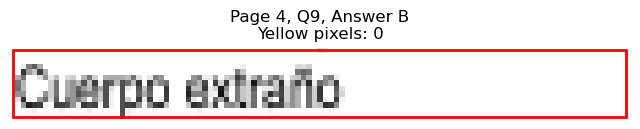

Page 4, Q9 - C: Detected box: x0=85.0, y0=723.7, x1=174.5, y1=735.8
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 478
Page 4, Q9, C: Yellow percentage: 0.0%


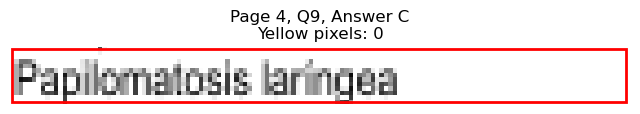

Page 4, Q9 - D: Detected box: x0=336.7, y0=699.5, x1=413.7, y1=711.7
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 416
Page 4, Q9, D: Yellow percentage: 0.0%


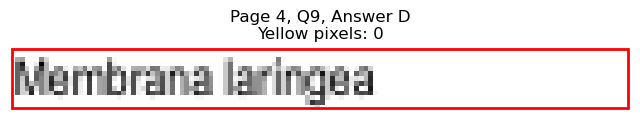

Page 4, Q9 - E: Detected box: x0=336.7, y0=711.7, x1=395.3, y1=723.8
Page 4, Q9, E: Yellow pixels: 1071
Page 4, Q9, E: Total non-white pixels: 1430
Page 4, Q9, E: Yellow percentage: 74.9%


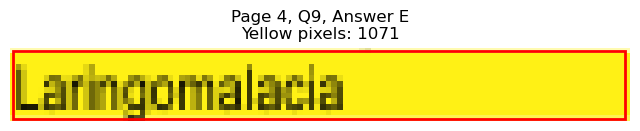


Page 4, Q9 - Selected Answer: E (based on yellow pixel count)





Page 5: Found 9 questions
Page 5, Q1 - A: Detected box: x0=85.0, y0=109.2, x1=136.7, y1=121.3
Page 5, Q1, A: Yellow pixels: 103
Page 5, Q1, A: Total non-white pixels: 370
Page 5, Q1, A: Yellow percentage: 27.8%


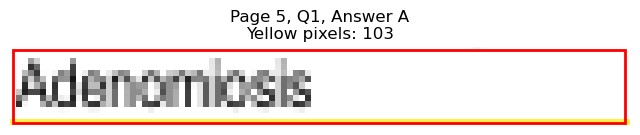

Page 5, Q1 - B: Detected box: x0=85.0, y0=121.2, x1=170.2, y1=133.3
Page 5, Q1, B: Yellow pixels: 1286
Page 5, Q1, B: Total non-white pixels: 1781
Page 5, Q1, B: Yellow percentage: 72.2%


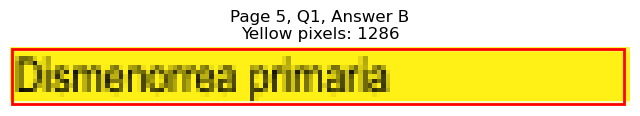

Page 5, Q1 - C: Detected box: x0=85.0, y0=133.2, x1=142.0, y1=145.3
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 393
Page 5, Q1, C: Yellow percentage: 0.0%


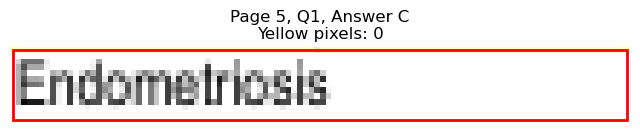

Page 5, Q1 - D: Detected box: x0=336.7, y0=109.2, x1=392.4, y1=121.3
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 304
Page 5, Q1, D: Yellow percentage: 0.0%


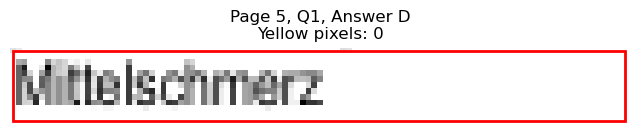

Page 5, Q1 - E: Detected box: x0=336.7, y0=121.2, x1=432.9, y1=133.3
Page 5, Q1, E: Yellow pixels: 0
Page 5, Q1, E: Total non-white pixels: 490
Page 5, Q1, E: Yellow percentage: 0.0%


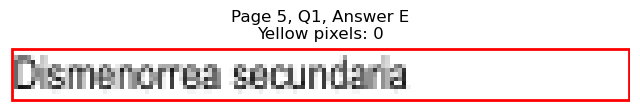


Page 5, Q1 - Selected Answer: B (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=85.0, y0=169.4, x1=160.1, y1=181.5
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 374
Page 5, Q2, A: Yellow percentage: 0.0%


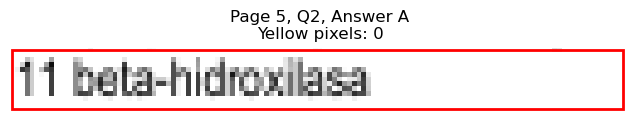

Page 5, Q2 - B: Detected box: x0=85.0, y0=181.4, x1=238.6, y1=193.5
Page 5, Q2, B: Yellow pixels: 190
Page 5, Q2, B: Total non-white pixels: 1001
Page 5, Q2, B: Yellow percentage: 19.0%


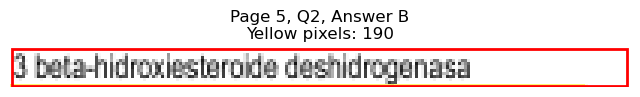

Page 5, Q2 - C: Detected box: x0=85.0, y0=193.4, x1=141.0, y1=205.5
Page 5, Q2, C: Yellow pixels: 1172
Page 5, Q2, C: Total non-white pixels: 1404
Page 5, Q2, C: Yellow percentage: 83.5%


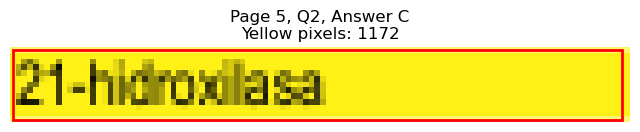

Page 5, Q2 - D: Detected box: x0=336.7, y0=169.4, x1=408.9, y1=181.5
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 350
Page 5, Q2, D: Yellow percentage: 0.0%


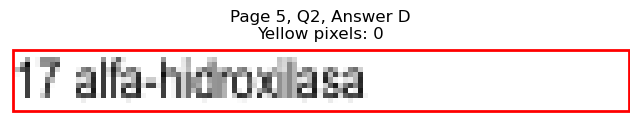

Page 5, Q2 - E: Detected box: x0=336.7, y0=181.4, x1=425.2, y1=193.5
Page 5, Q2, E: Yellow pixels: 0
Page 5, Q2, E: Total non-white pixels: 459
Page 5, Q2, E: Yellow percentage: 0.0%


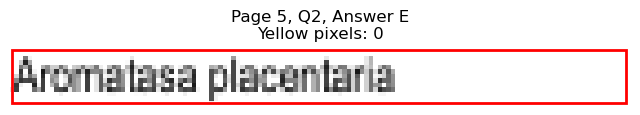


Page 5, Q2 - Selected Answer: C (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=85.0, y0=229.7, x1=142.5, y1=241.8
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 289
Page 5, Q3, A: Yellow percentage: 0.0%


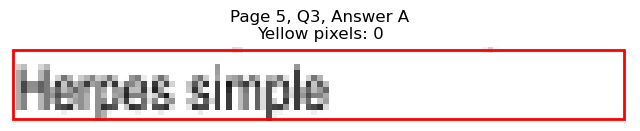

Page 5, Q3 - B: Detected box: x0=85.0, y0=241.7, x1=145.8, y1=253.8
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 299
Page 5, Q3, B: Yellow percentage: 0.0%


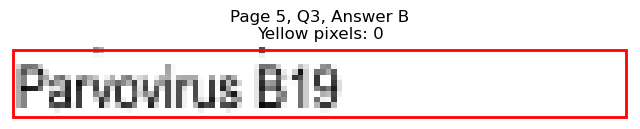

Page 5, Q3 - C: Detected box: x0=85.0, y0=253.7, x1=123.3, y1=265.8
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 195
Page 5, Q3, C: Yellow percentage: 0.0%


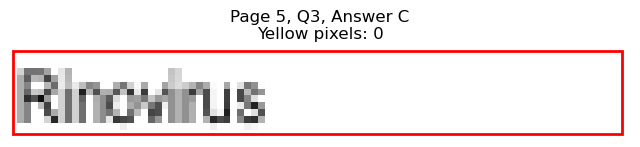

Page 5, Q3 - D: Detected box: x0=336.7, y0=229.7, x1=396.6, y1=241.8
Page 5, Q3, D: Yellow pixels: 1106
Page 5, Q3, D: Total non-white pixels: 1443
Page 5, Q3, D: Yellow percentage: 76.6%


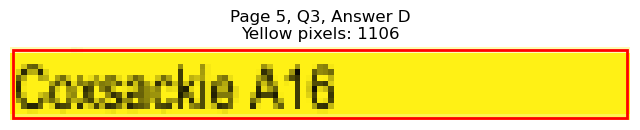

Page 5, Q3 - E: Detected box: x0=336.7, y0=241.7, x1=410.4, y1=253.8
Page 5, Q3, E: Yellow pixels: 125
Page 5, Q3, E: Total non-white pixels: 470
Page 5, Q3, E: Yellow percentage: 26.6%


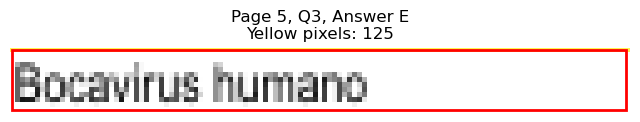


Page 5, Q3 - Selected Answer: D (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=85.0, y0=326.1, x1=113.7, y1=338.2
Page 5, Q4, A: Yellow pixels: 845
Page 5, Q4, A: Total non-white pixels: 1040
Page 5, Q4, A: Yellow percentage: 81.2%


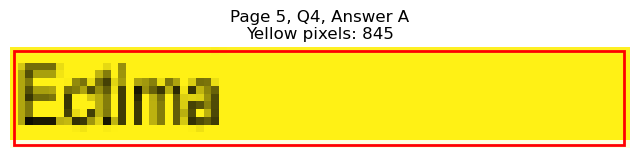

Page 5, Q4 - B: Detected box: x0=85.0, y0=338.1, x1=149.1, y1=350.2
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 451
Page 5, Q4, B: Yellow percentage: 0.0%


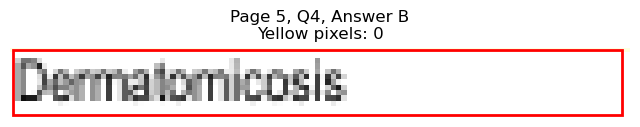

Page 5, Q4 - C: Detected box: x0=85.0, y0=350.2, x1=124.7, y1=362.3
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 195
Page 5, Q4, C: Yellow percentage: 0.0%


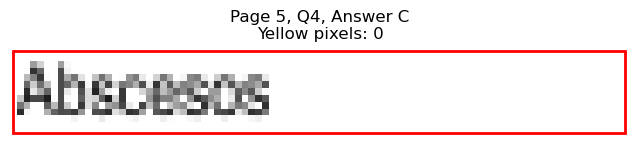

Page 5, Q4 - D: Detected box: x0=336.7, y0=326.1, x1=375.9, y1=338.2
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 194
Page 5, Q4, D: Yellow percentage: 0.0%


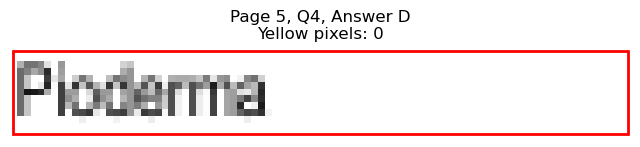

Page 5, Q4 - E: Detected box: x0=336.7, y0=338.1, x1=374.5, y1=350.2
Page 5, Q4, E: Yellow pixels: 0
Page 5, Q4, E: Total non-white pixels: 209
Page 5, Q4, E: Yellow percentage: 0.0%


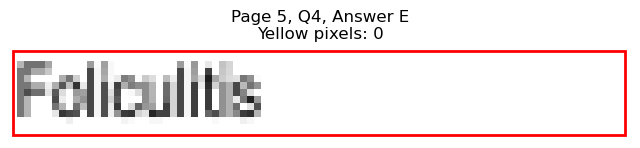


Page 5, Q4 - Selected Answer: A (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=85.0, y0=398.3, x1=101.8, y1=410.4
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 78
Page 5, Q5, A: Yellow percentage: 0.0%


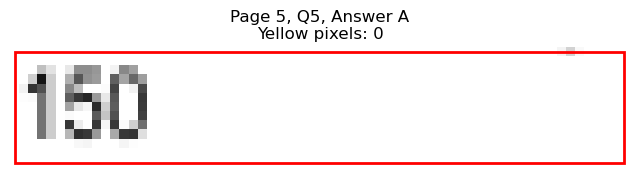

Page 5, Q5 - B: Detected box: x0=85.0, y0=410.4, x1=97.0, y1=422.5
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 56
Page 5, Q5, B: Yellow percentage: 0.0%


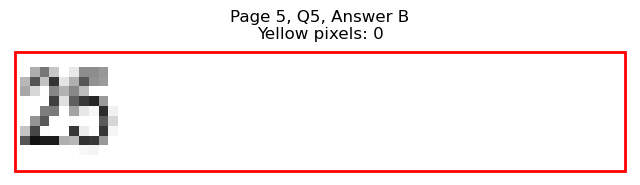

Page 5, Q5 - C: Detected box: x0=85.0, y0=422.4, x1=97.0, y1=434.5
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 58
Page 5, Q5, C: Yellow percentage: 0.0%


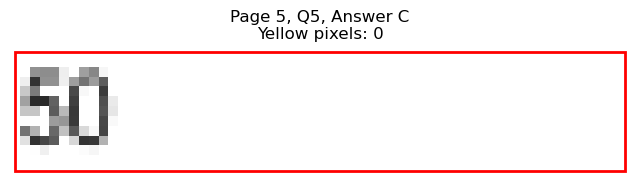

Page 5, Q5 - D: Detected box: x0=336.7, y0=398.3, x1=353.5, y1=410.4
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 84
Page 5, Q5, D: Yellow percentage: 0.0%


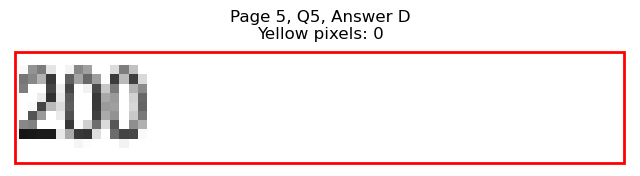

Page 5, Q5 - E: Detected box: x0=336.7, y0=410.4, x1=348.7, y1=422.5
Page 5, Q5, E: Yellow pixels: 780
Page 5, Q5, E: Total non-white pixels: 819
Page 5, Q5, E: Yellow percentage: 95.2%


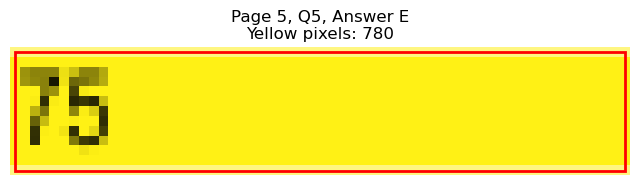


Page 5, Q5 - Selected Answer: E (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=85.0, y0=470.7, x1=132.9, y1=482.8
Page 5, Q6, A: Yellow pixels: 1006
Page 5, Q6, A: Total non-white pixels: 1287
Page 5, Q6, A: Yellow percentage: 78.2%


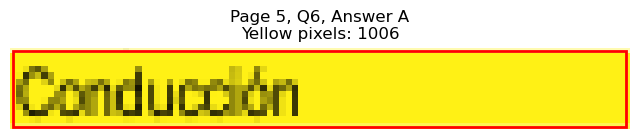

Page 5, Q6 - B: Detected box: x0=85.0, y0=482.7, x1=135.3, y1=494.8
Page 5, Q6, B: Yellow pixels: 102
Page 5, Q6, B: Total non-white pixels: 352
Page 5, Q6, B: Yellow percentage: 29.0%


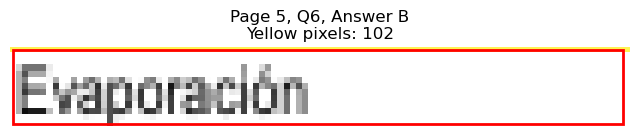

Page 5, Q6 - C: Detected box: x0=85.0, y0=494.7, x1=139.6, y1=506.8
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 288
Page 5, Q6, C: Yellow percentage: 0.0%


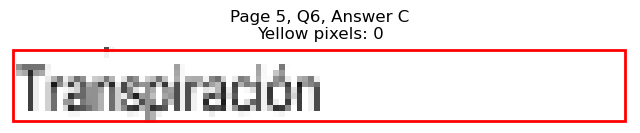

Page 5, Q6 - D: Detected box: x0=336.7, y0=470.7, x1=384.1, y1=482.8
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 231
Page 5, Q6, D: Yellow percentage: 0.0%


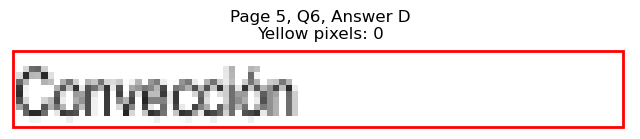

Page 5, Q6 - E: Detected box: x0=336.7, y0=482.7, x1=377.4, y1=494.8
Page 5, Q6, E: Yellow pixels: 0
Page 5, Q6, E: Total non-white pixels: 206
Page 5, Q6, E: Yellow percentage: 0.0%


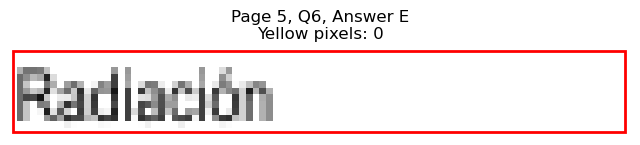


Page 5, Q6 - Selected Answer: A (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=85.0, y0=542.9, x1=145.3, y1=555.0
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 330
Page 5, Q7, A: Yellow percentage: 0.0%


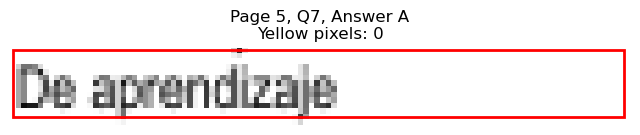

Page 5, Q7 - B: Detected box: x0=85.0, y0=554.9, x1=166.3, y1=567.0
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 396
Page 5, Q7, B: Yellow percentage: 0.0%


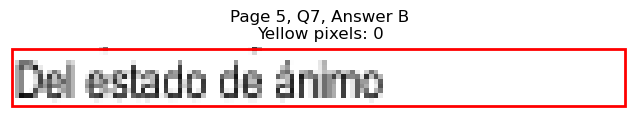

Page 5, Q7 - C: Detected box: x0=85.0, y0=567.1, x1=170.2, y1=579.2
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 431
Page 5, Q7, C: Yellow percentage: 0.0%


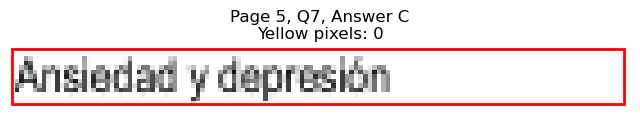

Page 5, Q7 - D: Detected box: x0=336.7, y0=542.9, x1=431.0, y1=555.0
Page 5, Q7, D: Yellow pixels: 1340
Page 5, Q7, D: Total non-white pixels: 1887
Page 5, Q7, D: Yellow percentage: 71.0%


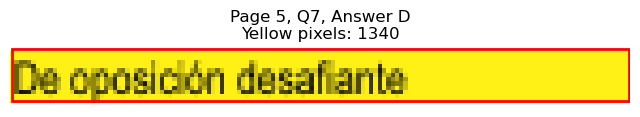

Page 5, Q7 - E: Detected box: x0=336.7, y0=554.9, x1=387.4, y1=567.0
Page 5, Q7, E: Yellow pixels: 100
Page 5, Q7, E: Total non-white pixels: 351
Page 5, Q7, E: Yellow percentage: 28.5%


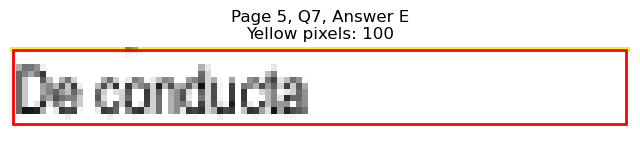


Page 5, Q7 - Selected Answer: D (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=85.0, y0=615.2, x1=144.4, y1=627.3
Page 5, Q8, A: Yellow pixels: 1068
Page 5, Q8, A: Total non-white pixels: 1443
Page 5, Q8, A: Yellow percentage: 74.0%


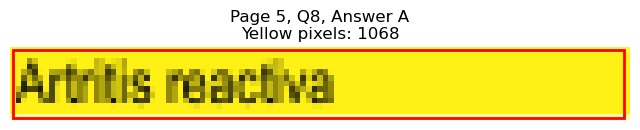

Page 5, Q8 - B: Detected box: x0=85.0, y0=627.3, x1=168.7, y1=639.4
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 589
Page 5, Q8, B: Yellow percentage: 0.0%


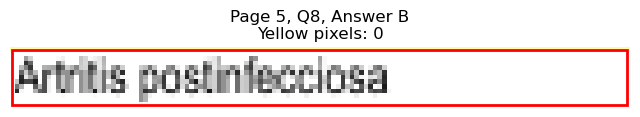

Page 5, Q8 - C: Detected box: x0=85.0, y0=639.3, x1=177.4, y1=651.4
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 499
Page 5, Q8, C: Yellow percentage: 0.0%


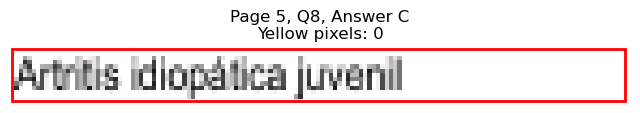

Page 5, Q8 - D: Detected box: x0=336.7, y0=615.2, x1=448.2, y1=627.3
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 565
Page 5, Q8, D: Yellow percentage: 0.0%


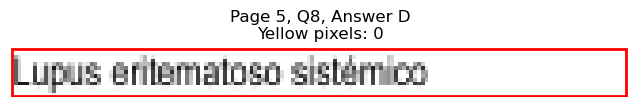

Page 5, Q8 - E: Detected box: x0=336.7, y0=627.3, x1=427.6, y1=639.4
Page 5, Q8, E: Yellow pixels: 0
Page 5, Q8, E: Total non-white pixels: 472
Page 5, Q8, E: Yellow percentage: 0.0%


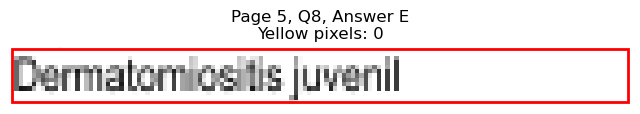


Page 5, Q8 - Selected Answer: A (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=85.0, y0=699.5, x1=119.4, y1=711.7
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 184
Page 5, Q9, A: Yellow percentage: 0.0%


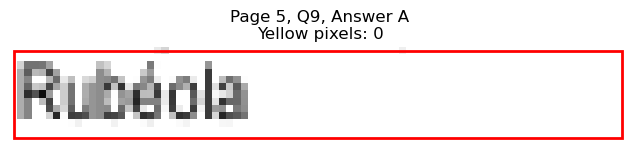

Page 5, Q9 - B: Detected box: x0=85.0, y0=711.7, x1=157.7, y1=723.8
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 378
Page 5, Q9, B: Yellow percentage: 0.0%


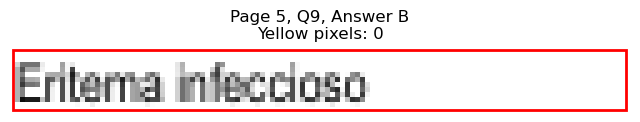

Page 5, Q9 - C: Detected box: x0=85.0, y0=723.7, x1=130.0, y1=735.8
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 250
Page 5, Q9, C: Yellow percentage: 0.0%


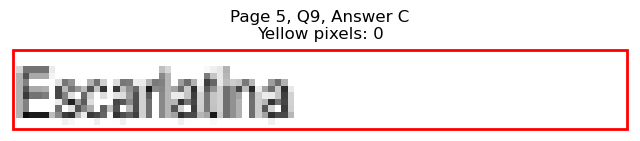

Page 5, Q9 - D: Detected box: x0=336.7, y0=699.5, x1=398.0, y1=711.7
Page 5, Q9, D: Yellow pixels: 1215
Page 5, Q9, D: Total non-white pixels: 1456
Page 5, Q9, D: Yellow percentage: 83.4%


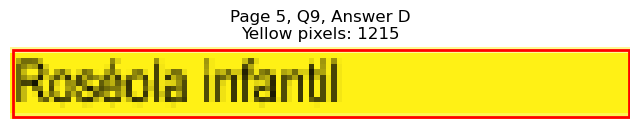

Page 5, Q9 - E: Detected box: x0=336.7, y0=711.7, x1=378.5, y1=723.8
Page 5, Q9, E: Yellow pixels: 93
Page 5, Q9, E: Total non-white pixels: 323
Page 5, Q9, E: Yellow percentage: 28.8%


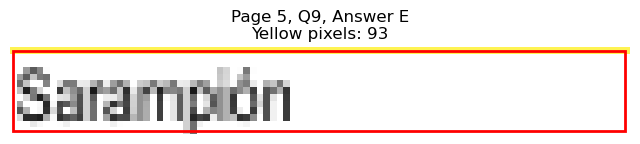


Page 5, Q9 - Selected Answer: D (based on yellow pixel count)





Page 6: Found 9 questions
Page 6, Q1 - A: Detected box: x0=85.0, y0=121.2, x1=133.3, y1=133.3
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 246
Page 6, Q1, A: Yellow percentage: 0.0%


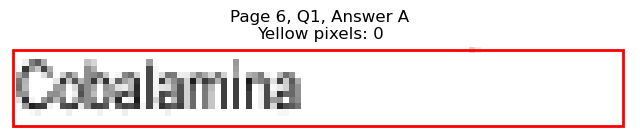

Page 6, Q1 - B: Detected box: x0=85.0, y0=133.2, x1=118.0, y1=145.3
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 171
Page 6, Q1, B: Yellow percentage: 0.0%


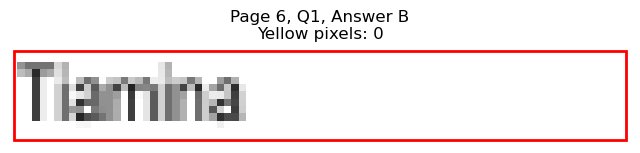

Page 6, Q1 - C: Detected box: x0=85.0, y0=145.3, x1=110.8, y1=157.4
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 129
Page 6, Q1, C: Yellow percentage: 0.0%


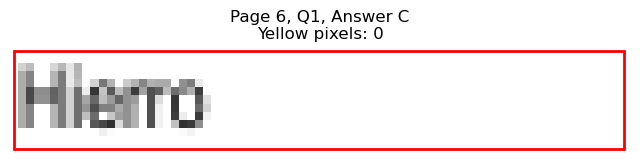

Page 6, Q1 - D: Detected box: x0=336.7, y0=121.2, x1=355.4, y1=133.3
Page 6, Q1, D: Yellow pixels: 773
Page 6, Q1, D: Total non-white pixels: 910
Page 6, Q1, D: Yellow percentage: 84.9%


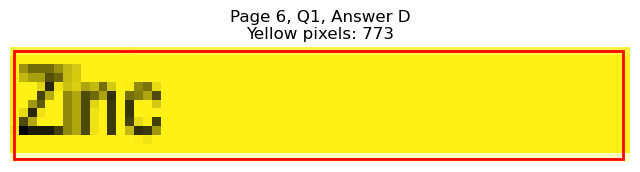

Page 6, Q1 - E: Detected box: x0=336.7, y0=133.2, x1=380.7, y1=145.3
Page 6, Q1, E: Yellow pixels: 0
Page 6, Q1, E: Total non-white pixels: 297
Page 6, Q1, E: Yellow percentage: 0.0%


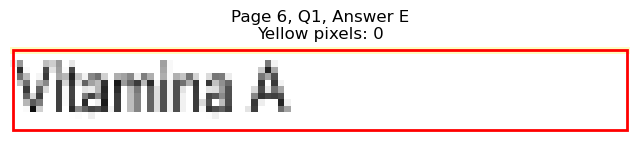


Page 6, Q1 - Selected Answer: D (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=85.0, y0=205.5, x1=144.9, y1=217.7
Page 6, Q2, A: Yellow pixels: 1204
Page 6, Q2, A: Total non-white pixels: 1443
Page 6, Q2, A: Yellow percentage: 83.4%


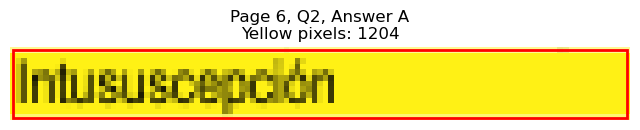

Page 6, Q2 - B: Detected box: x0=85.0, y0=217.5, x1=135.7, y1=229.7
Page 6, Q2, B: Yellow pixels: 102
Page 6, Q2, B: Total non-white pixels: 352
Page 6, Q2, B: Yellow percentage: 29.0%


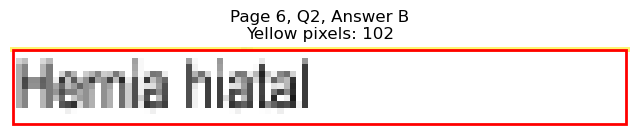

Page 6, Q2 - C: Detected box: x0=85.0, y0=229.7, x1=152.9, y1=241.8
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 336
Page 6, Q2, C: Yellow percentage: 0.0%


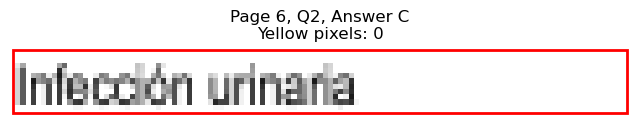

Page 6, Q2 - D: Detected box: x0=336.7, y0=205.5, x1=394.2, y1=217.7
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 302
Page 6, Q2, D: Yellow percentage: 0.0%


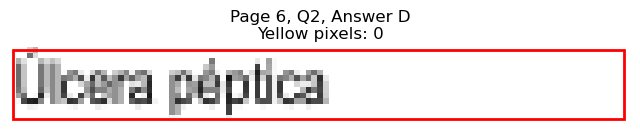

Page 6, Q2 - E: Detected box: x0=336.7, y0=217.5, x1=380.7, y1=229.7
Page 6, Q2, E: Yellow pixels: 0
Page 6, Q2, E: Total non-white pixels: 241
Page 6, Q2, E: Yellow percentage: 0.0%


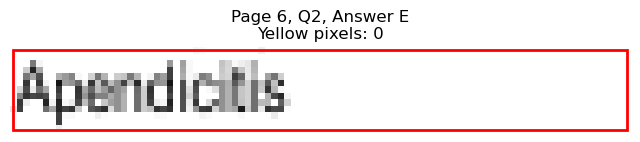


Page 6, Q2 - Selected Answer: A (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=85.0, y0=301.9, x1=179.8, y1=314.0
Page 6, Q3, A: Yellow pixels: 146
Page 6, Q3, A: Total non-white pixels: 791
Page 6, Q3, A: Yellow percentage: 18.5%


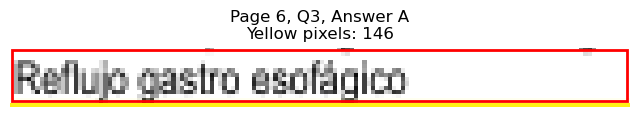

Page 6, Q3 - B: Detected box: x0=85.0, y0=313.9, x1=134.3, y1=326.0
Page 6, Q3, B: Yellow pixels: 1009
Page 6, Q3, B: Total non-white pixels: 1414
Page 6, Q3, B: Yellow percentage: 71.4%


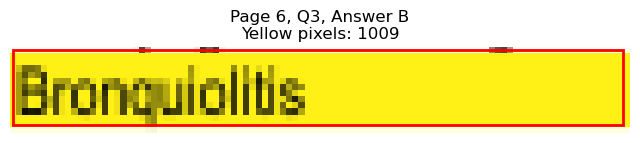

Page 6, Q3 - C: Detected box: x0=85.0, y0=326.1, x1=209.0, y1=338.2
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 832
Page 6, Q3, C: Yellow percentage: 0.0%


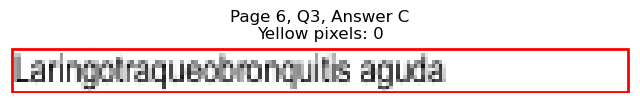

Page 6, Q3 - D: Detected box: x0=336.7, y0=301.9, x1=399.0, y1=314.0
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 317
Page 6, Q3, D: Yellow percentage: 0.0%


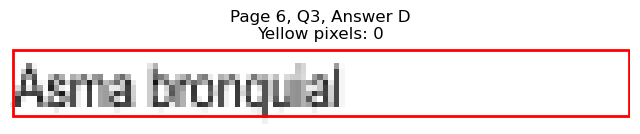

Page 6, Q3 - E: Detected box: x0=336.7, y0=313.9, x1=398.5, y1=326.0
Page 6, Q3, E: Yellow pixels: 0
Page 6, Q3, E: Total non-white pixels: 297
Page 6, Q3, E: Yellow percentage: 0.0%


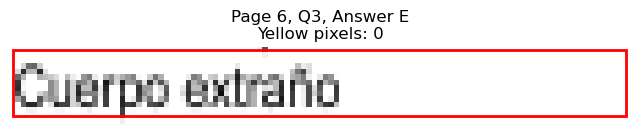


Page 6, Q3 - Selected Answer: B (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=85.0, y0=386.3, x1=184.1, y1=398.4
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 526
Page 6, Q4, A: Yellow percentage: 0.0%


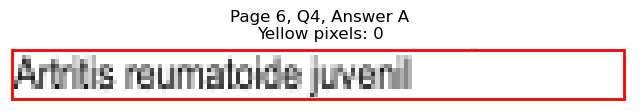

Page 6, Q4 - B: Detected box: x0=85.0, y0=398.3, x1=180.3, y1=410.4
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 504
Page 6, Q4, B: Yellow percentage: 0.0%


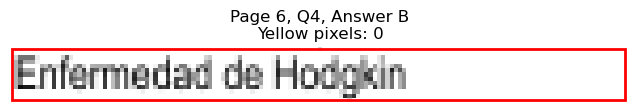

Page 6, Q4 - C: Detected box: x0=85.0, y0=410.4, x1=198.5, y1=422.5
Page 6, Q4, C: Yellow pixels: 1707
Page 6, Q4, C: Total non-white pixels: 2145
Page 6, Q4, C: Yellow percentage: 79.6%


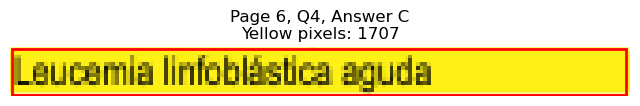

Page 6, Q4 - D: Detected box: x0=336.7, y0=386.3, x1=402.3, y1=398.4
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 351
Page 6, Q4, D: Yellow percentage: 0.0%


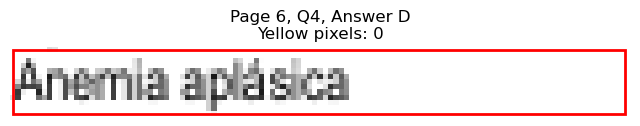

Page 6, Q4 - E: Detected box: x0=336.7, y0=398.3, x1=437.2, y1=410.4
Page 6, Q4, E: Yellow pixels: 0
Page 6, Q4, E: Total non-white pixels: 522
Page 6, Q4, E: Yellow percentage: 0.0%


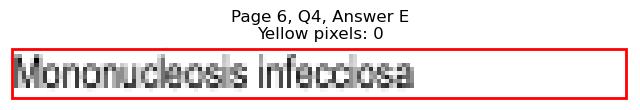


Page 6, Q4 - Selected Answer: C (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=85.0, y0=446.6, x1=176.9, y1=458.7
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 454
Page 6, Q5, A: Yellow percentage: 0.0%


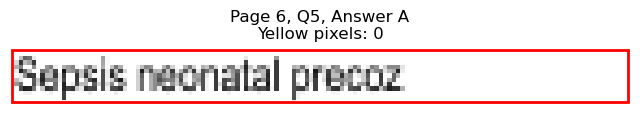

Page 6, Q5 - B: Detected box: x0=85.0, y0=458.6, x1=165.9, y1=470.7
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 405
Page 6, Q5, B: Yellow percentage: 0.0%


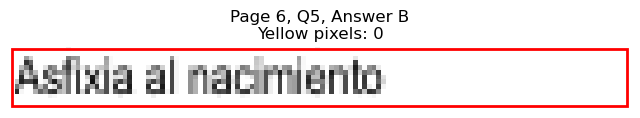

Page 6, Q5 - C: Detected box: x0=85.0, y0=470.7, x1=192.3, y1=482.8
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 576
Page 6, Q5, C: Yellow percentage: 0.0%


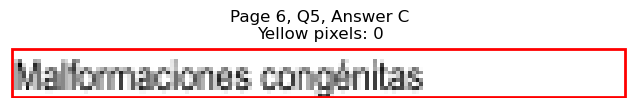

Page 6, Q5 - D: Detected box: x0=336.7, y0=446.6, x1=427.2, y1=458.7
Page 6, Q5, D: Yellow pixels: 142
Page 6, Q5, D: Total non-white pixels: 625
Page 6, Q5, D: Yellow percentage: 22.7%


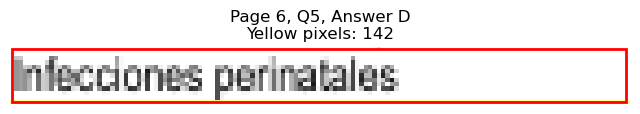

Page 6, Q5 - E: Detected box: x0=336.7, y0=458.6, x1=425.7, y1=470.7
Page 6, Q5, E: Yellow pixels: 1426
Page 6, Q5, E: Total non-white pixels: 1820
Page 6, Q5, E: Yellow percentage: 78.4%


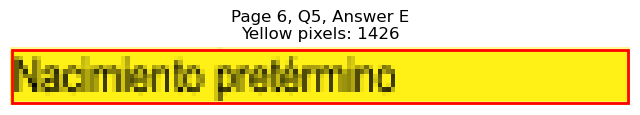


Page 6, Q5 - Selected Answer: E (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=85.0, y0=506.8, x1=142.0, y1=518.9
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 324
Page 6, Q6, A: Yellow percentage: 0.0%


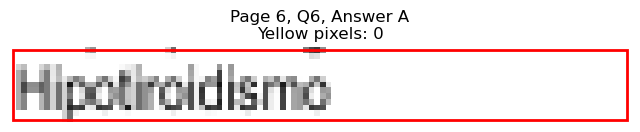

Page 6, Q6 - B: Detected box: x0=85.0, y0=518.8, x1=130.0, y1=530.9
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 233
Page 6, Q6, B: Yellow percentage: 0.0%


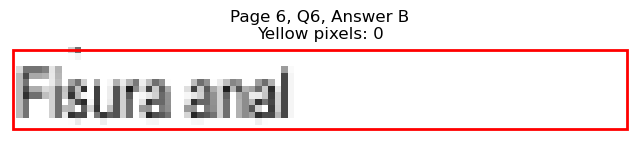

Page 6, Q6 - C: Detected box: x0=85.0, y0=530.9, x1=149.7, y1=543.0
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 336
Page 6, Q6, C: Yellow percentage: 0.0%


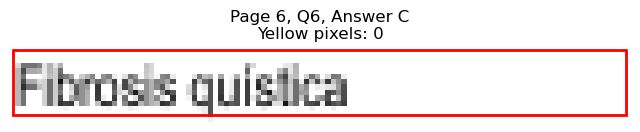

Page 6, Q6 - D: Detected box: x0=336.7, y0=506.8, x1=451.1, y1=518.9
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 747
Page 6, Q6, D: Yellow percentage: 0.0%


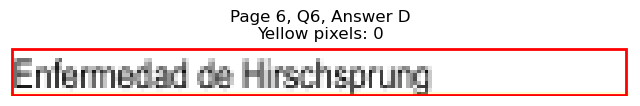

Page 6, Q6 - E: Detected box: x0=336.7, y0=518.8, x1=425.7, y1=530.9
Page 6, Q6, E: Yellow pixels: 1303
Page 6, Q6, E: Total non-white pixels: 1820
Page 6, Q6, E: Yellow percentage: 71.6%


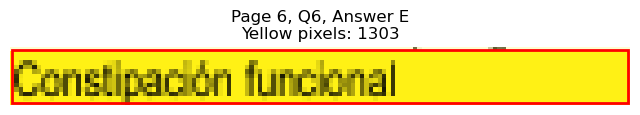


Page 6, Q6 - Selected Answer: E (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=85.0, y0=567.1, x1=99.9, y1=579.2
Page 6, Q7, A: Yellow pixels: 66
Page 6, Q7, A: Total non-white pixels: 125
Page 6, Q7, A: Yellow percentage: 52.8%


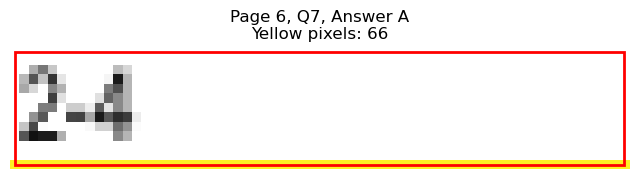

Page 6, Q7 - B: Detected box: x0=85.0, y0=579.1, x1=99.9, y1=591.2
Page 6, Q7, B: Yellow pixels: 745
Page 6, Q7, B: Total non-white pixels: 858
Page 6, Q7, B: Yellow percentage: 86.8%


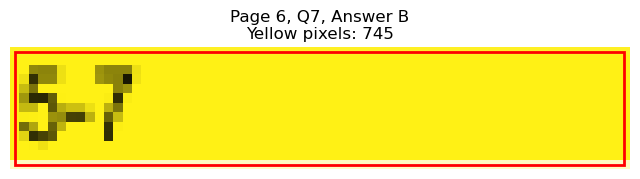

Page 6, Q7 - C: Detected box: x0=85.0, y0=591.2, x1=104.7, y1=603.3
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 150
Page 6, Q7, C: Yellow percentage: 0.0%


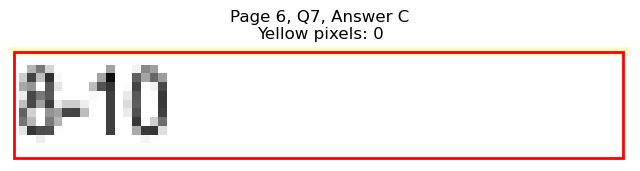

Page 6, Q7 - D: Detected box: x0=336.7, y0=567.1, x1=361.2, y1=579.2
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 89
Page 6, Q7, D: Yellow percentage: 0.0%


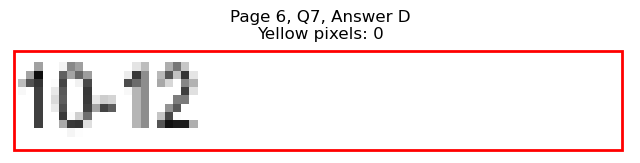

Page 6, Q7 - E: Detected box: x0=336.7, y0=579.1, x1=356.4, y1=591.2
Page 6, Q7, E: Yellow pixels: 0
Page 6, Q7, E: Total non-white pixels: 74
Page 6, Q7, E: Yellow percentage: 0.0%


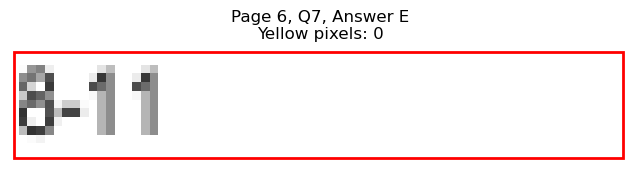


Page 6, Q7 - Selected Answer: B (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=85.0, y0=627.3, x1=199.5, y1=639.4
Page 6, Q8, A: Yellow pixels: 166
Page 6, Q8, A: Total non-white pixels: 700
Page 6, Q8, A: Yellow percentage: 23.7%


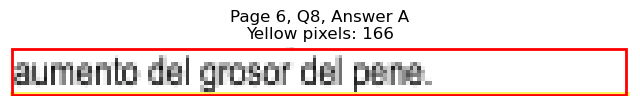

Page 6, Q8 - B: Detected box: x0=85.0, y0=639.3, x1=209.0, y1=651.4
Page 6, Q8, B: Yellow pixels: 1808
Page 6, Q8, B: Total non-white pixels: 2275
Page 6, Q8, B: Yellow percentage: 79.5%


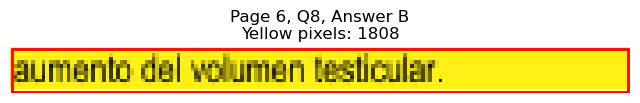

Page 6, Q8 - C: Detected box: x0=85.0, y0=651.4, x1=203.8, y1=663.5
Page 6, Q8, C: Yellow pixels: 170
Page 6, Q8, C: Total non-white pixels: 733
Page 6, Q8, C: Yellow percentage: 23.2%


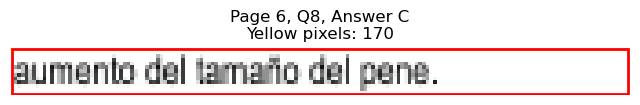

Page 6, Q8 - D: Detected box: x0=336.7, y0=627.3, x1=476.0, y1=639.4
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 696
Page 6, Q8, D: Yellow percentage: 0.0%


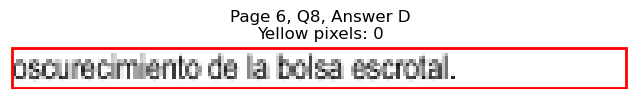

Page 6, Q8 - E: Detected box: x0=336.7, y0=639.3, x1=444.0, y1=651.4
Page 6, Q8, E: Yellow pixels: 0
Page 6, Q8, E: Total non-white pixels: 516
Page 6, Q8, E: Yellow percentage: 0.0%


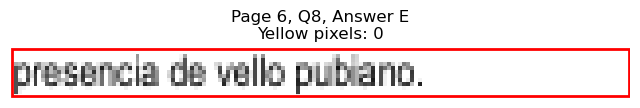


Page 6, Q8 - Selected Answer: B (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=85.0, y0=687.5, x1=145.3, y1=699.7
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 311
Page 6, Q9, A: Yellow percentage: 0.0%


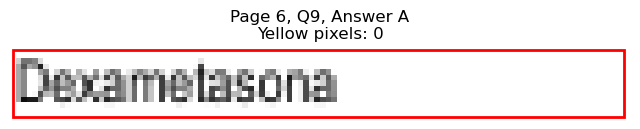

Page 6, Q9 - B: Detected box: x0=85.0, y0=699.5, x1=120.4, y1=711.7
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 180
Page 6, Q9, B: Yellow percentage: 0.0%


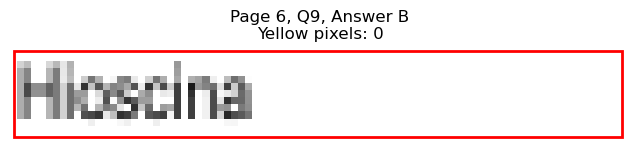

Page 6, Q9 - C: Detected box: x0=85.0, y0=711.7, x1=126.6, y1=723.8
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 213
Page 6, Q9, C: Yellow percentage: 0.0%


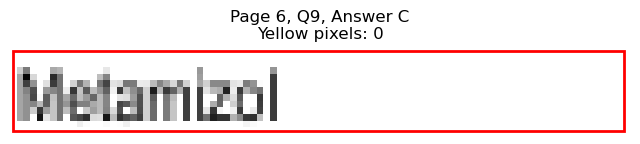

Page 6, Q9 - D: Detected box: x0=336.7, y0=687.5, x1=375.4, y1=699.7
Page 6, Q9, D: Yellow pixels: 90
Page 6, Q9, D: Total non-white pixels: 265
Page 6, Q9, D: Yellow percentage: 34.0%


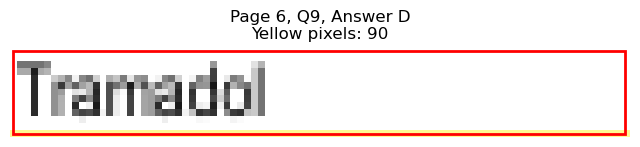

Page 6, Q9 - E: Detected box: x0=336.7, y0=699.5, x1=364.9, y1=711.7
Page 6, Q9, E: Yellow pixels: 901
Page 6, Q9, E: Total non-white pixels: 1027
Page 6, Q9, E: Yellow percentage: 87.7%


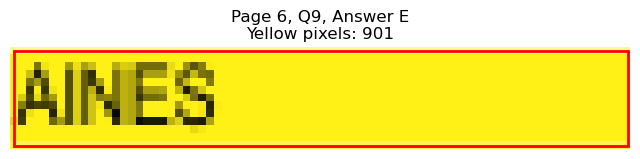


Page 6, Q9 - Selected Answer: E (based on yellow pixel count)





Page 7: Found 10 questions
Page 7, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=203.7, y1=109.2
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 603
Page 7, Q1, A: Yellow percentage: 0.0%


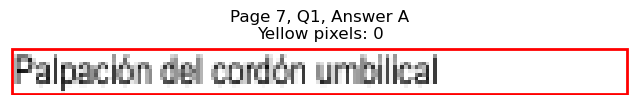

Page 7, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=228.7, y1=121.3
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 691
Page 7, Q1, B: Yellow percentage: 0.0%


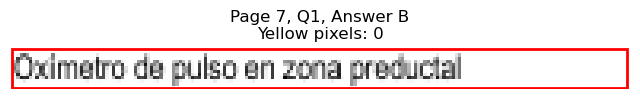

Page 7, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=218.6, y1=133.3
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 661
Page 7, Q1, C: Yellow percentage: 0.0%


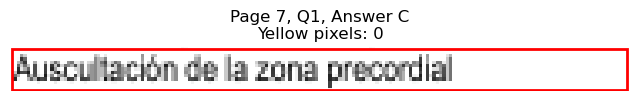

Page 7, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=457.8, y1=109.2
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 616
Page 7, Q1, D: Yellow percentage: 0.0%


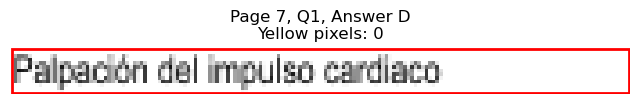

Page 7, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=483.6, y1=121.3
Page 7, Q1, E: Yellow pixels: 1692
Page 7, Q1, E: Total non-white pixels: 2470
Page 7, Q1, E: Yellow percentage: 68.5%


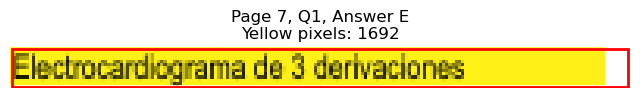


Page 7, Q1 - Selected Answer: E (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=85.0, y0=157.3, x1=144.4, y1=169.4
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 272
Page 7, Q2, A: Yellow percentage: 0.0%


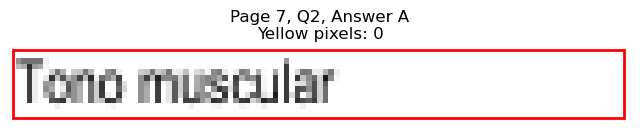

Page 7, Q2 - B: Detected box: x0=85.0, y0=169.4, x1=164.9, y1=181.5
Page 7, Q2, B: Yellow pixels: 1375
Page 7, Q2, B: Total non-white pixels: 1703
Page 7, Q2, B: Yellow percentage: 80.7%


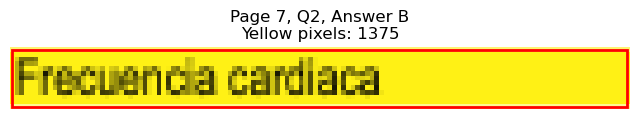

Page 7, Q2 - C: Detected box: x0=85.0, y0=181.4, x1=166.8, y1=193.5
Page 7, Q2, C: Yellow pixels: 133
Page 7, Q2, C: Total non-white pixels: 555
Page 7, Q2, C: Yellow percentage: 24.0%


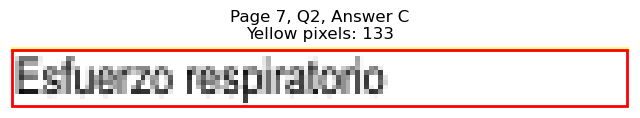

Page 7, Q2 - D: Detected box: x0=336.7, y0=157.3, x1=401.7, y1=169.4
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 303
Page 7, Q2, D: Yellow percentage: 0.0%


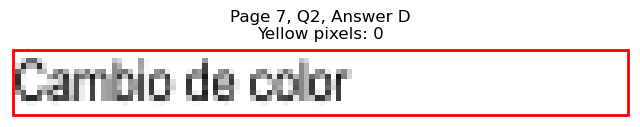

Page 7, Q2 - E: Detected box: x0=336.7, y0=169.4, x1=427.2, y1=181.5
Page 7, Q2, E: Yellow pixels: 0
Page 7, Q2, E: Total non-white pixels: 459
Page 7, Q2, E: Yellow percentage: 0.0%


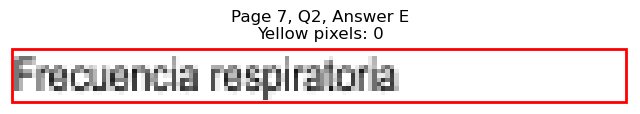


Page 7, Q2 - Selected Answer: B (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=85.0, y0=229.7, x1=132.4, y1=241.8
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 349
Page 7, Q3, A: Yellow percentage: 0.0%


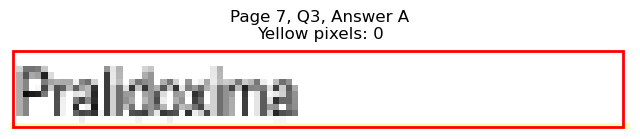

Page 7, Q3 - B: Detected box: x0=85.0, y0=241.7, x1=135.7, y1=253.8
Page 7, Q3, B: Yellow pixels: 999
Page 7, Q3, B: Total non-white pixels: 1326
Page 7, Q3, B: Yellow percentage: 75.3%


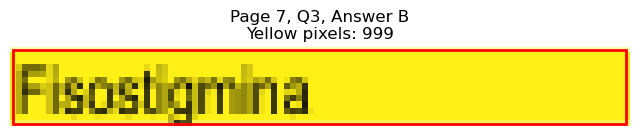

Page 7, Q3 - C: Detected box: x0=85.0, y0=253.7, x1=158.2, y1=265.8
Page 7, Q3, C: Yellow pixels: 121
Page 7, Q3, C: Total non-white pixels: 510
Page 7, Q3, C: Yellow percentage: 23.7%


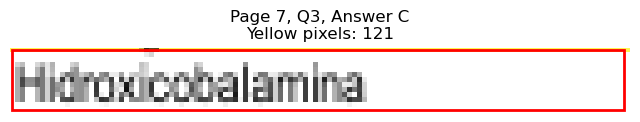

Page 7, Q3 - D: Detected box: x0=336.7, y0=229.7, x1=420.0, y1=241.8
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 418
Page 7, Q3, D: Yellow percentage: 0.0%


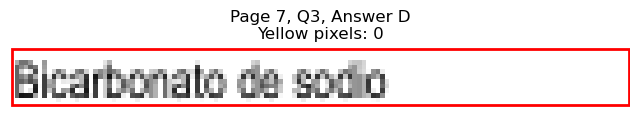

Page 7, Q3 - E: Detected box: x0=336.7, y0=241.7, x1=378.8, y1=253.8
Page 7, Q3, E: Yellow pixels: 0
Page 7, Q3, E: Total non-white pixels: 203
Page 7, Q3, E: Yellow percentage: 0.0%


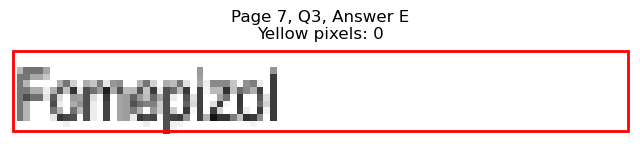


Page 7, Q3 - Selected Answer: B (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=85.0, y0=289.9, x1=97.0, y1=302.0
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 51
Page 7, Q4, A: Yellow percentage: 0.0%


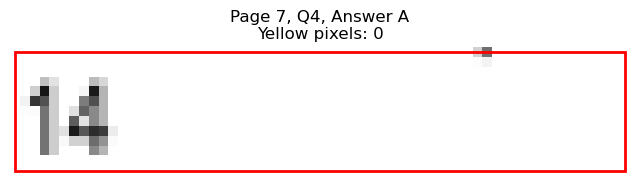

Page 7, Q4 - B: Detected box: x0=85.0, y0=301.9, x1=97.0, y1=314.0
Page 7, Q4, B: Yellow pixels: 63
Page 7, Q4, B: Total non-white pixels: 170
Page 7, Q4, B: Yellow percentage: 37.1%


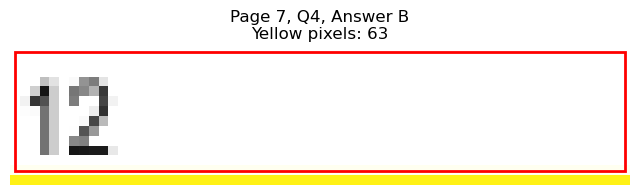

Page 7, Q4 - C: Detected box: x0=85.0, y0=313.9, x1=97.0, y1=326.0
Page 7, Q4, C: Yellow pixels: 723
Page 7, Q4, C: Total non-white pixels: 882
Page 7, Q4, C: Yellow percentage: 82.0%


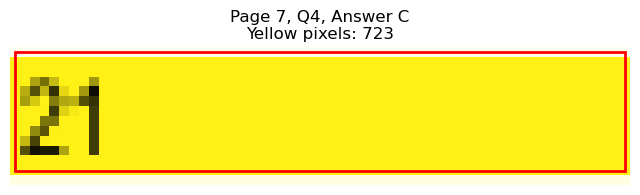

Page 7, Q4 - D: Detected box: x0=322.5, y0=289.9, x1=331.2, y1=302.0
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 52
Page 7, Q4, D: Yellow percentage: 0.0%


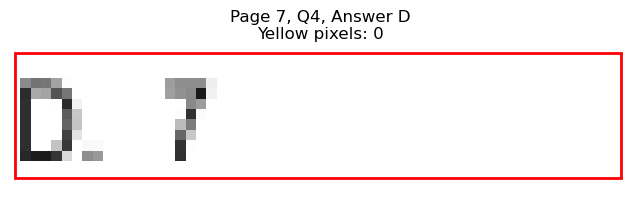

Page 7, Q4 - E: Detected box: x0=336.7, y0=301.9, x1=348.7, y1=314.0
Page 7, Q4, E: Yellow pixels: 0
Page 7, Q4, E: Total non-white pixels: 39
Page 7, Q4, E: Yellow percentage: 0.0%


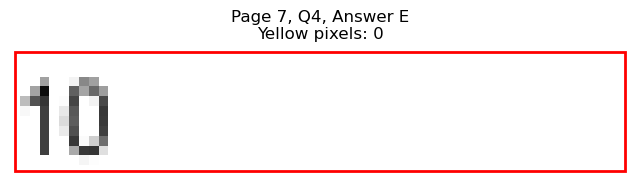


Page 7, Q4 - Selected Answer: C (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=85.0, y0=362.2, x1=97.0, y1=374.3
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 60
Page 7, Q5, A: Yellow percentage: 0.0%


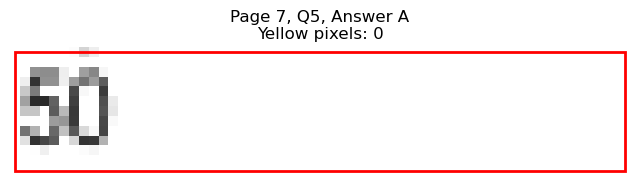

Page 7, Q5 - B: Detected box: x0=85.0, y0=374.2, x1=97.0, y1=386.3
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 53
Page 7, Q5, B: Yellow percentage: 0.0%


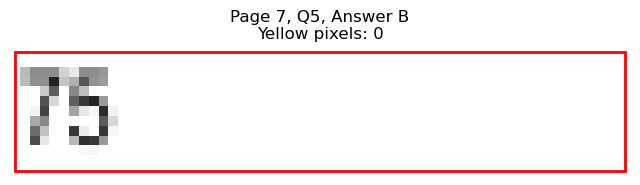

Page 7, Q5 - C: Detected box: x0=85.0, y0=386.3, x1=97.0, y1=398.4
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 61
Page 7, Q5, C: Yellow percentage: 0.0%


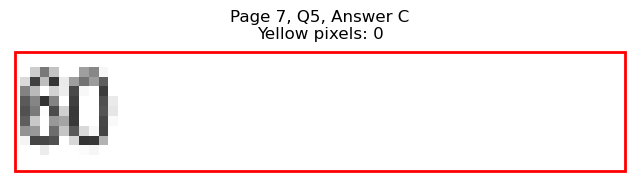

Page 7, Q5 - D: Detected box: x0=336.7, y0=362.2, x1=348.7, y1=374.3
Page 7, Q5, D: Yellow pixels: 719
Page 7, Q5, D: Total non-white pixels: 819
Page 7, Q5, D: Yellow percentage: 87.8%


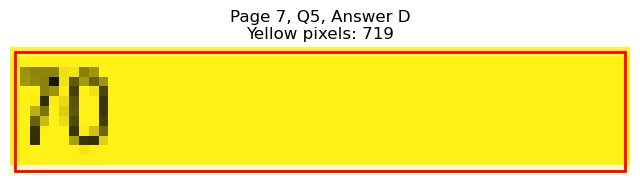

Page 7, Q5 - E: Detected box: x0=336.7, y0=374.2, x1=348.7, y1=386.3
Page 7, Q5, E: Yellow pixels: 0
Page 7, Q5, E: Total non-white pixels: 120
Page 7, Q5, E: Yellow percentage: 0.0%


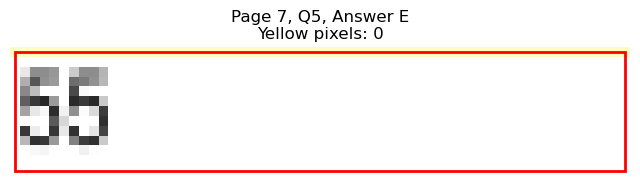


Page 7, Q5 - Selected Answer: D (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=85.0, y0=422.4, x1=115.1, y1=434.5
Page 7, Q6, A: Yellow pixels: 935
Page 7, Q6, A: Total non-white pixels: 1066
Page 7, Q6, A: Yellow percentage: 87.7%


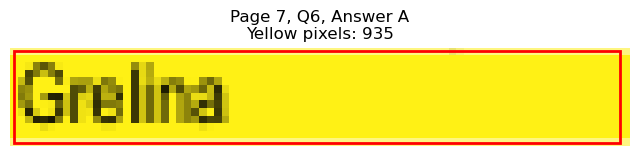

Page 7, Q6 - B: Detected box: x0=85.0, y0=434.4, x1=137.2, y1=446.5
Page 7, Q6, B: Yellow pixels: 104
Page 7, Q6, B: Total non-white pixels: 365
Page 7, Q6, B: Yellow percentage: 28.5%


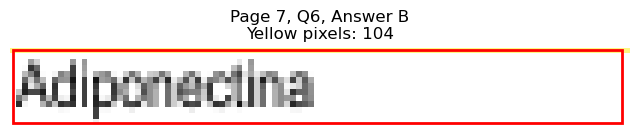

Page 7, Q6 - C: Detected box: x0=85.0, y0=446.6, x1=130.5, y1=458.7
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 206
Page 7, Q6, C: Yellow percentage: 0.0%


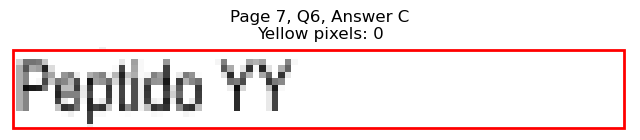

Page 7, Q6 - D: Detected box: x0=336.7, y0=422.4, x1=367.3, y1=434.5
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 158
Page 7, Q6, D: Yellow percentage: 0.0%


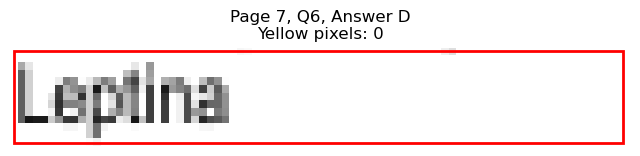

Page 7, Q6 - E: Detected box: x0=336.7, y0=434.4, x1=397.0, y1=446.5
Page 7, Q6, E: Yellow pixels: 0
Page 7, Q6, E: Total non-white pixels: 323
Page 7, Q6, E: Yellow percentage: 0.0%


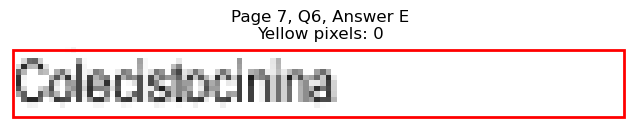


Page 7, Q6 - Selected Answer: A (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=152.2, y0=494.7, x1=292.5, y1=506.8
Page 7, Q7, A: Yellow pixels: 1721
Page 7, Q7, A: Total non-white pixels: 2483
Page 7, Q7, A: Yellow percentage: 69.3%


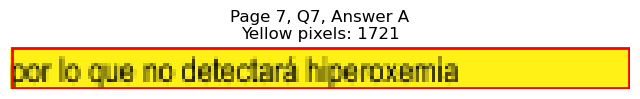

Page 7, Q7 - B: Detected box: x0=85.0, y0=506.8, x1=261.7, y1=518.9
Page 7, Q7, B: Yellow pixels: 222
Page 7, Q7, B: Total non-white pixels: 1129
Page 7, Q7, B: Yellow percentage: 19.7%


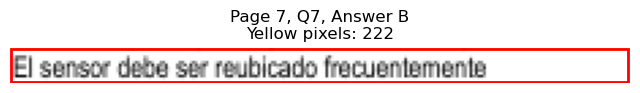

Page 7, Q7 - C: Detected box: x0=85.0, y0=518.8, x1=239.1, y1=530.9
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 757
Page 7, Q7, C: Yellow percentage: 0.0%


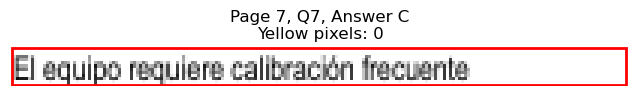

Page 7, Q7 - D: Detected box: x0=85.0, y0=530.9, x1=293.2, y1=543.0
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 1027
Page 7, Q7, D: Yellow percentage: 0.0%


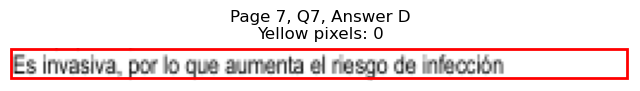

Page 7, Q7 - E: Detected box: x0=85.0, y0=542.9, x1=268.9, y1=555.0
Page 7, Q7, E: Yellow pixels: 0
Page 7, Q7, E: Total non-white pixels: 930
Page 7, Q7, E: Yellow percentage: 0.0%


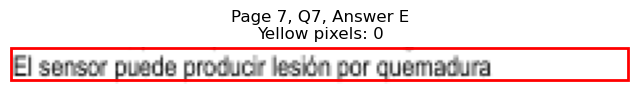


Page 7, Q7 - Selected Answer: A (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=85.0, y0=591.2, x1=120.9, y1=603.3
Page 7, Q8, A: Yellow pixels: 913
Page 7, Q8, A: Total non-white pixels: 1131
Page 7, Q8, A: Yellow percentage: 80.7%


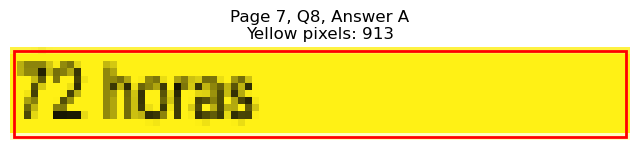

Page 7, Q8 - B: Detected box: x0=85.0, y0=603.2, x1=110.9, y1=615.3
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 202
Page 7, Q8, B: Yellow percentage: 0.0%


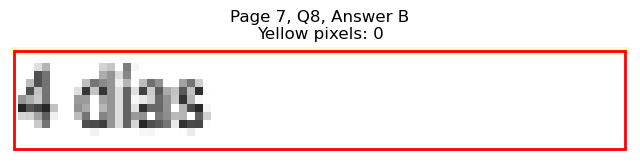

Page 7, Q8 - C: Detected box: x0=85.0, y0=615.2, x1=110.9, y1=627.3
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 129
Page 7, Q8, C: Yellow percentage: 0.0%


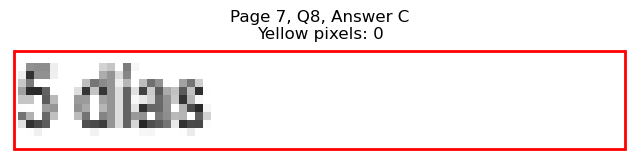

Page 7, Q8 - D: Detected box: x0=336.7, y0=591.2, x1=381.2, y1=603.3
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 214
Page 7, Q8, D: Yellow percentage: 0.0%


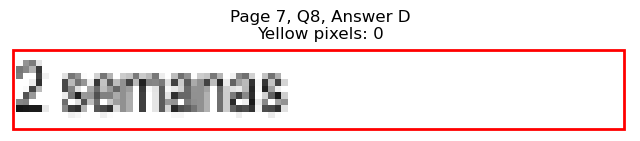

Page 7, Q8 - E: Detected box: x0=336.7, y0=603.2, x1=362.6, y1=615.3
Page 7, Q8, E: Yellow pixels: 0
Page 7, Q8, E: Total non-white pixels: 109
Page 7, Q8, E: Yellow percentage: 0.0%


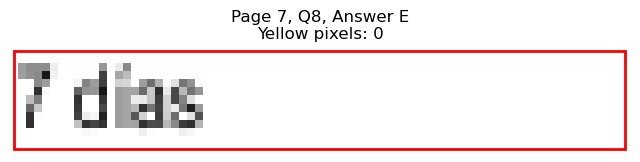


Page 7, Q8 - Selected Answer: A (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=85.0, y0=651.4, x1=163.0, y1=663.5
Page 7, Q9, A: Yellow pixels: 1345
Page 7, Q9, A: Total non-white pixels: 1677
Page 7, Q9, A: Yellow percentage: 80.2%


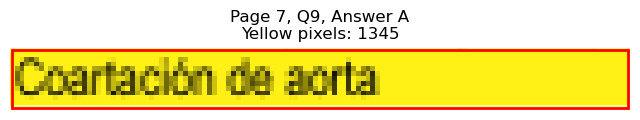

Page 7, Q9 - B: Detected box: x0=85.0, y0=663.4, x1=152.9, y1=675.5
Page 7, Q9, B: Yellow pixels: 119
Page 7, Q9, B: Total non-white pixels: 471
Page 7, Q9, B: Yellow percentage: 25.3%


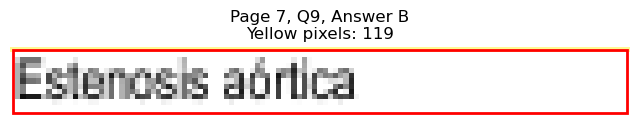

Page 7, Q9 - C: Detected box: x0=85.0, y0=675.4, x1=200.8, y1=687.5
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 614
Page 7, Q9, C: Yellow percentage: 0.0%


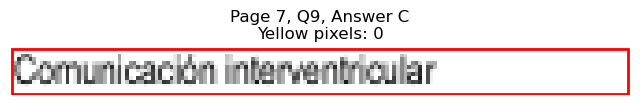

Page 7, Q9 - D: Detected box: x0=336.7, y0=651.4, x1=436.8, y1=663.5
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 549
Page 7, Q9, D: Yellow percentage: 0.0%


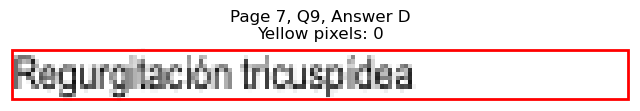

Page 7, Q9 - E: Detected box: x0=336.7, y0=663.4, x1=453.5, y1=675.5
Page 7, Q9, E: Yellow pixels: 0
Page 7, Q9, E: Total non-white pixels: 628
Page 7, Q9, E: Yellow percentage: 0.0%


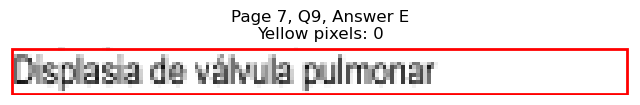


Page 7, Q9 - Selected Answer: A (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=85.0, y0=735.8, x1=235.7, y1=747.9
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 782
Page 7, Q10, A: Yellow percentage: 0.0%


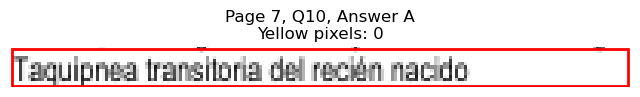

Page 7, Q10 - B: Detected box: x0=85.0, y0=747.8, x1=213.3, y1=759.9
Page 7, Q10, B: Yellow pixels: 0
Page 7, Q10, B: Total non-white pixels: 647
Page 7, Q10, B: Yellow percentage: 0.0%


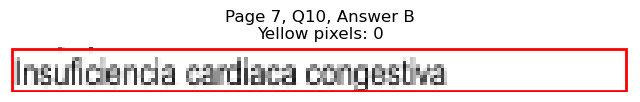

Page 7, Q10 - C: Detected box: x0=85.0, y0=759.8, x1=215.2, y1=771.9
Page 7, Q10, C: Yellow pixels: 0
Page 7, Q10, C: Total non-white pixels: 643
Page 7, Q10, C: Yellow percentage: 0.0%


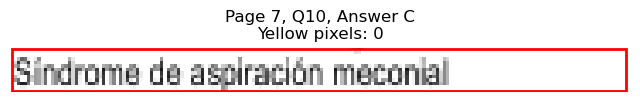

Page 7, Q10 - D: Detected box: x0=336.7, y0=735.8, x1=468.8, y1=747.9
Page 7, Q10, D: Yellow pixels: 1628
Page 7, Q10, D: Total non-white pixels: 2379
Page 7, Q10, D: Yellow percentage: 68.4%


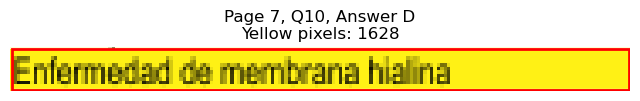

Page 7, Q10 - E: Detected box: x0=336.7, y0=747.8, x1=470.3, y1=759.9
Page 7, Q10, E: Yellow pixels: 185
Page 7, Q10, E: Total non-white pixels: 860
Page 7, Q10, E: Yellow percentage: 21.5%


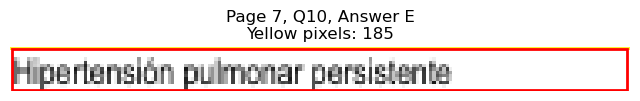


Page 7, Q10 - Selected Answer: D (based on yellow pixel count)





Page 8: Found 9 questions
Page 8, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=144.4, y1=109.2
Page 8, Q1, A: Yellow pixels: 1081
Page 8, Q1, A: Total non-white pixels: 1443
Page 8, Q1, A: Yellow percentage: 74.9%


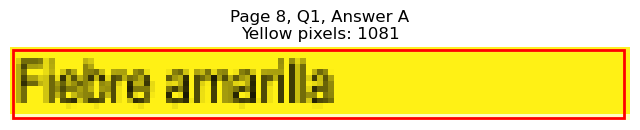

Page 8, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=106.0, y1=121.3
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 180
Page 8, Q1, B: Yellow percentage: 0.0%


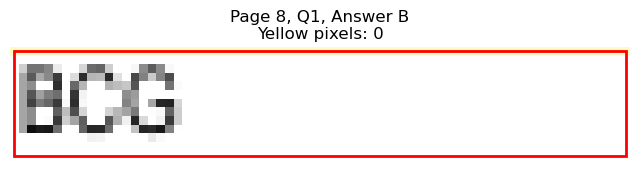

Page 8, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=104.5, y1=133.3
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 92
Page 8, Q1, C: Yellow percentage: 0.0%


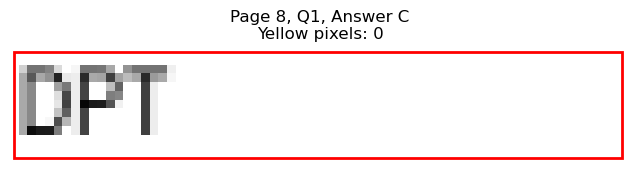

Page 8, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=385.0, y1=109.2
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 228
Page 8, Q1, D: Yellow percentage: 0.0%


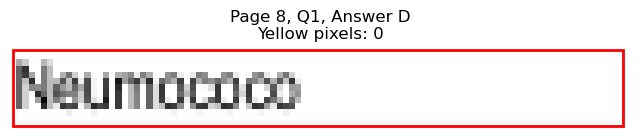

Page 8, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=431.0, y1=121.3
Page 8, Q1, E: Yellow pixels: 0
Page 8, Q1, E: Total non-white pixels: 478
Page 8, Q1, E: Yellow percentage: 0.0%


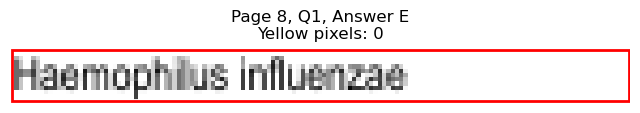


Page 8, Q1 - Selected Answer: A (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=85.0, y0=157.3, x1=250.1, y1=169.4
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 874
Page 8, Q2, A: Yellow percentage: 0.0%


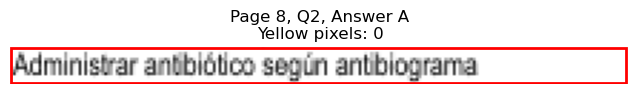

Page 8, Q2 - B: Detected box: x0=85.0, y0=169.4, x1=189.8, y1=181.5
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 545
Page 8, Q2, B: Yellow percentage: 0.0%


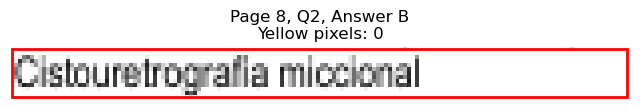

Page 8, Q2 - C: Detected box: x0=85.0, y0=181.4, x1=145.8, y1=193.5
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 315
Page 8, Q2, C: Yellow percentage: 0.0%


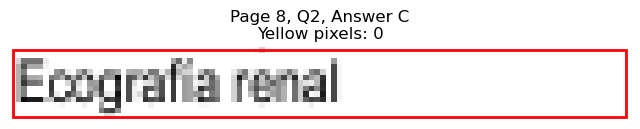

Page 8, Q2 - D: Detected box: x0=336.7, y0=157.3, x1=406.0, y1=169.4
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 353
Page 8, Q2, D: Yellow percentage: 0.0%


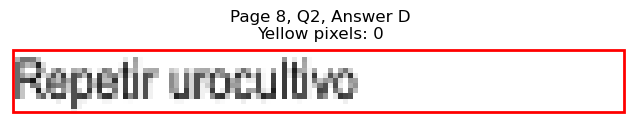

Page 8, Q2 - E: Detected box: x0=336.7, y0=169.4, x1=440.6, y1=181.5
Page 8, Q2, E: Yellow pixels: 1549
Page 8, Q2, E: Total non-white pixels: 2015
Page 8, Q2, E: Yellow percentage: 76.9%


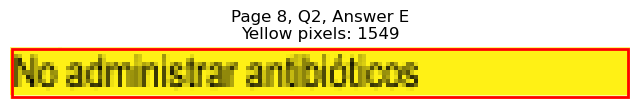


Page 8, Q2 - Selected Answer: E (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=85.0, y0=253.7, x1=99.4, y1=265.8
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 46
Page 8, Q3, A: Yellow percentage: 0.0%


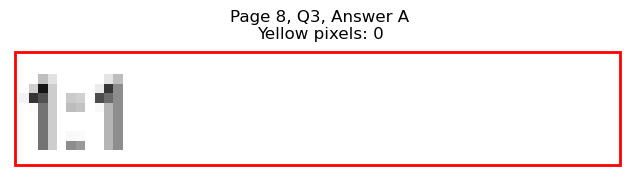

Page 8, Q3 - B: Detected box: x0=85.0, y0=265.8, x1=99.4, y1=277.9
Page 8, Q3, B: Yellow pixels: 749
Page 8, Q3, B: Total non-white pixels: 858
Page 8, Q3, B: Yellow percentage: 87.3%


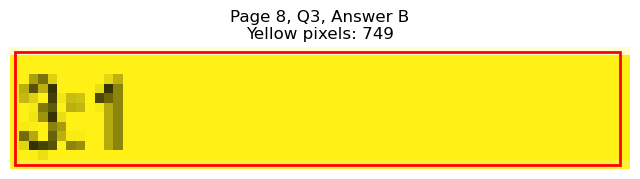

Page 8, Q3 - C: Detected box: x0=85.0, y0=277.8, x1=99.4, y1=289.9
Page 8, Q3, C: Yellow pixels: 66
Page 8, Q3, C: Total non-white pixels: 131
Page 8, Q3, C: Yellow percentage: 50.4%


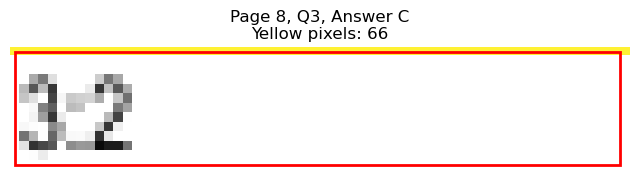

Page 8, Q3 - D: Detected box: x0=336.7, y0=253.7, x1=351.1, y1=265.8
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 48
Page 8, Q3, D: Yellow percentage: 0.0%


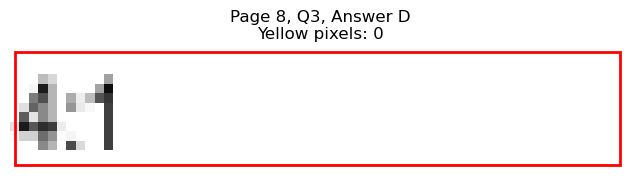

Page 8, Q3 - E: Detected box: x0=336.7, y0=265.8, x1=351.1, y1=277.9
Page 8, Q3, E: Yellow pixels: 0
Page 8, Q3, E: Total non-white pixels: 44
Page 8, Q3, E: Yellow percentage: 0.0%


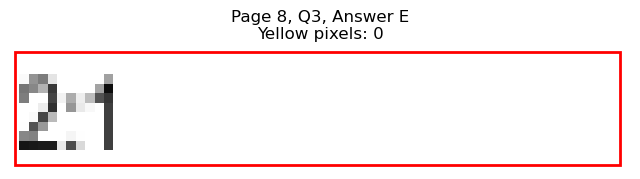


Page 8, Q3 - Selected Answer: B (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=85.0, y0=313.9, x1=157.7, y1=326.0
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 380
Page 8, Q4, A: Yellow percentage: 0.0%


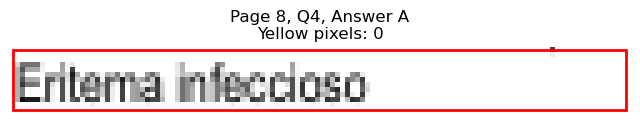

Page 8, Q4 - B: Detected box: x0=85.0, y0=326.1, x1=130.0, y1=338.2
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 250
Page 8, Q4, B: Yellow percentage: 0.0%


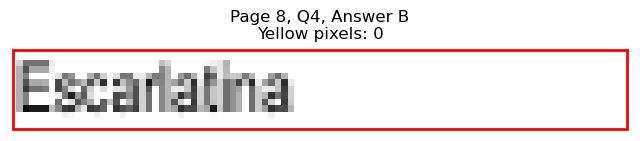

Page 8, Q4 - C: Detected box: x0=85.0, y0=338.1, x1=151.6, y1=350.2
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 346
Page 8, Q4, C: Yellow percentage: 0.0%


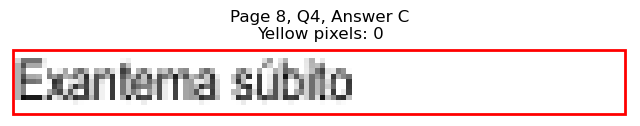

Page 8, Q4 - D: Detected box: x0=336.7, y0=313.9, x1=380.7, y1=326.0
Page 8, Q4, D: Yellow pixels: 952
Page 8, Q4, D: Total non-white pixels: 1330
Page 8, Q4, D: Yellow percentage: 71.6%


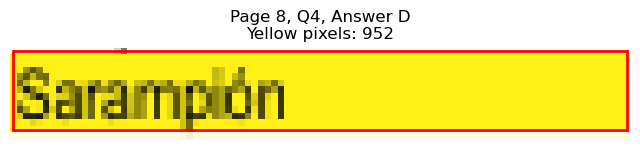

Page 8, Q4 - E: Detected box: x0=336.7, y0=326.1, x1=371.1, y1=338.2
Page 8, Q4, E: Yellow pixels: 0
Page 8, Q4, E: Total non-white pixels: 277
Page 8, Q4, E: Yellow percentage: 0.0%


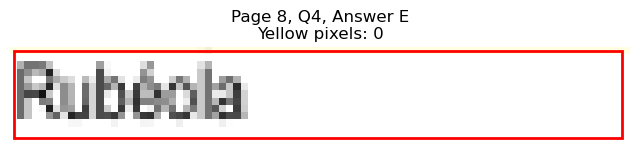


Page 8, Q4 - Selected Answer: D (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=85.0, y0=398.3, x1=239.6, y1=410.4
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 807
Page 8, Q5, A: Yellow percentage: 0.0%


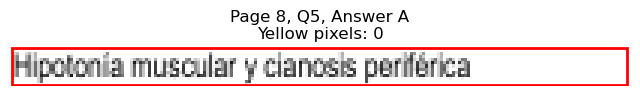

Page 8, Q5 - B: Detected box: x0=85.0, y0=410.4, x1=209.5, y1=422.5
Page 8, Q5, B: Yellow pixels: 176
Page 8, Q5, B: Total non-white pixels: 813
Page 8, Q5, B: Yellow percentage: 21.6%


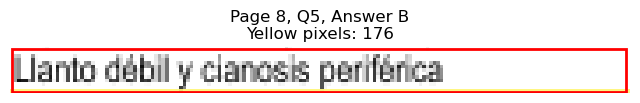

Page 8, Q5 - C: Detected box: x0=85.0, y0=422.4, x1=238.1, y1=434.5
Page 8, Q5, C: Yellow pixels: 1895
Page 8, Q5, C: Total non-white pixels: 2483
Page 8, Q5, C: Yellow percentage: 76.3%


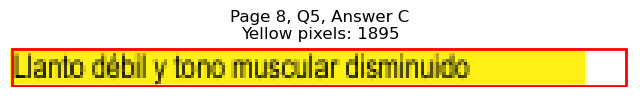

Page 8, Q5 - D: Detected box: x0=336.7, y0=398.3, x1=454.4, y1=410.4
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 596
Page 8, Q5, D: Yellow percentage: 0.0%


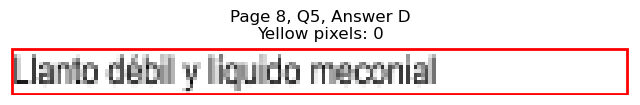

Page 8, Q5 - E: Detected box: x0=336.7, y0=410.4, x1=443.5, y1=422.5
Page 8, Q5, E: Yellow pixels: 0
Page 8, Q5, E: Total non-white pixels: 529
Page 8, Q5, E: Yellow percentage: 0.0%


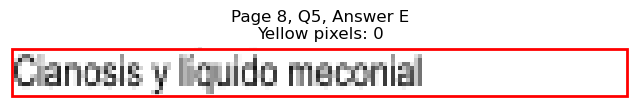


Page 8, Q5 - Selected Answer: C (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=85.0, y0=482.7, x1=182.2, y1=494.8
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 501
Page 8, Q6, A: Yellow percentage: 0.0%


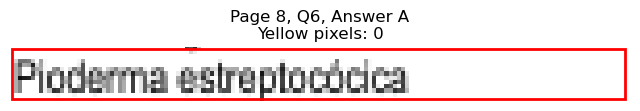

Page 8, Q6 - B: Detected box: x0=85.0, y0=494.7, x1=136.2, y1=506.8
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 257
Page 8, Q6, B: Yellow percentage: 0.0%


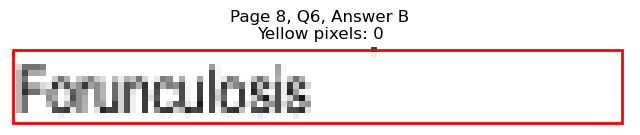

Page 8, Q6 - C: Detected box: x0=85.0, y0=506.8, x1=213.3, y1=518.9
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 617
Page 8, Q6, C: Yellow percentage: 0.0%


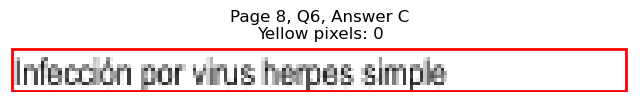

Page 8, Q6 - D: Detected box: x0=336.7, y0=482.7, x1=407.5, y1=494.8
Page 8, Q6, D: Yellow pixels: 2
Page 8, Q6, D: Total non-white pixels: 510
Page 8, Q6, D: Yellow percentage: 0.4%


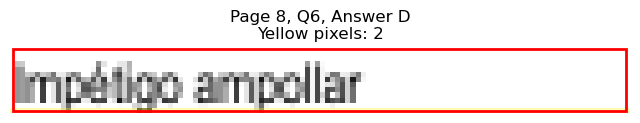

Page 8, Q6 - E: Detected box: x0=336.7, y0=494.7, x1=419.5, y1=506.8
Page 8, Q6, E: Yellow pixels: 1249
Page 8, Q6, E: Total non-white pixels: 1742
Page 8, Q6, E: Yellow percentage: 71.7%


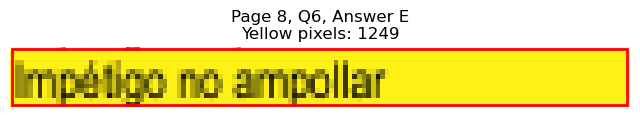


Page 8, Q6 - Selected Answer: E (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=85.0, y0=554.9, x1=141.5, y1=567.0
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 301
Page 8, Q7, A: Yellow percentage: 0.0%


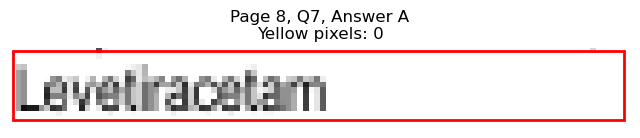

Page 8, Q7 - B: Detected box: x0=85.0, y0=567.1, x1=130.5, y1=579.2
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 215
Page 8, Q7, B: Yellow percentage: 0.0%


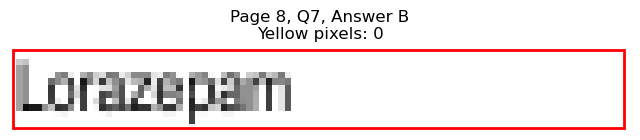

Page 8, Q7 - C: Detected box: x0=85.0, y0=579.1, x1=126.1, y1=591.2
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 221
Page 8, Q7, C: Yellow percentage: 0.0%


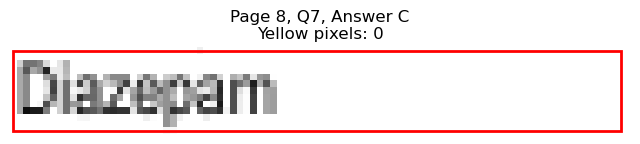

Page 8, Q7 - D: Detected box: x0=336.7, y0=554.9, x1=375.0, y1=567.0
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 186
Page 8, Q7, D: Yellow percentage: 0.0%


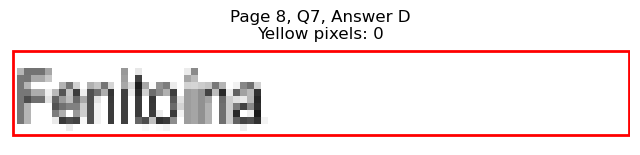

Page 8, Q7 - E: Detected box: x0=336.7, y0=567.1, x1=387.0, y1=579.2
Page 8, Q7, E: Yellow pixels: 994
Page 8, Q7, E: Total non-white pixels: 1313
Page 8, Q7, E: Yellow percentage: 75.7%


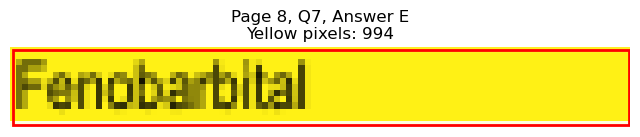


Page 8, Q7 - Selected Answer: E (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=85.0, y0=639.3, x1=124.2, y1=651.4
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 206
Page 8, Q8, A: Yellow percentage: 0.0%


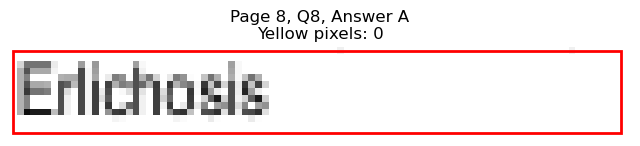

Page 8, Q8 - B: Detected box: x0=85.0, y0=651.4, x1=118.9, y1=663.5
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 183
Page 8, Q8, B: Yellow percentage: 0.0%


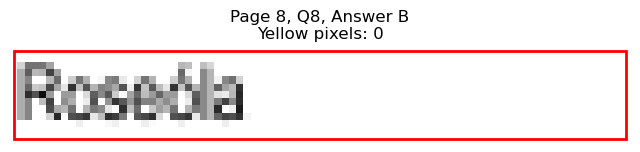

Page 8, Q8 - C: Detected box: x0=85.0, y0=663.4, x1=119.4, y1=675.5
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 181
Page 8, Q8, C: Yellow percentage: 0.0%


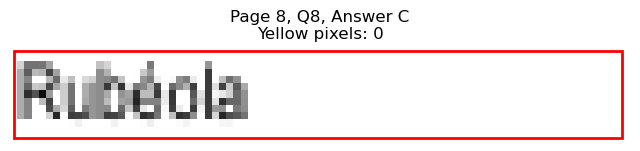

Page 8, Q8 - D: Detected box: x0=336.7, y0=639.3, x1=370.2, y1=651.4
Page 8, Q8, D: Yellow pixels: 959
Page 8, Q8, D: Total non-white pixels: 1105
Page 8, Q8, D: Yellow percentage: 86.8%


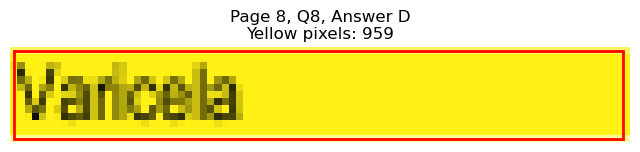

Page 8, Q8 - E: Detected box: x0=336.7, y0=651.4, x1=380.7, y1=663.5
Page 8, Q8, E: Yellow pixels: 95
Page 8, Q8, E: Total non-white pixels: 326
Page 8, Q8, E: Yellow percentage: 29.1%


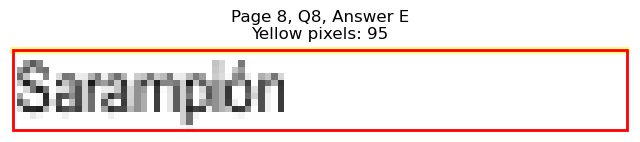


Page 8, Q8 - Selected Answer: D (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=85.0, y0=711.7, x1=131.9, y1=723.8
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 255
Page 8, Q9, A: Yellow percentage: 0.0%


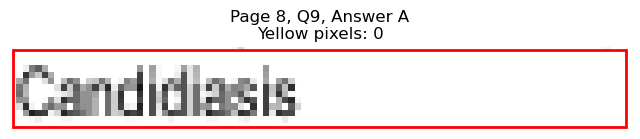

Page 8, Q9 - B: Detected box: x0=85.0, y0=723.7, x1=123.7, y1=735.8
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 185
Page 8, Q9, B: Yellow percentage: 0.0%


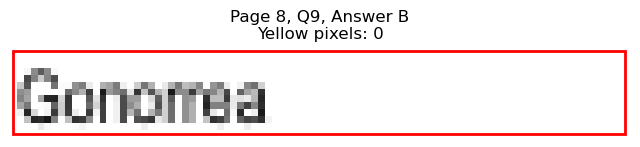

Page 8, Q9 - C: Detected box: x0=85.0, y0=735.8, x1=145.3, y1=747.9
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 318
Page 8, Q9, C: Yellow percentage: 0.0%


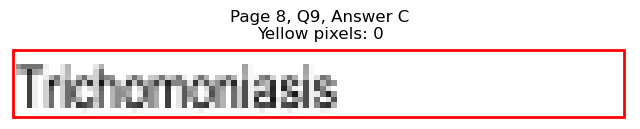

Page 8, Q9 - D: Detected box: x0=336.7, y0=711.7, x1=395.6, y1=723.8
Page 8, Q9, D: Yellow pixels: 1073
Page 8, Q9, D: Total non-white pixels: 1430
Page 8, Q9, D: Yellow percentage: 75.0%


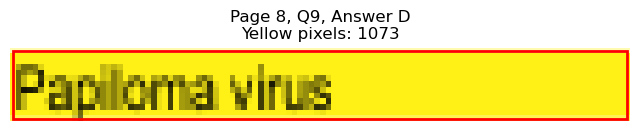

Page 8, Q9 - E: Detected box: x0=336.7, y0=723.7, x1=419.0, y1=735.8
Page 8, Q9, E: Yellow pixels: 131
Page 8, Q9, E: Total non-white pixels: 566
Page 8, Q9, E: Yellow percentage: 23.1%


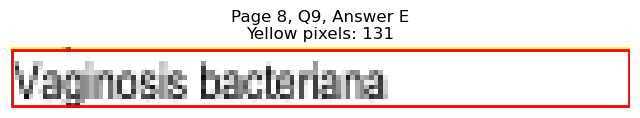


Page 8, Q9 - Selected Answer: D (based on yellow pixel count)





Page 9: Found 9 questions
Page 9, Q1 - A: Detected box: x0=85.0, y0=109.2, x1=270.8, y1=121.3
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 981
Page 9, Q1, A: Yellow percentage: 0.0%


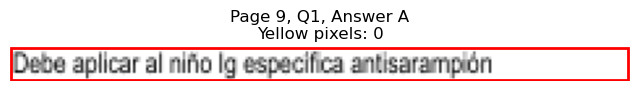

Page 9, Q1 - B: Detected box: x0=85.0, y0=121.2, x1=185.7, y1=133.3
Page 9, Q1, B: Yellow pixels: 152
Page 9, Q1, B: Total non-white pixels: 668
Page 9, Q1, B: Yellow percentage: 22.8%


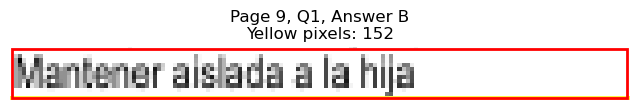

Page 9, Q1 - C: Detected box: x0=85.0, y0=133.2, x1=190.0, y1=145.3
Page 9, Q1, C: Yellow pixels: 1436
Page 9, Q1, C: Total non-white pixels: 2041
Page 9, Q1, C: Yellow percentage: 70.4%


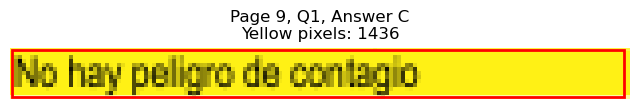

Page 9, Q1 - D: Detected box: x0=336.7, y0=109.2, x1=462.6, y1=121.3
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 641
Page 9, Q1, D: Yellow percentage: 0.0%


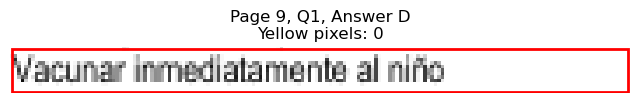

Page 9, Q1 - E: Detected box: x0=336.7, y0=121.2, x1=498.9, y1=133.3
Page 9, Q1, E: Yellow pixels: 0
Page 9, Q1, E: Total non-white pixels: 802
Page 9, Q1, E: Yellow percentage: 0.0%


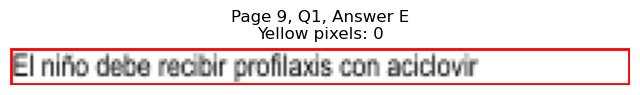


Page 9, Q1 - Selected Answer: C (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=85.0, y0=193.4, x1=163.2, y1=205.5
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 361
Page 9, Q2, A: Yellow percentage: 0.0%


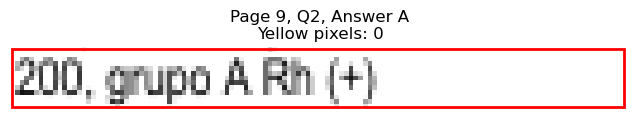

Page 9, Q2 - B: Detected box: x0=85.0, y0=205.5, x1=162.0, y1=217.7
Page 9, Q2, B: Yellow pixels: 1398
Page 9, Q2, B: Total non-white pixels: 1677
Page 9, Q2, B: Yellow percentage: 83.4%


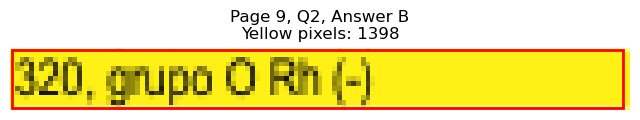

Page 9, Q2 - C: Detected box: x0=85.0, y0=217.5, x1=161.1, y1=229.7
Page 9, Q2, C: Yellow pixels: 128
Page 9, Q2, C: Total non-white pixels: 469
Page 9, Q2, C: Yellow percentage: 27.3%


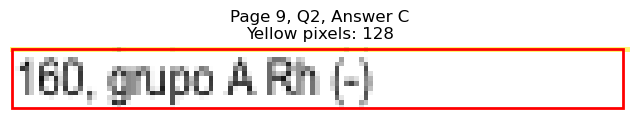

Page 9, Q2 - D: Detected box: x0=336.7, y0=193.4, x1=415.9, y1=205.5
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 368
Page 9, Q2, D: Yellow percentage: 0.0%


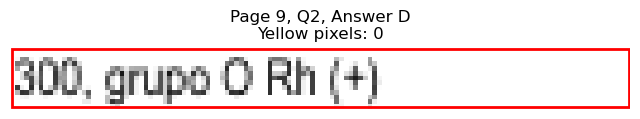

Page 9, Q2 - E: Detected box: x0=336.7, y0=205.5, x1=414.9, y1=217.7
Page 9, Q2, E: Yellow pixels: 0
Page 9, Q2, E: Total non-white pixels: 377
Page 9, Q2, E: Yellow percentage: 0.0%


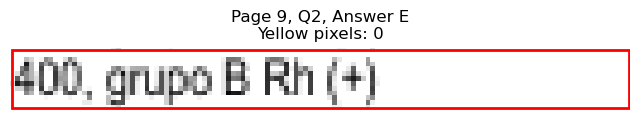


Page 9, Q2 - Selected Answer: B (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=85.0, y0=265.8, x1=124.7, y1=277.9
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 220
Page 9, Q3, A: Yellow percentage: 0.0%


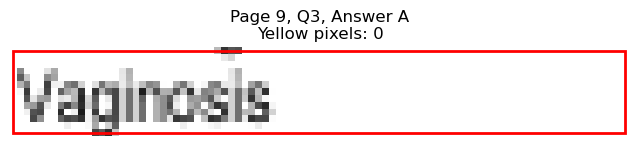

Page 9, Q3 - B: Detected box: x0=85.0, y0=277.8, x1=123.7, y1=289.9
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 191
Page 9, Q3, B: Yellow percentage: 0.0%


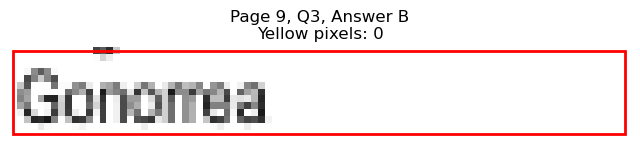

Page 9, Q3 - C: Detected box: x0=85.0, y0=289.9, x1=145.3, y1=302.0
Page 9, Q3, C: Yellow pixels: 1094
Page 9, Q3, C: Total non-white pixels: 1456
Page 9, Q3, C: Yellow percentage: 75.1%


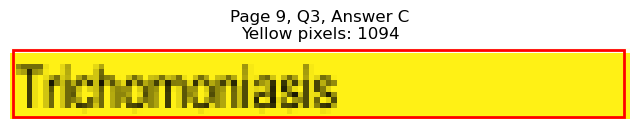

Page 9, Q3 - D: Detected box: x0=336.7, y0=265.8, x1=383.6, y1=277.9
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 261
Page 9, Q3, D: Yellow percentage: 0.0%


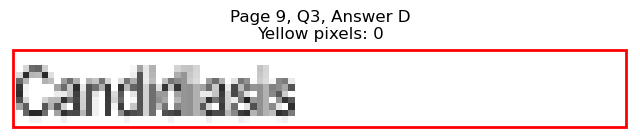

Page 9, Q3 - E: Detected box: x0=336.7, y0=277.8, x1=381.2, y1=289.9
Page 9, Q3, E: Yellow pixels: 0
Page 9, Q3, E: Total non-white pixels: 243
Page 9, Q3, E: Yellow percentage: 0.0%


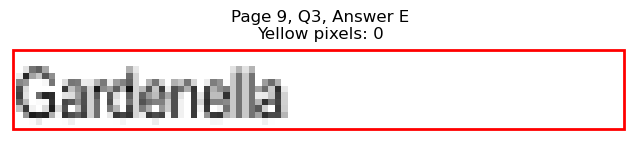


Page 9, Q3 - Selected Answer: C (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=85.0, y0=350.2, x1=175.5, y1=362.3
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 454
Page 9, Q4, A: Yellow percentage: 0.0%


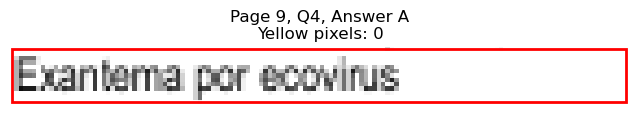

Page 9, Q4 - B: Detected box: x0=85.0, y0=362.2, x1=119.4, y1=374.3
Page 9, Q4, B: Yellow pixels: 86
Page 9, Q4, B: Total non-white pixels: 268
Page 9, Q4, B: Yellow percentage: 32.1%


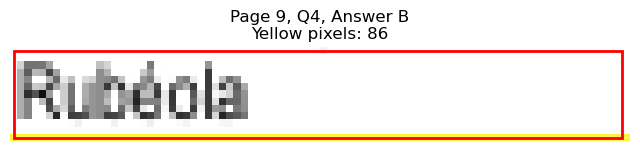

Page 9, Q4 - C: Detected box: x0=85.0, y0=374.2, x1=157.7, y1=386.3
Page 9, Q4, C: Yellow pixels: 1180
Page 9, Q4, C: Total non-white pixels: 1612
Page 9, Q4, C: Yellow percentage: 73.2%


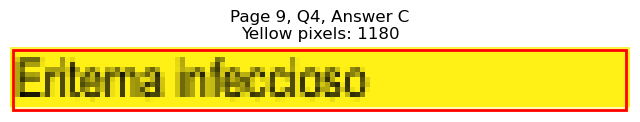

Page 9, Q4 - D: Detected box: x0=336.7, y0=350.2, x1=403.3, y1=362.3
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 342
Page 9, Q4, D: Yellow percentage: 0.0%


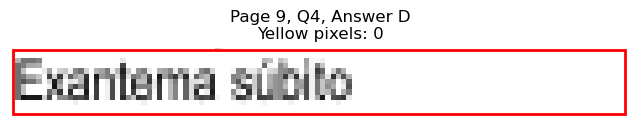

Page 9, Q4 - E: Detected box: x0=336.7, y0=362.2, x1=437.2, y1=374.3
Page 9, Q4, E: Yellow pixels: 0
Page 9, Q4, E: Total non-white pixels: 521
Page 9, Q4, E: Yellow percentage: 0.0%


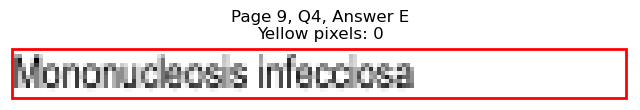


Page 9, Q4 - Selected Answer: C (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=85.0, y0=422.4, x1=152.4, y1=434.5
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 350
Page 9, Q5, A: Yellow percentage: 0.0%


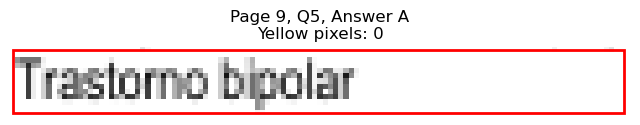

Page 9, Q5 - B: Detected box: x0=85.0, y0=434.4, x1=104.2, y1=446.5
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 95
Page 9, Q5, B: Yellow percentage: 0.0%


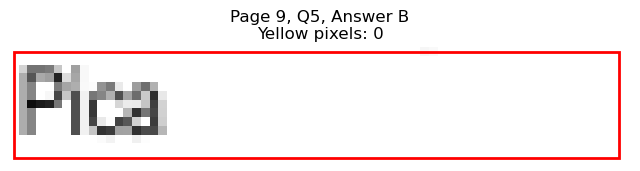

Page 9, Q5 - C: Detected box: x0=85.0, y0=446.6, x1=161.5, y1=458.7
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 370
Page 9, Q5, C: Yellow percentage: 0.0%


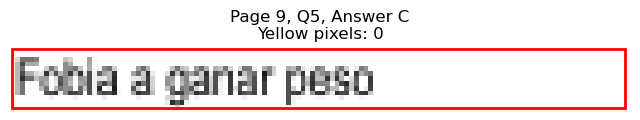

Page 9, Q5 - D: Detected box: x0=336.7, y0=422.4, x1=400.4, y1=434.5
Page 9, Q5, D: Yellow pixels: 1225
Page 9, Q5, D: Total non-white pixels: 1495
Page 9, Q5, D: Yellow percentage: 81.9%


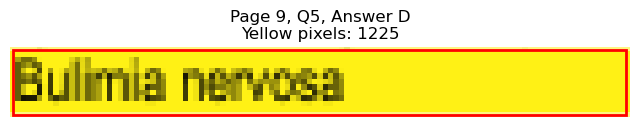

Page 9, Q5 - E: Detected box: x0=336.7, y0=434.4, x1=426.7, y1=446.5
Page 9, Q5, E: Yellow pixels: 141
Page 9, Q5, E: Total non-white pixels: 621
Page 9, Q5, E: Yellow percentage: 22.7%


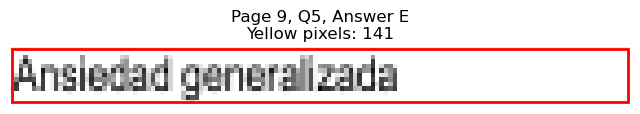


Page 9, Q5 - Selected Answer: D (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=85.0, y0=494.7, x1=97.0, y1=506.8
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 63
Page 9, Q6, A: Yellow percentage: 0.0%


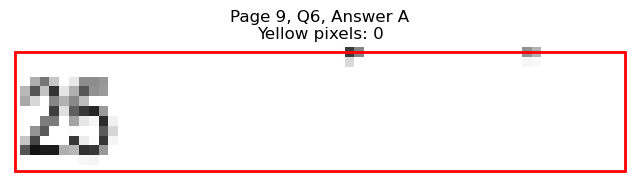

Page 9, Q6 - B: Detected box: x0=85.0, y0=506.8, x1=97.0, y1=518.9
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 53
Page 9, Q6, B: Yellow percentage: 0.0%


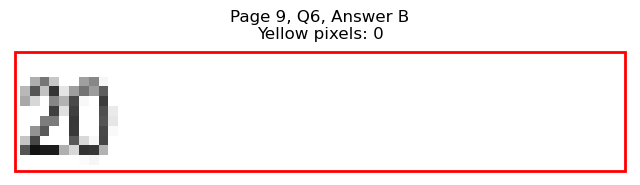

Page 9, Q6 - C: Detected box: x0=85.0, y0=518.8, x1=97.0, y1=530.9
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 47
Page 9, Q6, C: Yellow percentage: 0.0%


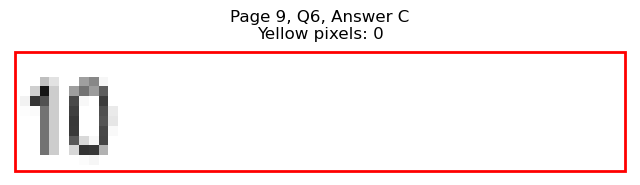

Page 9, Q6 - D: Detected box: x0=322.5, y0=494.7, x1=331.2, y1=506.8
Page 9, Q6, D: Yellow pixels: 673
Page 9, Q6, D: Total non-white pixels: 780
Page 9, Q6, D: Yellow percentage: 86.3%


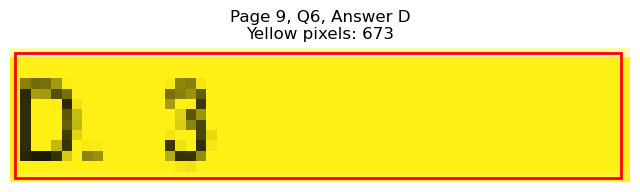

Page 9, Q6 - E: Detected box: x0=336.7, y0=506.8, x1=348.7, y1=518.9
Page 9, Q6, E: Yellow pixels: 63
Page 9, Q6, E: Total non-white pixels: 102
Page 9, Q6, E: Yellow percentage: 61.8%


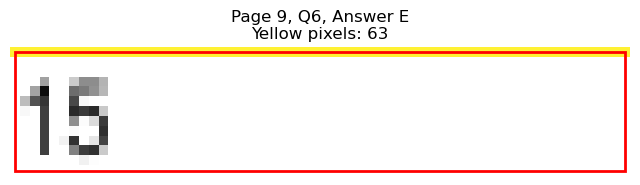


Page 9, Q6 - Selected Answer: D (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=85.0, y0=554.9, x1=152.4, y1=567.0
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 363
Page 9, Q7, A: Yellow percentage: 0.0%


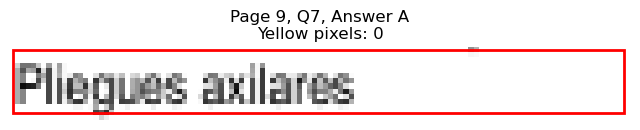

Page 9, Q7 - B: Detected box: x0=85.0, y0=567.1, x1=117.0, y1=579.2
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 165
Page 9, Q7, B: Yellow percentage: 0.0%


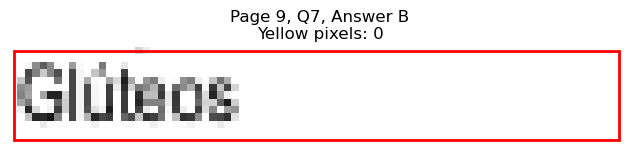

Page 9, Q7 - C: Detected box: x0=85.0, y0=579.1, x1=147.7, y1=591.2
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 331
Page 9, Q7, C: Yellow percentage: 0.0%


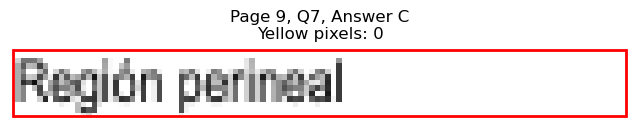

Page 9, Q7 - D: Detected box: x0=336.7, y0=554.9, x1=374.0, y1=567.0
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 193
Page 9, Q7, D: Yellow percentage: 0.0%


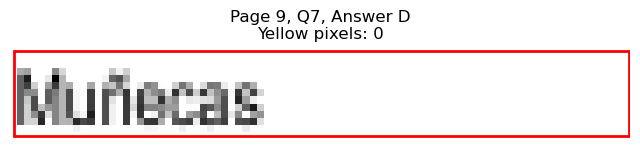

Page 9, Q7 - E: Detected box: x0=336.7, y0=567.1, x1=404.6, y1=579.2
Page 9, Q7, E: Yellow pixels: 1146
Page 9, Q7, E: Total non-white pixels: 1547
Page 9, Q7, E: Yellow percentage: 74.1%


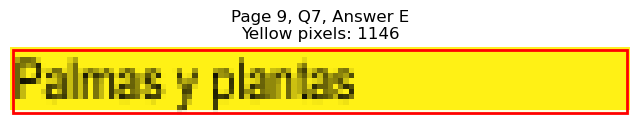


Page 9, Q7 - Selected Answer: E (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=85.0, y0=615.2, x1=210.9, y1=627.3
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 598
Page 9, Q8, A: Yellow percentage: 0.0%


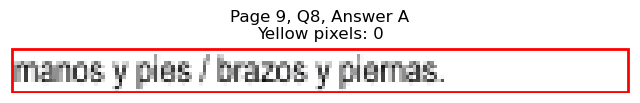

Page 9, Q8 - B: Detected box: x0=85.0, y0=627.3, x1=199.9, y1=639.4
Page 9, Q8, B: Yellow pixels: 1570
Page 9, Q8, B: Total non-white pixels: 2158
Page 9, Q8, B: Yellow percentage: 72.8%


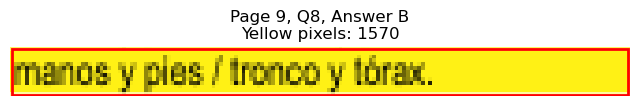

Page 9, Q8 - C: Detected box: x0=85.0, y0=639.3, x1=199.9, y1=651.4
Page 9, Q8, C: Yellow pixels: 2
Page 9, Q8, C: Total non-white pixels: 675
Page 9, Q8, C: Yellow percentage: 0.3%


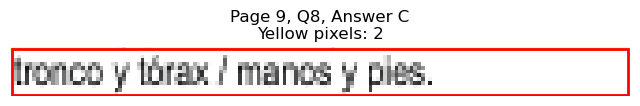

Page 9, Q8 - D: Detected box: x0=336.7, y0=615.2, x1=464.0, y1=627.3
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 581
Page 9, Q8, D: Yellow percentage: 0.0%


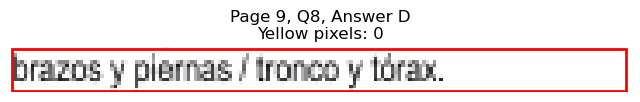

Page 9, Q8 - E: Detected box: x0=336.7, y0=627.3, x1=462.6, y1=639.4
Page 9, Q8, E: Yellow pixels: 0
Page 9, Q8, E: Total non-white pixels: 594
Page 9, Q8, E: Yellow percentage: 0.0%


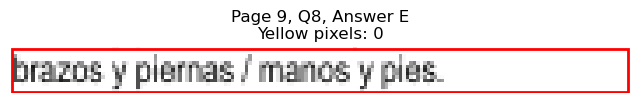


Page 9, Q8 - Selected Answer: B (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=85.0, y0=699.5, x1=360.2, y1=711.7
Page 9, Q9, A: Yellow pixels: 3154
Page 9, Q9, A: Total non-white pixels: 4251
Page 9, Q9, A: Yellow percentage: 74.2%


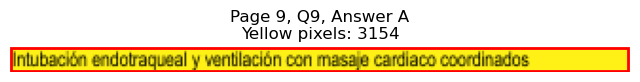

Page 9, Q9 - B: Detected box: x0=85.0, y0=711.7, x1=342.1, y1=723.8
Page 9, Q9, B: Yellow pixels: 309
Page 9, Q9, B: Total non-white pixels: 1564
Page 9, Q9, B: Yellow percentage: 19.8%


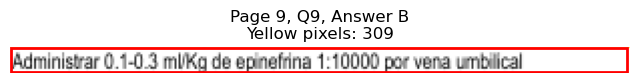

Page 9, Q9 - C: Detected box: x0=85.0, y0=723.7, x1=344.0, y1=735.8
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 1281
Page 9, Q9, C: Yellow percentage: 0.0%


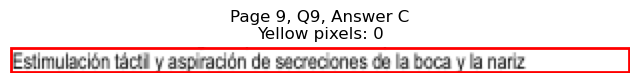

Page 9, Q9 - D: Detected box: x0=85.0, y0=735.8, x1=336.8, y1=747.9
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 1245
Page 9, Q9, D: Yellow percentage: 0.0%


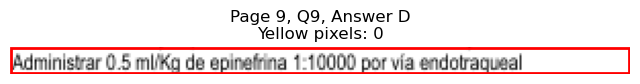

Page 9, Q9 - E: Detected box: x0=85.0, y0=747.8, x1=327.7, y1=759.9
Page 9, Q9, E: Yellow pixels: 0
Page 9, Q9, E: Total non-white pixels: 1204
Page 9, Q9, E: Yellow percentage: 0.0%


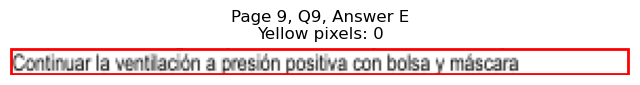


Page 9, Q9 - Selected Answer: A (based on yellow pixel count)





Page 10: Found 8 questions
Page 10, Q1 - A: Detected box: x0=85.0, y0=121.2, x1=245.3, y1=133.3
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 778
Page 10, Q1, A: Yellow percentage: 0.0%


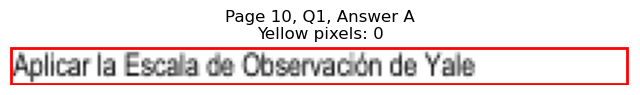

Page 10, Q1 - B: Detected box: x0=85.0, y0=133.2, x1=178.0, y1=145.3
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 513
Page 10, Q1, B: Yellow percentage: 0.0%


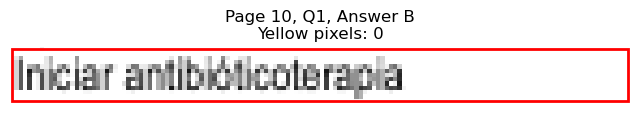

Page 10, Q1 - C: Detected box: x0=85.0, y0=145.3, x1=166.3, y1=157.4
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 420
Page 10, Q1, C: Yellow percentage: 0.0%


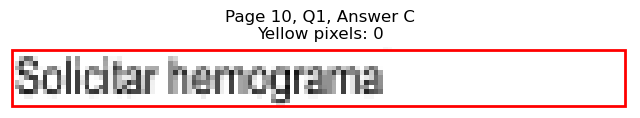

Page 10, Q1 - D: Detected box: x0=336.7, y0=121.2, x1=423.8, y1=133.3
Page 10, Q1, D: Yellow pixels: 138
Page 10, Q1, D: Total non-white pixels: 607
Page 10, Q1, D: Yellow percentage: 22.7%


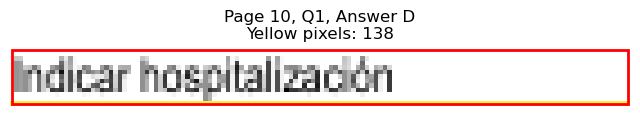

Page 10, Q1 - E: Detected box: x0=336.7, y0=133.2, x1=466.9, y1=145.3
Page 10, Q1, E: Yellow pixels: 1644
Page 10, Q1, E: Total non-white pixels: 2353
Page 10, Q1, E: Yellow percentage: 69.9%


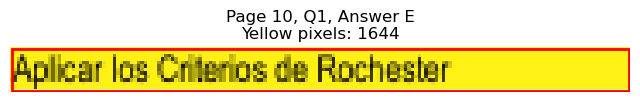


Page 10, Q1 - Selected Answer: E (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=85.0, y0=205.5, x1=148.7, y1=217.7
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 325
Page 10, Q2, A: Yellow percentage: 0.0%


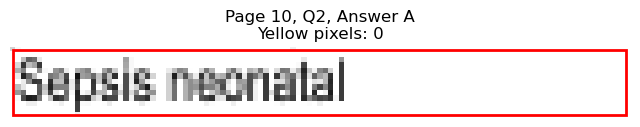

Page 10, Q2 - B: Detected box: x0=85.0, y0=217.5, x1=152.1, y1=229.7
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 358
Page 10, Q2, B: Yellow percentage: 0.0%


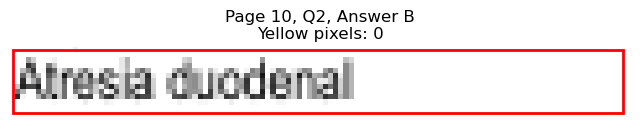

Page 10, Q2 - C: Detected box: x0=85.0, y0=229.7, x1=153.5, y1=241.8
Page 10, Q2, C: Yellow pixels: 1141
Page 10, Q2, C: Total non-white pixels: 1560
Page 10, Q2, C: Yellow percentage: 73.1%


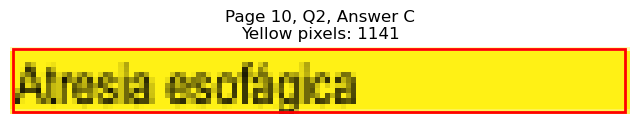

Page 10, Q2 - D: Detected box: x0=336.7, y0=205.5, x1=420.0, y1=217.7
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 451
Page 10, Q2, D: Yellow percentage: 0.0%


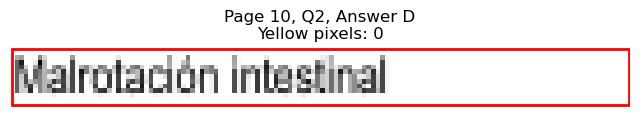

Page 10, Q2 - E: Detected box: x0=336.7, y0=217.5, x1=406.0, y1=229.7
Page 10, Q2, E: Yellow pixels: 0
Page 10, Q2, E: Total non-white pixels: 374
Page 10, Q2, E: Yellow percentage: 0.0%


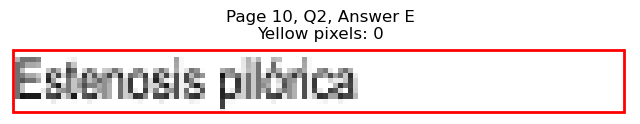


Page 10, Q2 - Selected Answer: C (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=85.0, y0=277.8, x1=190.4, y1=289.9
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 568
Page 10, Q3, A: Yellow percentage: 0.0%


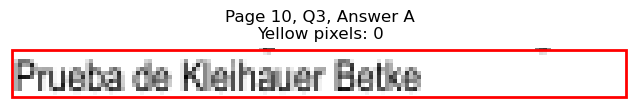

Page 10, Q3 - B: Detected box: x0=85.0, y0=289.9, x1=179.8, y1=302.0
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 486
Page 10, Q3, B: Yellow percentage: 0.0%


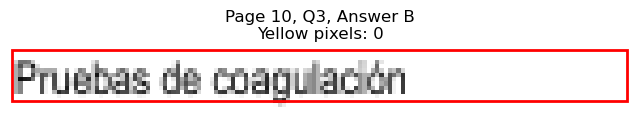

Page 10, Q3 - C: Detected box: x0=85.0, y0=301.9, x1=166.3, y1=314.0
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 429
Page 10, Q3, C: Yellow percentage: 0.0%


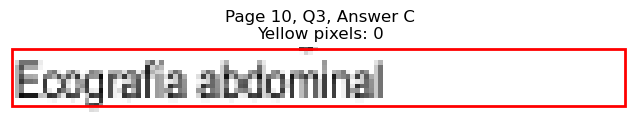

Page 10, Q3 - D: Detected box: x0=336.7, y0=277.8, x1=394.2, y1=289.9
Page 10, Q3, D: Yellow pixels: 1079
Page 10, Q3, D: Total non-white pixels: 1417
Page 10, Q3, D: Yellow percentage: 76.1%


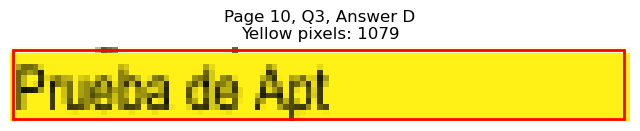

Page 10, Q3 - E: Detected box: x0=336.7, y0=289.9, x1=406.0, y1=302.0
Page 10, Q3, E: Yellow pixels: 120
Page 10, Q3, E: Total non-white pixels: 475
Page 10, Q3, E: Yellow percentage: 25.3%


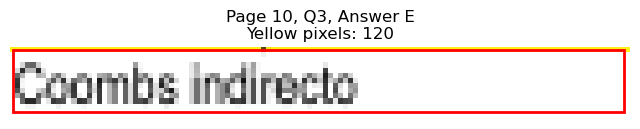


Page 10, Q3 - Selected Answer: D (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=70.8, y0=362.2, x1=79.0, y1=374.3
Page 10, Q4, A: Yellow pixels: 662
Page 10, Q4, A: Total non-white pixels: 767
Page 10, Q4, A: Yellow percentage: 86.3%


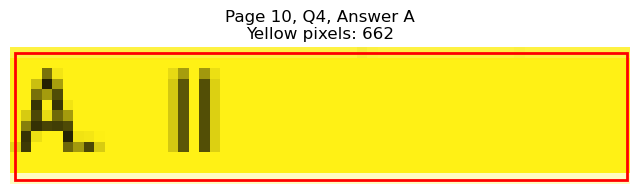

Page 10, Q4 - B: Detected box: x0=70.8, y0=374.2, x1=79.0, y1=386.3
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 130
Page 10, Q4, B: Yellow percentage: 0.0%


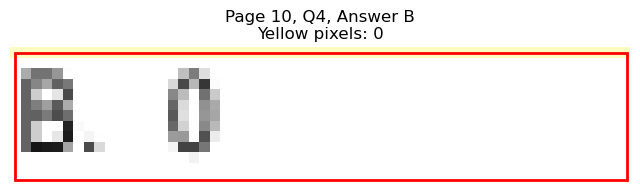

Page 10, Q4 - C: Detected box: x0=85.0, y0=386.3, x1=94.6, y1=398.4
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 48
Page 10, Q4, C: Yellow percentage: 0.0%


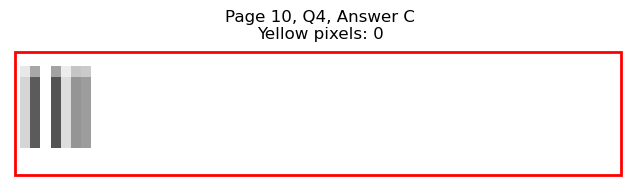

Page 10, Q4 - D: Detected box: x0=336.7, y0=362.2, x1=347.2, y1=374.3
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 44
Page 10, Q4, D: Yellow percentage: 0.0%


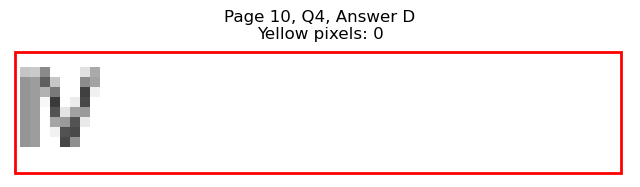

Page 10, Q4 - E: Detected box: x0=322.5, y0=374.2, x1=330.7, y1=386.3
Page 10, Q4, E: Yellow pixels: 0
Page 10, Q4, E: Total non-white pixels: 46
Page 10, Q4, E: Yellow percentage: 0.0%


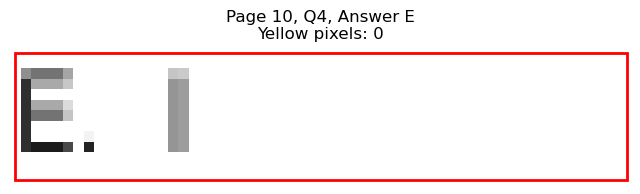


Page 10, Q4 - Selected Answer: A (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=85.0, y0=434.4, x1=179.8, y1=446.5
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 487
Page 10, Q5, A: Yellow percentage: 0.0%


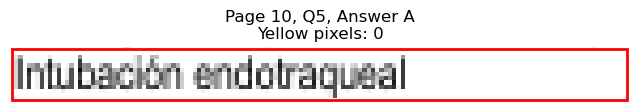

Page 10, Q5 - B: Detected box: x0=85.0, y0=446.6, x1=156.3, y1=458.7
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 349
Page 10, Q5, B: Yellow percentage: 0.0%


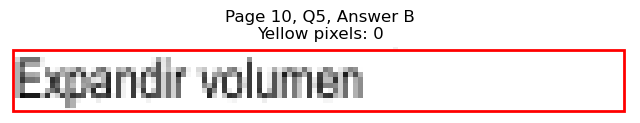

Page 10, Q5 - C: Detected box: x0=85.0, y0=458.6, x1=176.9, y1=470.7
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 485
Page 10, Q5, C: Yellow percentage: 0.0%


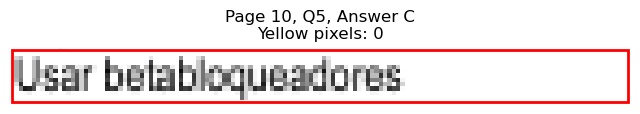

Page 10, Q5 - D: Detected box: x0=336.7, y0=434.4, x1=430.5, y1=446.5
Page 10, Q5, D: Yellow pixels: 1477
Page 10, Q5, D: Total non-white pixels: 1885
Page 10, Q5, D: Yellow percentage: 78.4%


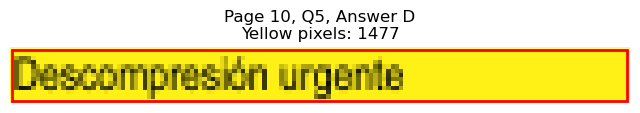

Page 10, Q5 - E: Detected box: x0=336.7, y0=446.6, x1=408.9, y1=458.7
Page 10, Q5, E: Yellow pixels: 123
Page 10, Q5, E: Total non-white pixels: 489
Page 10, Q5, E: Yellow percentage: 25.2%


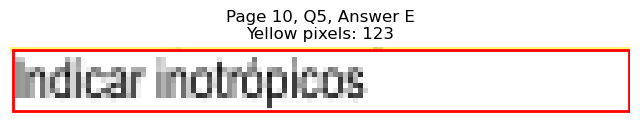


Page 10, Q5 - Selected Answer: D (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=85.0, y0=530.9, x1=205.6, y1=543.0
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 593
Page 10, Q6, A: Yellow percentage: 0.0%


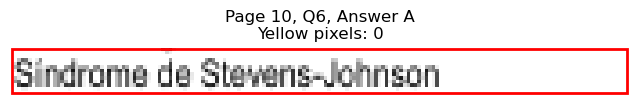

Page 10, Q6 - B: Detected box: x0=85.0, y0=542.9, x1=221.0, y1=555.0
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 682
Page 10, Q6, B: Yellow percentage: 0.0%


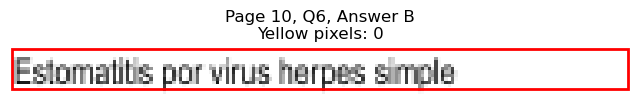

Page 10, Q6 - C: Detected box: x0=85.0, y0=554.9, x1=197.0, y1=567.0
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 586
Page 10, Q6, C: Yellow percentage: 0.0%


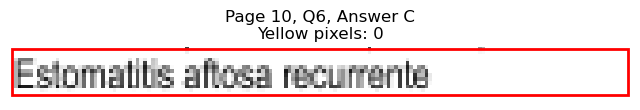

Page 10, Q6 - D: Detected box: x0=336.7, y0=530.9, x1=437.2, y1=543.0
Page 10, Q6, D: Yellow pixels: 152
Page 10, Q6, D: Total non-white pixels: 825
Page 10, Q6, D: Yellow percentage: 18.4%


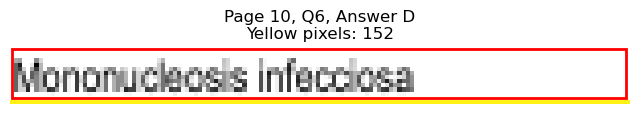

Page 10, Q6 - E: Detected box: x0=336.7, y0=542.9, x1=383.6, y1=555.0
Page 10, Q6, E: Yellow pixels: 975
Page 10, Q6, E: Total non-white pixels: 1277
Page 10, Q6, E: Yellow percentage: 76.4%


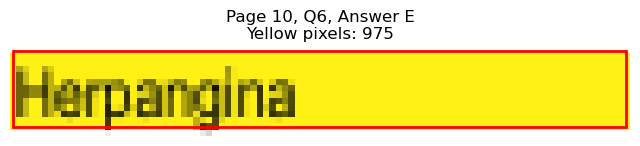


Page 10, Q6 - Selected Answer: E (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=85.0, y0=615.2, x1=227.2, y1=627.3
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 755
Page 10, Q7, A: Yellow percentage: 0.0%


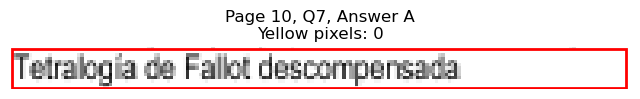

Page 10, Q7 - B: Detected box: x0=85.0, y0=627.3, x1=158.7, y1=639.4
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 396
Page 10, Q7, B: Yellow percentage: 0.0%


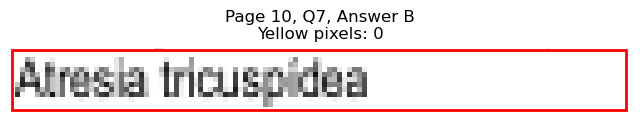

Page 10, Q7 - C: Detected box: x0=85.0, y0=639.3, x1=242.0, y1=651.4
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 783
Page 10, Q7, C: Yellow percentage: 0.0%


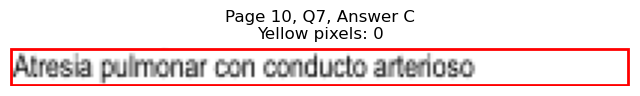

Page 10, Q7 - D: Detected box: x0=336.7, y0=615.2, x1=471.7, y1=627.3
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 683
Page 10, Q7, D: Yellow percentage: 0.0%


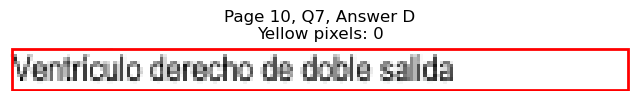

Page 10, Q7 - E: Detected box: x0=336.7, y0=627.3, x1=463.1, y1=639.4
Page 10, Q7, E: Yellow pixels: 1652
Page 10, Q7, E: Total non-white pixels: 2314
Page 10, Q7, E: Yellow percentage: 71.4%


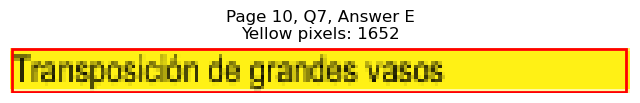


Page 10, Q7 - Selected Answer: E (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=85.0, y0=699.5, x1=151.1, y1=711.7
Page 10, Q8, A: Yellow pixels: 1258
Page 10, Q8, A: Total non-white pixels: 1534
Page 10, Q8, A: Yellow percentage: 82.0%


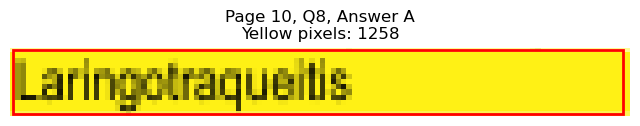

Page 10, Q8 - B: Detected box: x0=85.0, y0=711.7, x1=172.1, y1=723.8
Page 10, Q8, B: Yellow pixels: 138
Page 10, Q8, B: Total non-white pixels: 563
Page 10, Q8, B: Yellow percentage: 24.5%


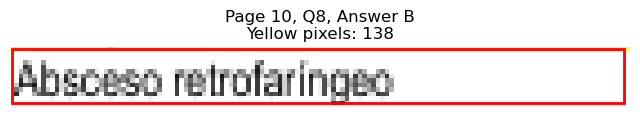

Page 10, Q8 - C: Detected box: x0=85.0, y0=723.7, x1=124.2, y1=735.8
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 232
Page 10, Q8, C: Yellow percentage: 0.0%


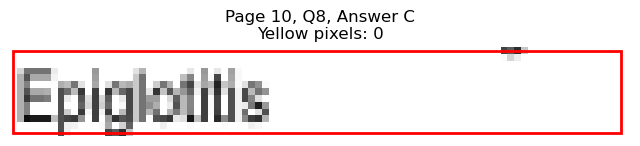

Page 10, Q8 - D: Detected box: x0=336.7, y0=699.5, x1=420.9, y1=711.7
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 444
Page 10, Q8, D: Yellow percentage: 0.0%


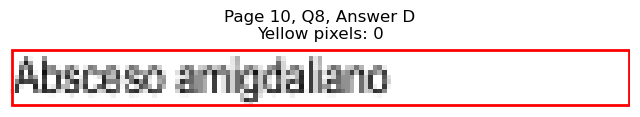

Page 10, Q8 - E: Detected box: x0=336.7, y0=711.7, x1=448.8, y1=723.8
Page 10, Q8, E: Yellow pixels: 0
Page 10, Q8, E: Total non-white pixels: 562
Page 10, Q8, E: Yellow percentage: 0.0%


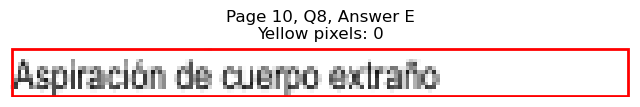


Page 10, Q8 - Selected Answer: A (based on yellow pixel count)





Page 11: Found 9 questions
Page 11, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=137.7, y1=109.2
Page 11, Q1, A: Yellow pixels: 0
Page 11, Q1, A: Total non-white pixels: 273
Page 11, Q1, A: Yellow percentage: 0.0%


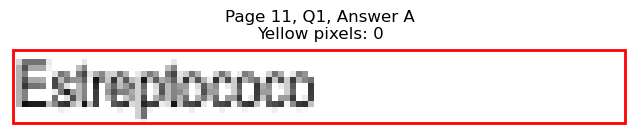

Page 11, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=138.1, y1=121.3
Page 11, Q1, B: Yellow pixels: 0
Page 11, Q1, B: Total non-white pixels: 257
Page 11, Q1, B: Yellow percentage: 0.0%


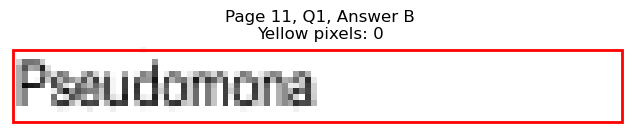

Page 11, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=133.3, y1=133.3
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 241
Page 11, Q1, C: Yellow percentage: 0.0%


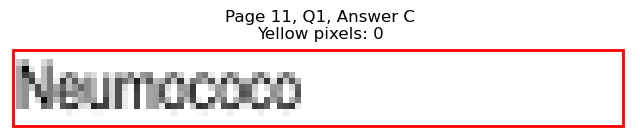

Page 11, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=378.3, y1=109.2
Page 11, Q1, D: Yellow pixels: 958
Page 11, Q1, D: Total non-white pixels: 1209
Page 11, Q1, D: Yellow percentage: 79.2%


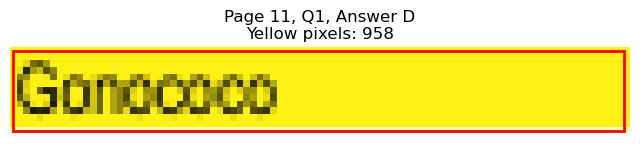

Page 11, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=385.5, y1=121.3
Page 11, Q1, E: Yellow pixels: 0
Page 11, Q1, E: Total non-white pixels: 364
Page 11, Q1, E: Yellow percentage: 0.0%


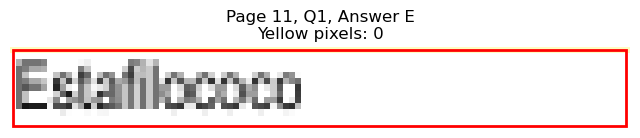


Page 11, Q1 - Selected Answer: D (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=85.0, y0=157.3, x1=151.0, y1=169.4
Page 11, Q2, A: Yellow pixels: 1226
Page 11, Q2, A: Total non-white pixels: 1521
Page 11, Q2, A: Yellow percentage: 80.6%


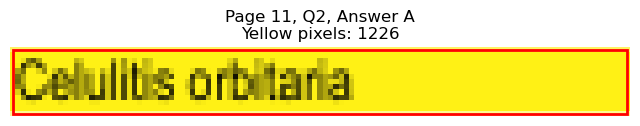

Page 11, Q2 - B: Detected box: x0=85.0, y0=169.4, x1=126.1, y1=181.5
Page 11, Q2, B: Yellow pixels: 93
Page 11, Q2, B: Total non-white pixels: 334
Page 11, Q2, B: Yellow percentage: 27.8%


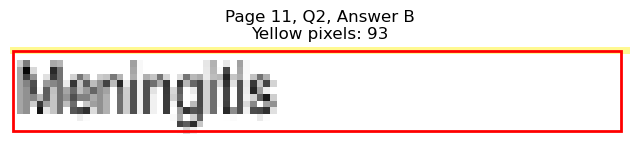

Page 11, Q2 - C: Detected box: x0=85.0, y0=181.4, x1=202.7, y1=193.5
Page 11, Q2, C: Yellow pixels: 0
Page 11, Q2, C: Total non-white pixels: 603
Page 11, Q2, C: Yellow percentage: 0.0%


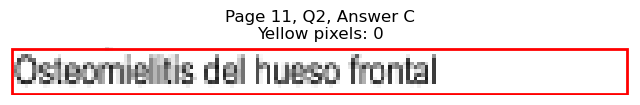

Page 11, Q2 - D: Detected box: x0=336.7, y0=157.3, x1=400.9, y1=169.4
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 319
Page 11, Q2, D: Yellow percentage: 0.0%


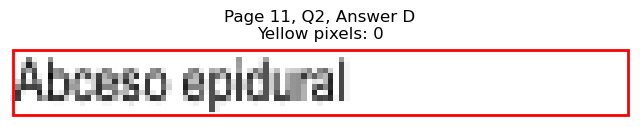

Page 11, Q2 - E: Detected box: x0=336.7, y0=169.4, x1=456.3, y1=181.5
Page 11, Q2, E: Yellow pixels: 0
Page 11, Q2, E: Total non-white pixels: 567
Page 11, Q2, E: Yellow percentage: 0.0%


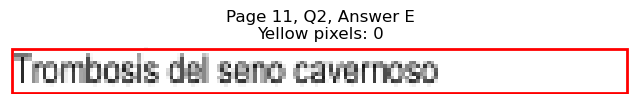


Page 11, Q2 - Selected Answer: A (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=85.0, y0=229.7, x1=184.6, y1=241.8
Page 11, Q3, A: Yellow pixels: 0
Page 11, Q3, A: Total non-white pixels: 498
Page 11, Q3, A: Yellow percentage: 0.0%


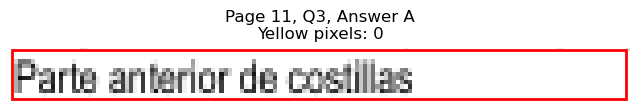

Page 11, Q3 - B: Detected box: x0=85.0, y0=241.7, x1=120.4, y1=253.8
Page 11, Q3, B: Yellow pixels: 0
Page 11, Q3, B: Total non-white pixels: 257
Page 11, Q3, B: Yellow percentage: 0.0%


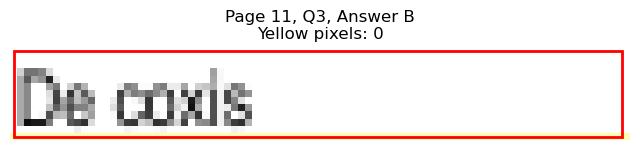

Page 11, Q3 - C: Detected box: x0=85.0, y0=253.7, x1=161.5, y1=265.8
Page 11, Q3, C: Yellow pixels: 1220
Page 11, Q3, C: Total non-white pixels: 1664
Page 11, Q3, C: Yellow percentage: 73.3%


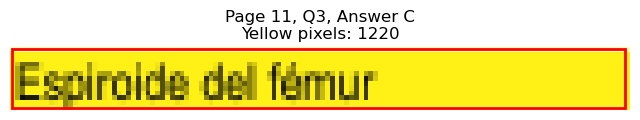

Page 11, Q3 - D: Detected box: x0=336.7, y0=229.7, x1=428.1, y1=241.8
Page 11, Q3, D: Yellow pixels: 0
Page 11, Q3, D: Total non-white pixels: 465
Page 11, Q3, D: Yellow percentage: 0.0%


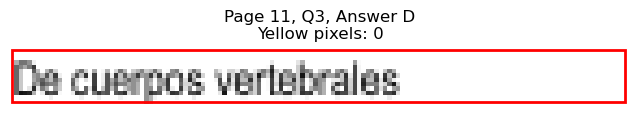

Page 11, Q3 - E: Detected box: x0=336.7, y0=241.7, x1=381.7, y1=253.8
Page 11, Q3, E: Yellow pixels: 0
Page 11, Q3, E: Total non-white pixels: 226
Page 11, Q3, E: Yellow percentage: 0.0%


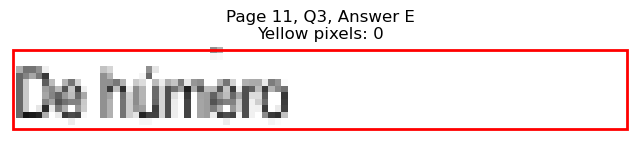


Page 11, Q3 - Selected Answer: C (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=85.0, y0=301.9, x1=136.7, y1=314.0
Page 11, Q4, A: Yellow pixels: 103
Page 11, Q4, A: Total non-white pixels: 460
Page 11, Q4, A: Yellow percentage: 22.4%


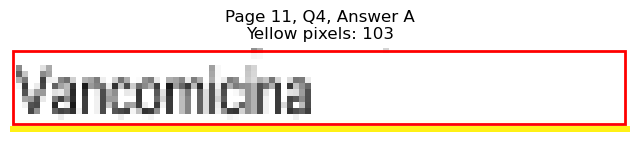

Page 11, Q4 - B: Detected box: x0=85.0, y0=313.9, x1=130.9, y1=326.0
Page 11, Q4, B: Yellow pixels: 979
Page 11, Q4, B: Total non-white pixels: 1358
Page 11, Q4, B: Yellow percentage: 72.1%


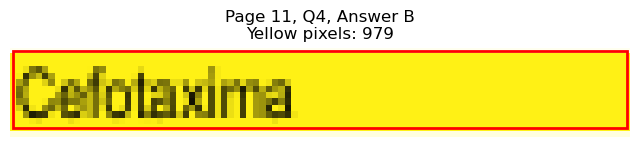

Page 11, Q4 - C: Detected box: x0=85.0, y0=326.1, x1=135.7, y1=338.2
Page 11, Q4, C: Yellow pixels: 0
Page 11, Q4, C: Total non-white pixels: 362
Page 11, Q4, C: Yellow percentage: 0.0%


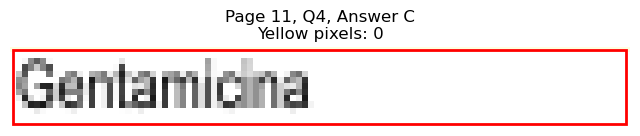

Page 11, Q4 - D: Detected box: x0=336.7, y0=301.9, x1=374.5, y1=314.0
Page 11, Q4, D: Yellow pixels: 0
Page 11, Q4, D: Total non-white pixels: 200
Page 11, Q4, D: Yellow percentage: 0.0%


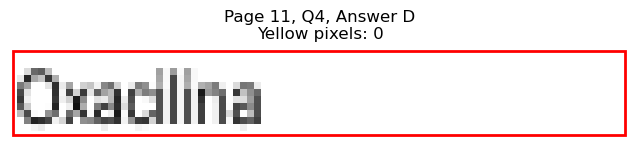

Page 11, Q4 - E: Detected box: x0=336.7, y0=313.9, x1=378.8, y1=326.0
Page 11, Q4, E: Yellow pixels: 0
Page 11, Q4, E: Total non-white pixels: 209
Page 11, Q4, E: Yellow percentage: 0.0%


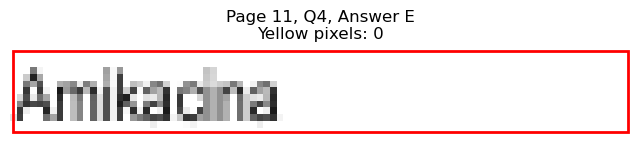


Page 11, Q4 - Selected Answer: B (based on yellow pixel count)




Page 11, Q5 - A: Detected box: x0=70.8, y0=362.2, x1=79.0, y1=374.3
Page 11, Q5, A: Yellow pixels: 59
Page 11, Q5, A: Total non-white pixels: 122
Page 11, Q5, A: Yellow percentage: 48.4%


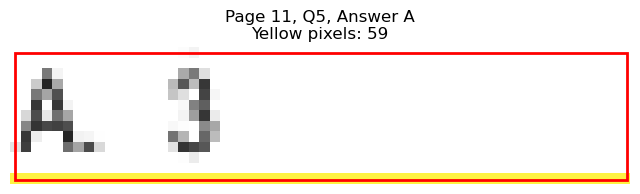

Page 11, Q5 - B: Detected box: x0=70.8, y0=374.2, x1=79.0, y1=386.3
Page 11, Q5, B: Yellow pixels: 649
Page 11, Q5, B: Total non-white pixels: 767
Page 11, Q5, B: Yellow percentage: 84.6%


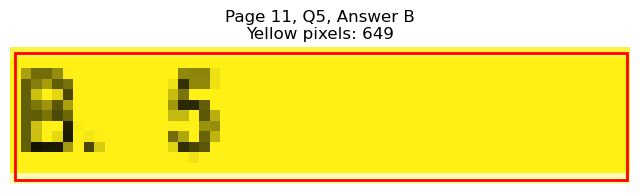

Page 11, Q5 - C: Detected box: x0=70.8, y0=386.3, x1=79.5, y1=398.4
Page 11, Q5, C: Yellow pixels: 0
Page 11, Q5, C: Total non-white pixels: 114
Page 11, Q5, C: Yellow percentage: 0.0%


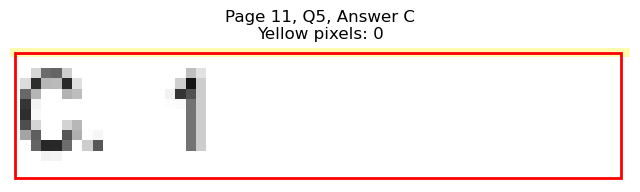

Page 11, Q5 - D: Detected box: x0=322.5, y0=362.2, x1=331.2, y1=374.3
Page 11, Q5, D: Yellow pixels: 0
Page 11, Q5, D: Total non-white pixels: 63
Page 11, Q5, D: Yellow percentage: 0.0%


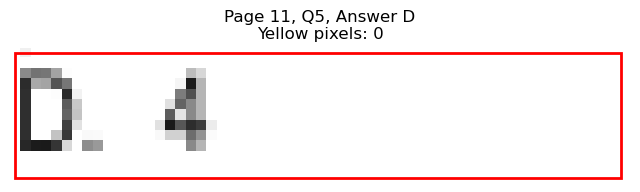

Page 11, Q5 - E: Detected box: x0=322.5, y0=374.2, x1=330.7, y1=386.3
Page 11, Q5, E: Yellow pixels: 0
Page 11, Q5, E: Total non-white pixels: 55
Page 11, Q5, E: Yellow percentage: 0.0%


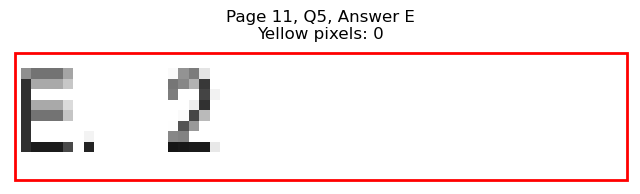


Page 11, Q5 - Selected Answer: B (based on yellow pixel count)




Page 11, Q6 - A: Detected box: x0=85.0, y0=434.4, x1=280.9, y1=446.5
Page 11, Q6, A: Yellow pixels: 0
Page 11, Q6, A: Total non-white pixels: 942
Page 11, Q6, A: Yellow percentage: 0.0%


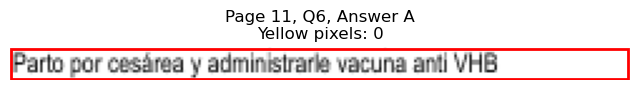

Page 11, Q6 - B: Detected box: x0=85.0, y0=446.6, x1=319.5, y1=458.7
Page 11, Q6, B: Yellow pixels: 0
Page 11, Q6, B: Total non-white pixels: 1160
Page 11, Q6, B: Yellow percentage: 0.0%


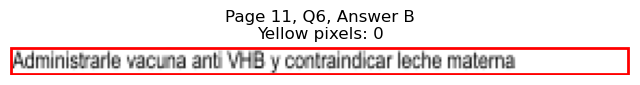

Page 11, Q6 - C: Detected box: x0=85.0, y0=458.6, x1=354.4, y1=470.7
Page 11, Q6, C: Yellow pixels: 0
Page 11, Q6, C: Total non-white pixels: 1346
Page 11, Q6, C: Yellow percentage: 0.0%


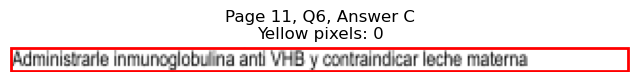

Page 11, Q6 - D: Detected box: x0=85.0, y0=470.7, x1=316.3, y1=482.8
Page 11, Q6, D: Yellow pixels: 1
Page 11, Q6, D: Total non-white pixels: 1440
Page 11, Q6, D: Yellow percentage: 0.1%


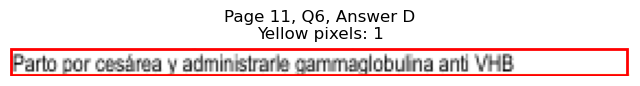

Page 11, Q6 - E: Detected box: x0=85.0, y0=482.7, x1=312.8, y1=494.8
Page 11, Q6, E: Yellow pixels: 2434
Page 11, Q6, E: Total non-white pixels: 3627
Page 11, Q6, E: Yellow percentage: 67.1%


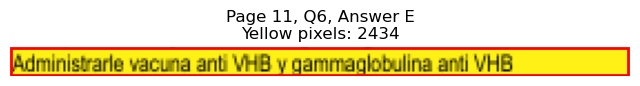


Page 11, Q6 - Selected Answer: E (based on yellow pixel count)




Page 11, Q7 - A: Detected box: x0=85.0, y0=542.9, x1=168.3, y1=555.0
Page 11, Q7, A: Yellow pixels: 1270
Page 11, Q7, A: Total non-white pixels: 1757
Page 11, Q7, A: Yellow percentage: 72.3%


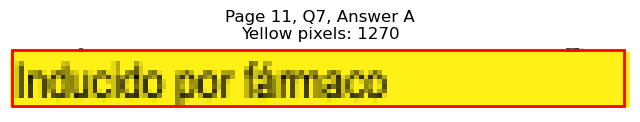

Page 11, Q7 - B: Detected box: x0=85.0, y0=554.9, x1=135.7, y1=567.0
Page 11, Q7, B: Yellow pixels: 100
Page 11, Q7, B: Total non-white pixels: 353
Page 11, Q7, B: Yellow percentage: 28.3%


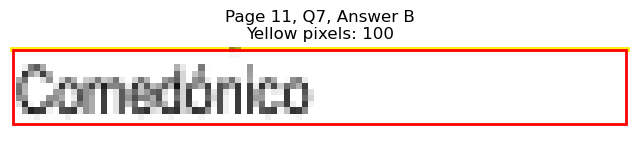

Page 11, Q7 - C: Detected box: x0=85.0, y0=567.1, x1=163.5, y1=579.2
Page 11, Q7, C: Yellow pixels: 0
Page 11, Q7, C: Total non-white pixels: 389
Page 11, Q7, C: Yellow percentage: 0.0%


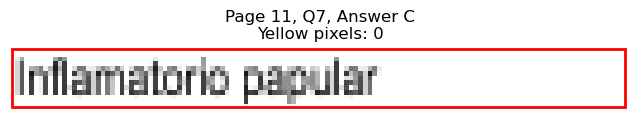

Page 11, Q7 - D: Detected box: x0=336.7, y0=542.9, x1=423.3, y1=555.0
Page 11, Q7, D: Yellow pixels: 0
Page 11, Q7, D: Total non-white pixels: 471
Page 11, Q7, D: Yellow percentage: 0.0%


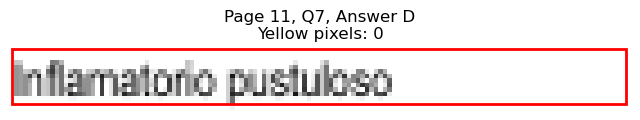

Page 11, Q7 - E: Detected box: x0=336.7, y0=554.9, x1=398.5, y1=567.0
Page 11, Q7, E: Yellow pixels: 0
Page 11, Q7, E: Total non-white pixels: 329
Page 11, Q7, E: Yellow percentage: 0.0%


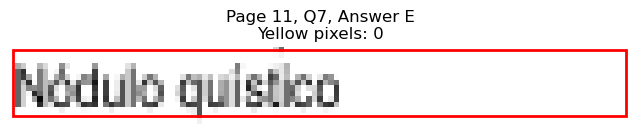


Page 11, Q7 - Selected Answer: A (based on yellow pixel count)




Page 11, Q8 - A: Detected box: x0=70.8, y0=627.3, x1=79.0, y1=639.4
Page 11, Q8, A: Yellow pixels: 657
Page 11, Q8, A: Total non-white pixels: 767
Page 11, Q8, A: Yellow percentage: 85.7%


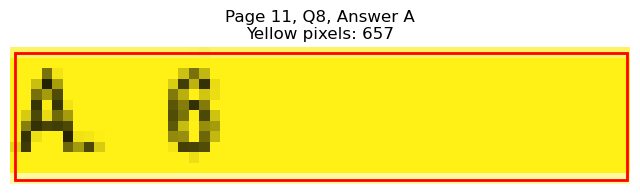

Page 11, Q8 - B: Detected box: x0=85.0, y0=639.3, x1=97.0, y1=651.4
Page 11, Q8, B: Yellow pixels: 0
Page 11, Q8, B: Total non-white pixels: 112
Page 11, Q8, B: Yellow percentage: 0.0%


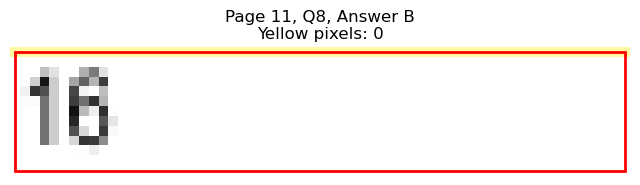

Page 11, Q8 - C: Detected box: x0=85.0, y0=651.4, x1=97.0, y1=663.5
Page 11, Q8, C: Yellow pixels: 0
Page 11, Q8, C: Total non-white pixels: 44
Page 11, Q8, C: Yellow percentage: 0.0%


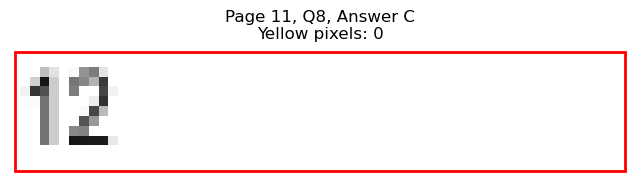

Page 11, Q8 - D: Detected box: x0=336.7, y0=627.3, x1=348.7, y1=639.4
Page 11, Q8, D: Yellow pixels: 0
Page 11, Q8, D: Total non-white pixels: 53
Page 11, Q8, D: Yellow percentage: 0.0%


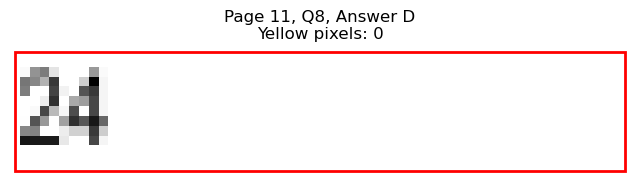

Page 11, Q8 - E: Detected box: x0=336.7, y0=639.3, x1=348.7, y1=651.4
Page 11, Q8, E: Yellow pixels: 0
Page 11, Q8, E: Total non-white pixels: 43
Page 11, Q8, E: Yellow percentage: 0.0%


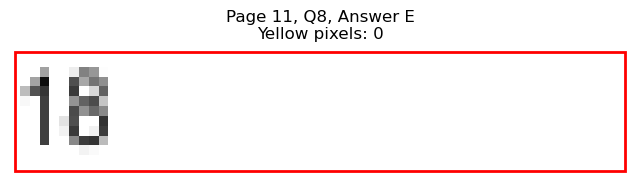


Page 11, Q8 - Selected Answer: A (based on yellow pixel count)




Page 11, Q9 - A: Detected box: x0=85.0, y0=687.5, x1=160.6, y1=699.7
Page 11, Q9, A: Yellow pixels: 1336
Page 11, Q9, A: Total non-white pixels: 1651
Page 11, Q9, A: Yellow percentage: 80.9%


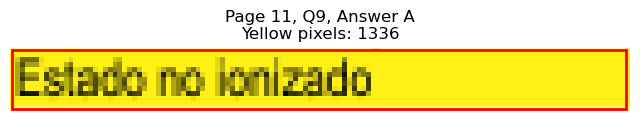

Page 11, Q9 - B: Detected box: x0=85.0, y0=699.5, x1=152.1, y1=711.7
Page 11, Q9, B: Yellow pixels: 119
Page 11, Q9, B: Total non-white pixels: 431
Page 11, Q9, B: Yellow percentage: 27.6%


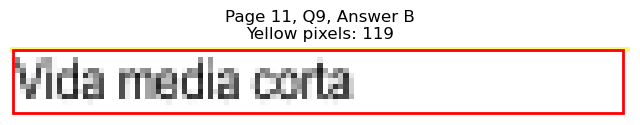

Page 11, Q9 - C: Detected box: x0=85.0, y0=711.7, x1=200.9, y1=723.8
Page 11, Q9, C: Yellow pixels: 0
Page 11, Q9, C: Total non-white pixels: 569
Page 11, Q9, C: Yellow percentage: 0.0%


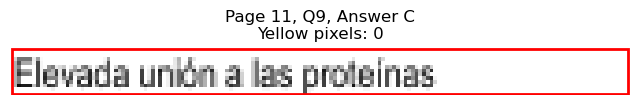

Page 11, Q9 - D: Detected box: x0=336.7, y0=687.5, x1=412.8, y1=699.7
Page 11, Q9, D: Yellow pixels: 0
Page 11, Q9, D: Total non-white pixels: 432
Page 11, Q9, D: Yellow percentage: 0.0%


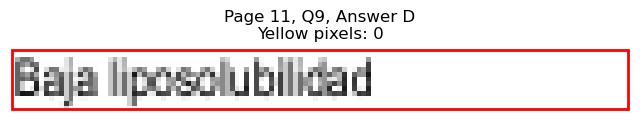

Page 11, Q9 - E: Detected box: x0=336.7, y0=699.5, x1=435.9, y1=711.7
Page 11, Q9, E: Yellow pixels: 0
Page 11, Q9, E: Total non-white pixels: 524
Page 11, Q9, E: Yellow percentage: 0.0%


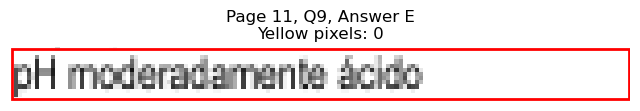


Page 11, Q9 - Selected Answer: A (based on yellow pixel count)





Page 12: Found 2 questions
Page 12, Q1 - A: Detected box: x0=85.0, y0=109.2, x1=97.0, y1=121.3
Page 12, Q1, A: Yellow pixels: 0
Page 12, Q1, A: Total non-white pixels: 50
Page 12, Q1, A: Yellow percentage: 0.0%


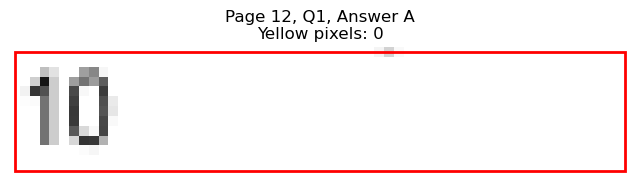

Page 12, Q1 - B: Detected box: x0=85.0, y0=121.2, x1=97.0, y1=133.3
Page 12, Q1, B: Yellow pixels: 0
Page 12, Q1, B: Total non-white pixels: 44
Page 12, Q1, B: Yellow percentage: 0.0%


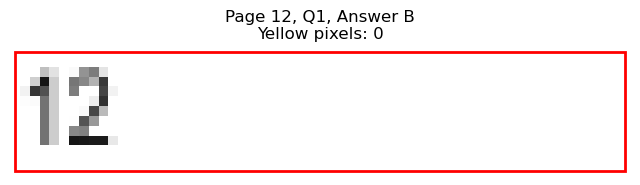

Page 12, Q1 - C: Detected box: x0=85.0, y0=133.2, x1=97.0, y1=145.3
Page 12, Q1, C: Yellow pixels: 0
Page 12, Q1, C: Total non-white pixels: 50
Page 12, Q1, C: Yellow percentage: 0.0%


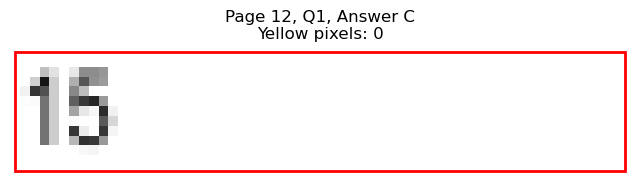

Page 12, Q1 - D: Detected box: x0=336.7, y0=109.2, x1=348.7, y1=121.3
Page 12, Q1, D: Yellow pixels: 717
Page 12, Q1, D: Total non-white pixels: 819
Page 12, Q1, D: Yellow percentage: 87.5%


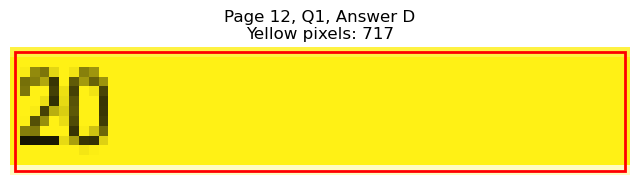

Page 12, Q1 - E: Detected box: x0=336.7, y0=121.2, x1=348.7, y1=133.3
Page 12, Q1, E: Yellow pixels: 0
Page 12, Q1, E: Total non-white pixels: 115
Page 12, Q1, E: Yellow percentage: 0.0%


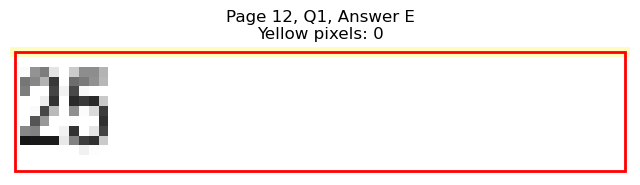


Page 12, Q1 - Selected Answer: D (based on yellow pixel count)




Page 12, Q2 - A: Detected box: x0=85.0, y0=193.4, x1=174.0, y1=205.5
Page 12, Q2, A: Yellow pixels: 1451
Page 12, Q2, A: Total non-white pixels: 1833
Page 12, Q2, A: Yellow percentage: 79.2%


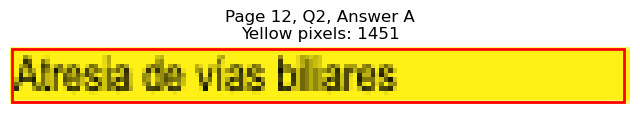

Page 12, Q2 - B: Detected box: x0=85.0, y0=205.5, x1=154.3, y1=217.7
Page 12, Q2, B: Yellow pixels: 121
Page 12, Q2, B: Total non-white pixels: 486
Page 12, Q2, B: Yellow percentage: 24.9%


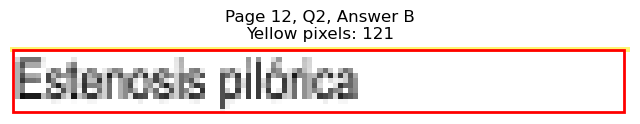

Page 12, Q2 - C: Detected box: x0=85.0, y0=217.5, x1=140.1, y1=229.7
Page 12, Q2, C: Yellow pixels: 0
Page 12, Q2, C: Total non-white pixels: 289
Page 12, Q2, C: Yellow percentage: 0.0%


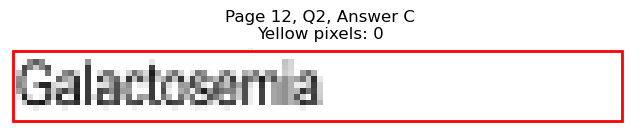

Page 12, Q2 - D: Detected box: x0=336.7, y0=193.4, x1=408.1, y1=205.5
Page 12, Q2, D: Yellow pixels: 0
Page 12, Q2, D: Total non-white pixels: 395
Page 12, Q2, D: Yellow percentage: 0.0%


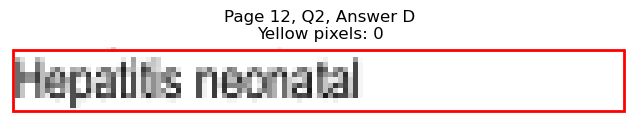

Page 12, Q2 - E: Detected box: x0=336.7, y0=205.5, x1=408.9, y1=217.7
Page 12, Q2, E: Yellow pixels: 0
Page 12, Q2, E: Total non-white pixels: 391
Page 12, Q2, E: Yellow percentage: 0.0%


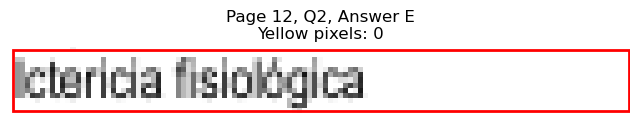


Page 12, Q2 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   ¿En qué circunstancia se interpreta positiva u...
1   Preescolar de 3 años, presenta desde hace 5 dí...
2   Niño con diagnóstico de infección tuberculosa ...
3   Adolescente de 12 años, acude a Emergencia por...
4   ¿Cuál de las siguientes alternativas es una co...
..                                                ...
95  Adolescente acude a la consulta por presentar ...
96  Recién nacido a término con sufrimiento fetal,...
97  ¿Qué factor farmacológico de la droga, favorec...
98  Para hacer el diagnóstico de gemelos discordan...
99  Lactante de 6 semanas, nacido de parto eutócic...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                        Enfermedad de Hodgkin   
1   Gingivo estomatitis irritativa de contacto   
2                                    Etambutol   
3               Vasculitis de Henoch Schönlein   
4                          Hiperbilirrubinemia   
..                                         ...   
95                        Inducido por fármaco   
96                                           6   
97                          Estado no ionizado   
98                                          10   
99                    Atresia de vías biliares   

                                             option_B  \
0   Exposición frecuente a adultos infectados por HIV   
1                                    Candidiasis oral   
2                                      Estreptomicina   
3                        Leucemia linfoblástica aguda   
4                                        Galactosemia   
..                                                ...   
95                                         Comedónico   
96                                                 16   
97                                   Vida media corta   
98                                                 12   
99                                 Estenosis pilórica   

                                           option_C  \
0   Viajes a un país con elevada prevalencia de TBC   
1                                Estomatitis aftosa   
2                                       Rifampicina   
3                                   Aplasia medular   
4                              Prematuridad extrema   
..                                              ...   
95                             Inflamatorio papular   
96                                               12   
97                    Elevada unión a las proteínas   
98                                               15   
99                                     Galactosemia   

                            option_D                                option_E  
0       Niños que acuden a guardería              Niño con infección por HIV  
1   Estomatitis alérgica de contacto  Estomatitis por carencia nutricionales  
2                         Isoniacida                            Pirazinamida  
3        Lupus eritematoso sistémico         Trombocitopenia inmune primaria  
4                      Madre con TBC                Madre con antibioterapia  
..                               ...                                     ...  
95            Inflamatorio pustuloso                         Nódulo quístico  
96                                24                                      18  
97              Baja liposolubilidad                  pH moderadamente ácido  
98                                20                                      25  
99                Hepatitis neonatal                   Ictericia fisiológica  

[100 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               E
1               C
2               D
3               E
4               B
..            ...
95              A
96              A
97              A
98              D
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions  \
0   ¿En qué circunstancia se interpreta positiva u...   
1   Preescolar de 3 años, presenta desde hace 5 dí...   
2   Niño con diagnóstico de infección tuberculosa ...   
3   Adolescente de 12 años, acude a Emergencia por...   
4   ¿Cuál de las siguientes alternativas es una co...   
..                                                ...   
95  Adolescente acude a la consulta por presentar ...   
96  Recién nacido a término con sufrimiento fetal,...   
97  ¿Qué factor farmacológico de la droga, favorec...   
98  Para hacer el diagnóstico de gemelos discordan...   
99  Lactante de 6 semanas, nacido de parto eutócic...   

                                      option_A  \
0                        Enfermedad de Hodgkin   
1   Gingivo estomatitis irritativa de contacto   
2                                    Etambutol   
3               Vasculitis de Henoch Schönlein   
4                          Hiperbilirrubinemia   
..                                         ...   
95                        Inducido por fármaco   
96                                           6   
97                          Estado no ionizado   
98                                          10   
99                    Atresia de vías biliares   

                                             option_B  \
0   Exposición frecuente a adultos infectados por HIV   
1                                    Candidiasis oral   
2                                      Estreptomicina   
3                        Leucemia linfoblástica aguda   
4                                        Galactosemia   
..                                                ...   
95                                         Comedónico   
96                                                 16   
97                                   Vida media corta   
98                                                 12   
99                                 Estenosis pilórica   

                                           option_C  \
0   Viajes a un país con elevada prevalencia de TBC   
1                                Estomatitis aftosa   
2                                       Rifampicina   
3                                   Aplasia medular   
4                              Prematuridad extrema   
..                                              ...   
95                             Inflamatorio papular   
96                                               12   
97                    Elevada unión a las proteínas   
98                                               15   
99                                     Galactosemia   

                            option_D                                option_E  \
0       Niños que acuden a guardería              Niño con infección por HIV   
1   Estomatitis alérgica de contacto  Estomatitis por carencia nutricionales   
2                         Isoniacida                            Pirazinamida   
3        Lupus eritematoso sistémico         Trombocitopenia inmune primaria   
4                      Madre con TBC                Madre con antibioterapia   
..                               ...                                     ...   
95            Inflamatorio pustuloso                         Nódulo quístico   
96                                24                                      18   
97              Baja liposolubilidad                  pH moderadamente ácido   
98                                20                                      25   
99                Hepatitis neonatal                   Ictericia fisiológica   

   correct_answer  
0               E  
1               C  
2               D  
3               E  
4               B  
..            ...  
95              A  
96              A  
97              A  
98              D  
99              A  

[100 rows x 7 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2019/PEDIATRIA.csv
